In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold,f_regression,SelectKBest
from sklearn.model_selection import GridSearchCV
import scikitplot as skplt
from time import time
import datetime

In [2]:
warnings.filterwarnings("ignore")
plt.rcParams['font.family']='SimHei'
plt.rcParams['axes.unicode_minus']=False
train=pd.read_csv(r'C:\Users\EPICFS\Desktop\shangwuzhineng\data/train.csv',encoding='utf-8',index_col='ID')
train.head()
#导入数据

位置  出租方式     区  卧室数量  卫的数量  厅的数量  地铁站点  地铁线路   小区名   小区房屋出租数量  居住状态  \
ID                                                                           
0   118.0   NaN  11.0     1     1     1   4.0   2.0  3072  128.90625   NaN   
1   100.0   NaN  10.0     1     0     0   5.8   4.0  3152  132.81250   NaN   
2   130.0   NaN  12.0     2     2     1   3.7   5.0  5575   42.96875   NaN   
3    90.0   NaN   7.0     3     2     2   6.3   2.0  3103   85.93750   NaN   
4    31.0   NaN   3.0     2     1     1   NaN   NaN  5182  214.84375   NaN   

          总楼层 房屋朝向        房屋面积  时间  楼层  装修情况         距离      Label  
ID                                                                  
0   23.636364   东南   86.279378   1   2   NaN  76.416667   5.602716  
1   38.181818    东  170.456802   1   1   NaN  70.916667  16.977929  
2   29.090909   东南  105.925190   1   0   NaN  57.250000   8.998302  
3   58.181818    南  191.989407   1   2   NaN  65.833333   5.602716  
4   54.545455   东北  104.270109   1   0   NaN        NaN   7.300509

In [3]:
train.isnull().sum()
#查看缺失，发现大部分缺失

位置              31
出租方式        172309
区               31
卧室数量             0
卫的数量             0
厅的数量             0
地铁站点        104761
地铁线路        104761
小区名              0
小区房屋出租数量      1001
居住状态        176401
总楼层              0
房屋朝向             0
房屋面积             0
时间               0
楼层               0
装修情况        178047
距离          104761
Label            0
dtype: int64

In [4]:
#缺失值处理
data=train.groupby('小区名')[['位置','区','地铁站点','地铁线路','小区房屋出租数量','距离']].median()
data.head()
#对同一小区来说，其位置、区、地铁站点、地铁线路、小区房屋出租数量、距离相同，所以用同一小区的相关值进行填充

位置    区  地铁站点  地铁线路   小区房屋出租数量         距离
小区名                                              
0     59.0  6.0   5.7   3.0   7.812500  47.833333
1     59.0  6.0   5.7   3.0  11.718750  56.333333
2     40.0  1.0   3.1   5.0   7.812500  87.416667
4    105.0  8.0   NaN   NaN  15.625000        NaN
5    132.0  8.0   NaN   NaN   9.765625        NaN

In [6]:
for c in data.columns:
    for i in train.index:
        try:
            if np.isnan(train.loc[i,c]):
                print(i)
                n=train.loc[i,'小区名']
                train.loc[i,c]=data.loc[n,c]
        except Exception:
            pass
        continue
# 地铁站点和线路的缺失值表示此房屋附近没有地铁，用0填充，距离用负值填充
train['地铁站点']=train['地铁站点'].fillna(0)
train['地铁线路']=train['地铁线路'].fillna(0)
train['距离']=train['距离'].fillna(-1)
# 出租方式、居住状态和装修情况都是分类变量，根据原数据中没有的特征进行填充
train['出租方式']=train['出租方式'].fillna(2)
train['居住状态']=train['居住状态'].fillna(0)
train['装修情况']=train['装修情况'].fillna(0)
# 剩余缺失值用众数填充
si=SimpleImputer(missing_values=np.nan,strategy='most_frequent')
si.fit(train.loc[:,['小区房屋出租数量']])
train.loc[:,['小区房屋出租数量']] = si.transform(train.loc[:,['小区房屋出租数量']])
si.fit(train.loc[:,['位置']])
train.loc[:,['位置']] = si.transform(train.loc[:,['位置']])
si.fit(train.loc[:,['区']])
train.loc[:,['区']] = si.transform(train.loc[:,['区']])

87169
87686
89090
101618
102958
105400
106243
107728
108349
113818
119571
127246
132357
137717
140425
141042
144922
150611
150911
151020
151601
154089
154883
155079
156161
157018
165054
174515
177637
179707
192466
87169
87686
89090
101618
102958
105400
106243
107728
108349
113818
119571
127246
132357
137717
140425
141042
144922
150611
150911
151020
151601
154089
154883
155079
156161
157018
165054
174515
177637
179707
192466
4
7
10
12
15
16
20
26
28
29
30
31
34
37
43
44
47
48
49
50
55
58
62
65
66
67
69
73
76
78
86
88
91
92
95
96
97
98
99
100
104
106
108
109
110
112
113
114
117
126
128
130
131
134
135
136
137
139
142
144
151
153
154
155
156
162
164
169
170
176
179
180
181
186
188
191
192
197
198
204
206
207
208
209
213
215
217
221
222
225
226
228
230
236
240
241
244
249
253
255
258
260
261
262
266
272
275
277
280
288
289
290
291
294
295
297
300
301
312
313
314
317
318
322
324
325
326
327
332
335
338
342
346
349
351
353
355
358
359
362
363
364
366
367
368
370
374
378
381
384
387
390
392
3

3934
3935
3937
3938
3939
3940
3941
3947
3952
3954
3957
3960
3962
3966
3968
3969
3970
3971
3972
3976
3978
3979
3980
3982
3983
3985
3989
3996
3998
4000
4001
4004
4006
4009
4012
4015
4019
4021
4025
4027
4028
4029
4030
4031
4033
4034
4035
4036
4039
4040
4041
4042
4046
4058
4059
4062
4063
4070
4071
4075
4077
4080
4088
4090
4091
4092
4094
4095
4096
4097
4098
4100
4101
4102
4103
4105
4107
4108
4109
4110
4111
4113
4114
4121
4123
4126
4127
4128
4129
4130
4133
4137
4138
4139
4143
4144
4148
4149
4152
4153
4154
4155
4164
4168
4169
4174
4176
4177
4180
4182
4187
4188
4190
4192
4196
4206
4207
4208
4211
4215
4216
4217
4223
4226
4228
4229
4231
4240
4241
4244
4245
4248
4253
4254
4255
4257
4259
4262
4263
4267
4270
4271
4275
4278
4283
4284
4287
4289
4290
4292
4294
4296
4305
4307
4311
4313
4314
4315
4317
4321
4323
4324
4325
4326
4329
4331
4332
4337
4338
4346
4350
4351
4355
4358
4359
4360
4361
4365
4366
4369
4370
4371
4372
4375
4378
4380
4381
4384
4387
4388
4390
4391
4393
4394
4395
4397
4399
4400
4401
4402


8017
8018
8021
8023
8027
8030
8032
8038
8039
8040
8043
8044
8047
8057
8059
8060
8061
8062
8063
8065
8066
8067
8068
8069
8070
8072
8073
8074
8075
8078
8079
8080
8081
8083
8084
8087
8088
8094
8097
8099
8100
8101
8102
8103
8105
8109
8111
8113
8114
8115
8116
8122
8129
8130
8137
8140
8141
8145
8146
8148
8158
8159
8160
8162
8166
8167
8168
8171
8172
8173
8176
8185
8187
8192
8195
8198
8200
8201
8205
8207
8209
8210
8211
8213
8214
8215
8216
8220
8221
8223
8224
8228
8233
8234
8241
8245
8246
8247
8248
8254
8255
8260
8261
8262
8265
8266
8268
8269
8270
8271
8278
8280
8283
8286
8291
8293
8297
8298
8302
8303
8307
8308
8311
8312
8315
8318
8319
8322
8323
8324
8327
8328
8330
8332
8333
8334
8338
8339
8340
8343
8346
8348
8349
8351
8352
8353
8356
8358
8359
8360
8365
8368
8370
8372
8374
8375
8376
8377
8379
8381
8385
8387
8388
8391
8400
8404
8408
8410
8412
8413
8415
8416
8417
8418
8420
8421
8423
8424
8425
8429
8430
8431
8435
8436
8437
8440
8441
8448
8450
8451
8453
8458
8460
8461
8464
8470
8472
8474
8480
8481


11745
11747
11750
11753
11754
11755
11758
11759
11760
11762
11764
11768
11769
11770
11772
11773
11775
11776
11778
11779
11780
11781
11785
11789
11790
11792
11793
11795
11798
11800
11806
11812
11817
11819
11820
11821
11822
11823
11826
11828
11829
11830
11831
11833
11834
11835
11836
11839
11840
11841
11846
11849
11851
11854
11855
11856
11858
11863
11864
11870
11871
11875
11878
11884
11886
11897
11901
11904
11905
11906
11907
11908
11909
11911
11912
11914
11917
11918
11921
11922
11925
11926
11929
11931
11932
11934
11935
11938
11941
11944
11947
11948
11949
11952
11953
11956
11958
11959
11960
11963
11965
11967
11968
11975
11982
11983
11984
11985
11986
11991
11992
11995
11997
11998
12004
12008
12017
12018
12019
12020
12024
12025
12026
12027
12031
12033
12036
12037
12039
12041
12043
12044
12045
12049
12050
12052
12053
12058
12059
12060
12064
12069
12070
12075
12077
12079
12082
12083
12085
12092
12099
12105
12109
12111
12112
12114
12115
12120
12121
12122
12124
12128
12129
12131
12135
12137
1213

14788
14789
14790
14791
14792
14793
14795
14796
14797
14798
14801
14804
14805
14806
14808
14809
14810
14811
14812
14813
14814
14816
14817
14818
14819
14820
14824
14826
14828
14831
14833
14834
14835
14836
14837
14839
14843
14846
14849
14850
14851
14852
14853
14854
14862
14865
14866
14867
14873
14876
14877
14878
14879
14880
14884
14885
14886
14887
14888
14893
14894
14895
14897
14898
14901
14904
14906
14907
14909
14910
14911
14912
14914
14915
14916
14917
14918
14920
14921
14923
14924
14926
14928
14929
14931
14933
14936
14938
14939
14940
14941
14942
14943
14944
14945
14946
14949
14950
14951
14953
14954
14955
14956
14957
14958
14959
14961
14962
14965
14967
14969
14973
14976
14977
14979
14981
14983
14984
14987
14989
14992
14993
14994
14995
14997
14998
14999
15001
15004
15005
15006
15007
15008
15009
15013
15015
15018
15020
15021
15023
15026
15027
15029
15030
15031
15033
15034
15035
15037
15039
15042
15044
15045
15048
15052
15054
15055
15056
15057
15061
15062
15065
15067
15070
15071
15072
1507

17540
17541
17544
17547
17550
17555
17556
17558
17561
17562
17564
17565
17569
17570
17571
17574
17575
17579
17582
17586
17587
17588
17590
17591
17593
17594
17595
17603
17604
17608
17610
17615
17619
17620
17622
17623
17624
17625
17628
17630
17634
17637
17645
17647
17653
17654
17656
17657
17658
17659
17660
17661
17663
17664
17665
17669
17671
17672
17673
17674
17677
17678
17679
17683
17684
17688
17689
17690
17691
17694
17696
17702
17707
17710
17711
17714
17715
17720
17721
17725
17731
17732
17735
17738
17739
17742
17744
17746
17748
17749
17751
17754
17757
17758
17766
17767
17769
17771
17772
17777
17779
17780
17781
17785
17789
17790
17794
17796
17797
17799
17800
17801
17803
17806
17807
17808
17809
17810
17811
17813
17814
17816
17817
17821
17822
17823
17825
17826
17827
17828
17830
17833
17834
17835
17836
17839
17840
17844
17849
17853
17856
17857
17859
17860
17861
17862
17864
17867
17870
17871
17872
17873
17874
17876
17878
17879
17880
17882
17887
17888
17889
17891
17892
17893
17894
17895
1789

20418
20420
20422
20423
20424
20425
20427
20428
20429
20431
20437
20439
20442
20443
20444
20451
20453
20454
20456
20457
20459
20460
20461
20464
20465
20467
20468
20469
20472
20475
20476
20477
20478
20481
20482
20483
20486
20489
20490
20492
20493
20494
20496
20497
20498
20499
20500
20501
20503
20505
20506
20507
20509
20510
20513
20514
20515
20518
20521
20522
20524
20526
20527
20531
20535
20537
20538
20539
20543
20546
20554
20558
20560
20562
20565
20566
20569
20571
20572
20574
20576
20581
20584
20586
20588
20589
20590
20591
20594
20597
20598
20599
20601
20605
20606
20607
20608
20610
20611
20612
20614
20615
20618
20619
20621
20623
20628
20629
20630
20634
20635
20636
20640
20641
20644
20645
20646
20647
20648
20649
20650
20652
20659
20661
20664
20666
20667
20668
20669
20670
20674
20675
20676
20677
20678
20679
20680
20681
20685
20686
20687
20690
20691
20694
20695
20696
20698
20699
20705
20707
20709
20710
20712
20714
20716
20718
20719
20720
20721
20723
20724
20725
20727
20731
20733
20734
2073

23263
23264
23266
23267
23269
23271
23272
23277
23278
23282
23284
23285
23288
23290
23291
23292
23295
23297
23300
23302
23303
23305
23307
23310
23312
23313
23315
23316
23317
23319
23321
23322
23323
23325
23328
23330
23332
23336
23338
23339
23340
23341
23343
23345
23346
23349
23352
23357
23359
23361
23364
23366
23367
23369
23370
23374
23377
23378
23380
23381
23383
23384
23387
23388
23389
23391
23392
23393
23395
23396
23397
23404
23406
23411
23412
23413
23414
23416
23418
23422
23425
23427
23430
23431
23437
23438
23439
23440
23444
23445
23449
23450
23452
23454
23455
23457
23458
23459
23464
23465
23467
23470
23471
23472
23474
23475
23476
23478
23487
23489
23490
23491
23493
23498
23499
23500
23501
23502
23503
23506
23509
23513
23514
23515
23517
23520
23521
23522
23524
23529
23530
23531
23533
23536
23537
23540
23541
23542
23547
23549
23550
23551
23552
23553
23555
23558
23559
23561
23562
23564
23565
23566
23567
23569
23570
23572
23573
23576
23578
23579
23580
23581
23582
23583
23585
23587
2358

25898
25899
25901
25903
25908
25909
25911
25912
25914
25920
25921
25922
25924
25925
25927
25928
25929
25931
25932
25934
25936
25937
25938
25939
25941
25942
25944
25945
25946
25947
25949
25950
25952
25953
25954
25955
25956
25958
25959
25961
25965
25968
25971
25973
25974
25976
25977
25980
25981
25982
25985
25986
25990
25991
25992
25993
25998
26002
26003
26004
26006
26011
26014
26016
26018
26019
26021
26024
26025
26027
26028
26029
26030
26031
26032
26033
26035
26036
26039
26040
26041
26044
26045
26046
26047
26048
26051
26055
26058
26059
26061
26063
26067
26068
26070
26072
26073
26074
26075
26077
26081
26083
26085
26086
26088
26089
26091
26092
26094
26098
26102
26103
26105
26106
26107
26108
26111
26113
26114
26115
26117
26119
26122
26124
26126
26127
26128
26129
26131
26132
26133
26136
26138
26140
26142
26143
26148
26149
26150
26152
26153
26154
26158
26159
26161
26163
26168
26169
26170
26172
26173
26174
26175
26178
26184
26185
26187
26188
26189
26192
26195
26197
26198
26200
26203
26204
2620

28384
28385
28388
28390
28393
28395
28397
28398
28399
28401
28403
28404
28405
28408
28409
28411
28412
28414
28416
28417
28418
28419
28420
28421
28422
28424
28425
28428
28430
28431
28432
28435
28438
28440
28443
28445
28446
28453
28454
28455
28456
28459
28462
28464
28465
28468
28469
28473
28474
28475
28477
28479
28480
28482
28483
28484
28485
28490
28492
28495
28497
28499
28500
28502
28507
28508
28511
28513
28515
28516
28517
28518
28520
28521
28522
28523
28524
28530
28534
28535
28536
28537
28539
28541
28543
28546
28547
28549
28550
28551
28552
28553
28554
28555
28556
28557
28558
28560
28562
28563
28565
28566
28569
28570
28571
28572
28573
28575
28576
28580
28589
28591
28593
28595
28597
28598
28599
28600
28601
28603
28604
28605
28607
28609
28610
28611
28613
28615
28616
28618
28619
28620
28623
28624
28625
28628
28629
28632
28633
28636
28637
28638
28641
28645
28647
28648
28650
28651
28654
28657
28658
28659
28660
28661
28663
28664
28665
28666
28667
28670
28672
28675
28676
28677
28679
28682
2868

30931
30936
30937
30938
30940
30941
30942
30944
30947
30956
30963
30965
30966
30967
30968
30969
30970
30972
30973
30977
30979
30981
30985
30986
30988
30990
30993
30994
30996
30997
30999
31000
31001
31003
31004
31005
31006
31008
31009
31011
31012
31013
31016
31017
31018
31019
31022
31024
31025
31028
31031
31032
31034
31036
31045
31048
31051
31052
31053
31054
31059
31060
31066
31068
31069
31071
31072
31074
31076
31077
31078
31079
31080
31084
31086
31087
31088
31089
31090
31091
31095
31099
31100
31101
31103
31104
31108
31110
31114
31115
31117
31118
31120
31121
31125
31126
31131
31133
31136
31139
31140
31141
31143
31146
31148
31149
31150
31151
31153
31156
31157
31158
31159
31164
31165
31168
31169
31170
31171
31172
31173
31174
31175
31176
31177
31179
31180
31181
31182
31183
31186
31187
31188
31191
31192
31195
31196
31198
31201
31202
31203
31204
31205
31206
31207
31209
31214
31216
31217
31219
31220
31221
31223
31225
31226
31228
31231
31232
31233
31236
31237
31238
31240
31242
31243
31246
3124

33623
33624
33625
33627
33628
33630
33632
33633
33634
33637
33639
33640
33643
33644
33645
33646
33648
33650
33651
33656
33658
33659
33660
33661
33664
33665
33666
33667
33669
33671
33674
33675
33676
33679
33680
33684
33685
33686
33690
33694
33698
33702
33704
33706
33707
33711
33714
33715
33716
33717
33719
33721
33725
33727
33728
33729
33730
33731
33732
33733
33734
33735
33736
33737
33738
33739
33744
33745
33746
33747
33751
33753
33757
33758
33764
33765
33766
33767
33768
33769
33772
33773
33775
33778
33781
33782
33783
33785
33786
33789
33790
33793
33795
33798
33799
33800
33806
33807
33813
33816
33820
33821
33822
33825
33829
33830
33831
33834
33836
33837
33844
33848
33849
33850
33851
33852
33854
33857
33858
33859
33860
33863
33865
33870
33871
33872
33874
33875
33878
33882
33885
33886
33887
33890
33891
33892
33895
33896
33899
33900
33901
33903
33905
33908
33911
33912
33913
33914
33916
33917
33919
33921
33922
33924
33926
33927
33928
33930
33932
33934
33935
33936
33940
33941
33942
33943
3394

36355
36356
36358
36359
36360
36361
36362
36368
36371
36372
36373
36375
36377
36378
36379
36380
36381
36383
36385
36386
36388
36390
36391
36392
36394
36395
36398
36402
36403
36404
36406
36408
36409
36413
36416
36418
36419
36420
36421
36422
36423
36432
36433
36435
36436
36437
36438
36439
36440
36442
36443
36452
36456
36459
36461
36463
36464
36466
36467
36468
36471
36475
36476
36478
36479
36481
36483
36484
36486
36487
36488
36489
36491
36492
36493
36497
36498
36501
36502
36506
36507
36508
36509
36512
36513
36514
36518
36520
36521
36522
36523
36526
36527
36531
36534
36538
36539
36541
36542
36545
36546
36548
36550
36551
36553
36554
36555
36558
36560
36562
36567
36568
36569
36572
36573
36574
36575
36581
36583
36585
36587
36588
36589
36590
36593
36594
36595
36596
36597
36599
36600
36603
36604
36605
36608
36609
36611
36612
36616
36617
36618
36619
36624
36625
36627
36628
36629
36630
36631
36635
36636
36637
36638
36639
36641
36642
36646
36647
36648
36652
36653
36655
36656
36659
36660
36663
3666

39155
39156
39157
39161
39162
39166
39167
39175
39177
39183
39184
39186
39187
39189
39191
39192
39194
39195
39196
39198
39199
39201
39202
39203
39204
39205
39209
39211
39212
39213
39216
39217
39218
39221
39223
39224
39225
39228
39229
39235
39238
39239
39241
39242
39243
39244
39248
39249
39250
39254
39256
39258
39260
39264
39265
39267
39268
39271
39272
39276
39279
39281
39283
39284
39286
39288
39289
39290
39291
39292
39293
39294
39297
39298
39299
39302
39304
39305
39309
39312
39314
39315
39317
39320
39322
39324
39327
39329
39330
39332
39334
39335
39340
39341
39342
39347
39348
39350
39351
39354
39355
39358
39359
39361
39362
39364
39367
39369
39370
39372
39373
39375
39379
39380
39381
39382
39383
39385
39388
39392
39393
39394
39395
39400
39402
39403
39410
39411
39412
39415
39416
39418
39419
39421
39423
39424
39425
39427
39429
39430
39432
39433
39434
39435
39436
39440
39444
39452
39453
39455
39456
39457
39458
39460
39462
39463
39464
39467
39470
39472
39473
39474
39476
39477
39478
39479
3948

41904
41905
41908
41909
41911
41912
41913
41914
41915
41917
41921
41922
41925
41926
41932
41933
41935
41936
41939
41940
41941
41942
41943
41944
41945
41955
41963
41964
41965
41966
41967
41968
41969
41971
41973
41975
41976
41978
41979
41980
41981
41986
41987
41989
41991
41995
41998
41999
42001
42002
42003
42004
42007
42010
42012
42014
42016
42017
42018
42020
42021
42024
42025
42027
42028
42030
42031
42032
42033
42034
42036
42039
42042
42044
42046
42047
42048
42049
42050
42051
42054
42057
42058
42059
42061
42064
42065
42067
42069
42070
42072
42074
42077
42079
42080
42083
42084
42089
42091
42093
42095
42096
42098
42099
42101
42103
42104
42105
42106
42107
42109
42110
42111
42116
42118
42119
42121
42122
42123
42125
42126
42128
42130
42133
42134
42135
42137
42138
42140
42141
42142
42143
42144
42145
42148
42149
42151
42152
42153
42154
42156
42158
42160
42165
42169
42170
42172
42173
42174
42176
42180
42185
42187
42188
42190
42191
42192
42193
42194
42198
42200
42202
42203
42204
42205
42206
4220

44494
44496
44497
44498
44499
44501
44502
44503
44504
44506
44507
44509
44512
44513
44514
44515
44517
44518
44520
44525
44526
44527
44529
44530
44533
44536
44537
44538
44541
44542
44544
44545
44546
44549
44551
44552
44555
44559
44561
44563
44565
44566
44570
44572
44573
44574
44578
44579
44581
44582
44583
44584
44587
44590
44591
44592
44594
44595
44596
44598
44601
44603
44604
44605
44607
44608
44609
44610
44612
44615
44616
44624
44626
44628
44630
44632
44634
44636
44643
44644
44645
44647
44648
44651
44652
44653
44656
44658
44659
44660
44661
44662
44664
44666
44668
44673
44674
44675
44676
44678
44679
44680
44681
44687
44688
44689
44695
44696
44698
44699
44702
44704
44706
44707
44709
44712
44713
44714
44718
44719
44721
44722
44727
44729
44730
44731
44733
44734
44735
44738
44741
44743
44744
44745
44747
44748
44750
44751
44754
44755
44756
44759
44761
44762
44765
44766
44768
44769
44771
44773
44774
44776
44778
44781
44786
44788
44789
44790
44791
44794
44796
44799
44800
44801
44802
44803
4480

47131
47133
47135
47136
47140
47142
47143
47146
47147
47148
47149
47152
47156
47157
47158
47159
47161
47163
47165
47166
47167
47168
47169
47170
47172
47175
47176
47177
47181
47184
47185
47186
47188
47190
47192
47194
47195
47197
47198
47203
47205
47206
47207
47208
47209
47210
47211
47212
47213
47215
47219
47221
47222
47223
47229
47231
47233
47236
47238
47240
47244
47246
47247
47249
47250
47253
47254
47255
47257
47261
47263
47265
47266
47267
47273
47275
47277
47280
47282
47284
47285
47287
47290
47298
47299
47302
47304
47305
47307
47308
47318
47319
47320
47323
47325
47326
47327
47328
47329
47334
47335
47336
47338
47339
47340
47341
47342
47343
47345
47347
47348
47352
47353
47354
47355
47356
47357
47358
47359
47361
47363
47364
47365
47366
47367
47369
47371
47373
47374
47375
47377
47380
47383
47384
47385
47386
47388
47390
47391
47396
47398
47401
47403
47406
47407
47409
47410
47413
47414
47415
47417
47418
47420
47423
47424
47425
47427
47428
47429
47430
47432
47433
47434
47435
47437
47438
4743

49973
49974
49975
49976
49977
49978
49979
49981
49983
49984
49985
49986
49987
49990
49992
49993
49994
49996
49997
49998
49999
50000
50001
50007
50009
50011
50013
50014
50015
50016
50021
50023
50025
50027
50028
50033
50034
50035
50039
50040
50041
50043
50044
50045
50046
50047
50048
50056
50057
50060
50061
50063
50066
50067
50068
50069
50070
50071
50073
50075
50076
50077
50078
50080
50081
50083
50085
50087
50090
50091
50092
50093
50095
50098
50099
50101
50104
50105
50107
50109
50110
50113
50114
50116
50118
50122
50125
50127
50128
50129
50132
50134
50135
50137
50138
50139
50140
50144
50145
50147
50148
50150
50152
50153
50154
50157
50159
50165
50168
50169
50172
50173
50175
50176
50178
50179
50181
50182
50185
50187
50188
50189
50190
50191
50193
50196
50197
50201
50204
50205
50211
50212
50214
50215
50217
50218
50219
50220
50221
50222
50224
50226
50229
50230
50232
50234
50235
50236
50237
50239
50240
50242
50246
50248
50250
50253
50254
50255
50257
50260
50262
50264
50269
50271
50272
50279
5028

52588
52589
52592
52593
52594
52595
52596
52597
52599
52601
52602
52603
52604
52606
52607
52608
52611
52613
52614
52618
52620
52622
52623
52624
52625
52627
52630
52632
52633
52635
52637
52638
52640
52643
52644
52647
52651
52653
52655
52656
52657
52659
52660
52661
52666
52668
52669
52671
52672
52673
52675
52676
52677
52680
52683
52684
52685
52687
52690
52692
52693
52697
52698
52699
52700
52702
52703
52704
52705
52706
52707
52709
52711
52713
52714
52716
52718
52719
52723
52726
52727
52728
52729
52730
52731
52732
52734
52740
52742
52743
52744
52747
52748
52750
52751
52752
52754
52755
52757
52759
52761
52764
52766
52767
52770
52773
52774
52775
52778
52779
52783
52785
52786
52789
52790
52794
52795
52796
52797
52799
52802
52805
52806
52807
52808
52809
52812
52814
52815
52817
52818
52821
52824
52825
52827
52828
52830
52831
52833
52834
52835
52837
52838
52839
52841
52842
52845
52849
52850
52851
52852
52856
52857
52858
52860
52861
52862
52864
52866
52867
52868
52869
52873
52874
52876
52878
5287

55283
55284
55285
55287
55288
55289
55295
55297
55299
55301
55303
55304
55305
55306
55308
55311
55313
55317
55320
55323
55325
55327
55328
55329
55330
55331
55332
55333
55336
55338
55339
55340
55341
55342
55343
55344
55345
55346
55347
55348
55349
55352
55353
55354
55357
55359
55360
55363
55366
55371
55372
55373
55375
55376
55377
55379
55384
55386
55388
55390
55393
55396
55400
55402
55405
55408
55410
55411
55412
55413
55414
55415
55419
55420
55421
55424
55425
55427
55428
55431
55432
55433
55434
55437
55440
55441
55442
55443
55445
55446
55448
55449
55451
55452
55453
55455
55458
55460
55464
55465
55467
55469
55473
55474
55476
55477
55478
55480
55482
55483
55485
55487
55491
55494
55496
55497
55499
55500
55501
55502
55504
55505
55510
55511
55512
55513
55516
55517
55519
55520
55521
55522
55523
55524
55525
55527
55529
55532
55533
55534
55535
55538
55541
55545
55547
55551
55553
55557
55558
55562
55563
55566
55567
55571
55574
55578
55582
55584
55585
55586
55588
55590
55591
55595
55596
55597
5559

57899
57901
57903
57906
57907
57908
57909
57910
57912
57916
57917
57921
57927
57929
57930
57931
57932
57936
57942
57943
57944
57945
57947
57948
57949
57950
57951
57952
57953
57955
57956
57959
57960
57964
57966
57967
57968
57970
57972
57973
57974
57975
57977
57978
57979
57981
57984
57987
57988
57989
57991
57993
57994
57995
57996
57997
57998
57999
58005
58007
58008
58009
58010
58011
58012
58015
58016
58017
58018
58020
58021
58022
58023
58024
58025
58026
58028
58030
58032
58034
58035
58036
58040
58041
58042
58045
58048
58049
58052
58053
58055
58056
58058
58059
58060
58061
58065
58066
58068
58072
58076
58077
58079
58083
58086
58088
58093
58095
58096
58097
58100
58101
58102
58103
58104
58105
58106
58109
58110
58111
58112
58113
58114
58115
58116
58117
58119
58120
58121
58122
58123
58126
58127
58128
58129
58130
58136
58139
58141
58142
58145
58146
58147
58148
58149
58152
58157
58158
58159
58160
58162
58165
58166
58167
58172
58174
58178
58179
58181
58182
58185
58188
58190
58192
58195
58197
5819

60579
60580
60583
60584
60585
60588
60589
60592
60593
60594
60595
60596
60598
60599
60600
60601
60602
60603
60604
60606
60607
60610
60611
60612
60613
60614
60615
60617
60622
60623
60624
60625
60626
60629
60631
60635
60636
60637
60639
60643
60645
60647
60649
60650
60651
60652
60654
60656
60657
60658
60660
60663
60668
60670
60671
60674
60679
60681
60682
60684
60685
60687
60688
60689
60690
60693
60694
60695
60698
60700
60701
60703
60704
60705
60710
60711
60714
60715
60718
60721
60722
60725
60726
60727
60728
60730
60731
60733
60734
60736
60737
60741
60742
60744
60745
60747
60748
60752
60756
60757
60759
60767
60770
60771
60772
60773
60775
60776
60777
60779
60782
60783
60787
60793
60795
60796
60799
60800
60802
60803
60804
60806
60810
60811
60812
60813
60814
60815
60819
60821
60822
60823
60824
60826
60828
60835
60838
60840
60842
60843
60844
60848
60849
60853
60855
60857
60858
60859
60860
60861
60862
60863
60866
60867
60869
60870
60873
60874
60875
60876
60881
60882
60883
60884
60887
60888
6089

63240
63241
63242
63243
63245
63247
63248
63249
63250
63251
63252
63255
63257
63259
63260
63261
63262
63264
63265
63266
63269
63271
63274
63275
63276
63277
63278
63283
63284
63285
63286
63287
63288
63289
63290
63291
63292
63293
63295
63296
63297
63298
63302
63303
63304
63305
63306
63307
63308
63311
63314
63315
63316
63318
63319
63320
63321
63325
63334
63335
63337
63344
63345
63348
63349
63350
63351
63352
63355
63358
63359
63362
63363
63364
63365
63368
63370
63372
63375
63376
63378
63379
63380
63381
63383
63384
63386
63387
63388
63392
63395
63398
63399
63401
63402
63404
63406
63407
63410
63411
63412
63413
63417
63418
63419
63423
63426
63427
63428
63430
63432
63433
63437
63441
63442
63443
63444
63447
63448
63451
63453
63455
63456
63457
63458
63459
63462
63463
63470
63471
63472
63473
63474
63475
63479
63482
63484
63485
63486
63490
63492
63494
63495
63496
63497
63503
63504
63505
63506
63507
63509
63511
63516
63518
63519
63520
63521
63522
63523
63525
63528
63530
63532
63533
63534
63535
6353

65773
65775
65776
65779
65781
65782
65783
65784
65785
65786
65787
65788
65789
65792
65794
65798
65799
65800
65802
65803
65804
65806
65807
65810
65811
65814
65815
65816
65819
65820
65823
65826
65831
65832
65833
65834
65835
65837
65838
65839
65842
65844
65845
65846
65848
65851
65852
65853
65855
65859
65861
65862
65863
65864
65865
65867
65868
65870
65871
65872
65875
65876
65877
65879
65885
65886
65889
65890
65891
65892
65893
65894
65896
65898
65900
65902
65903
65904
65907
65911
65912
65915
65917
65918
65920
65921
65922
65923
65924
65925
65926
65929
65930
65932
65937
65939
65940
65941
65943
65945
65946
65948
65949
65950
65951
65954
65955
65956
65957
65958
65959
65960
65964
65965
65966
65967
65968
65969
65971
65972
65973
65974
65975
65977
65978
65980
65983
65986
65988
65996
65997
65999
66001
66006
66009
66011
66012
66013
66014
66015
66016
66017
66020
66022
66023
66025
66027
66029
66031
66032
66036
66037
66039
66041
66043
66045
66046
66050
66051
66055
66056
66057
66058
66060
66061
66062
6606

68439
68441
68442
68443
68444
68445
68446
68447
68449
68454
68455
68456
68457
68458
68460
68461
68466
68467
68468
68470
68471
68472
68473
68474
68477
68480
68481
68484
68486
68487
68488
68489
68491
68492
68493
68494
68495
68497
68498
68499
68500
68502
68509
68511
68512
68517
68518
68522
68527
68529
68530
68531
68532
68534
68535
68537
68538
68539
68542
68543
68545
68547
68548
68551
68553
68559
68560
68561
68562
68564
68566
68567
68571
68575
68576
68578
68580
68585
68586
68587
68588
68589
68590
68592
68595
68596
68599
68600
68602
68603
68604
68606
68607
68609
68610
68613
68614
68616
68617
68618
68619
68620
68621
68622
68624
68627
68629
68634
68635
68636
68637
68638
68639
68642
68643
68644
68648
68650
68651
68653
68659
68660
68664
68665
68667
68668
68670
68671
68672
68673
68674
68675
68676
68678
68683
68684
68687
68689
68690
68692
68693
68694
68699
68700
68701
68703
68706
68707
68709
68711
68715
68716
68718
68721
68722
68723
68725
68729
68731
68733
68734
68735
68737
68740
68741
68742
6874

70959
70960
70961
70962
70963
70964
70970
70971
70972
70976
70977
70978
70982
70983
70984
70985
70986
70987
70989
70994
70996
70997
70998
71000
71003
71004
71006
71007
71008
71009
71012
71014
71015
71016
71017
71018
71019
71021
71022
71023
71024
71025
71027
71029
71030
71031
71034
71035
71037
71039
71040
71043
71046
71047
71049
71050
71051
71052
71053
71054
71056
71061
71062
71064
71066
71068
71069
71071
71073
71074
71079
71081
71083
71084
71087
71088
71089
71090
71093
71094
71095
71098
71099
71102
71104
71105
71106
71109
71112
71113
71117
71120
71121
71122
71125
71127
71128
71129
71131
71132
71133
71134
71136
71137
71138
71139
71140
71141
71142
71143
71145
71146
71147
71148
71150
71153
71154
71156
71157
71158
71159
71160
71161
71163
71164
71165
71167
71170
71174
71175
71178
71179
71180
71181
71183
71184
71185
71188
71191
71192
71194
71195
71199
71200
71202
71203
71204
71205
71207
71208
71209
71210
71213
71217
71218
71219
71220
71221
71223
71229
71230
71234
71239
71243
71245
71246
7124

73421
73423
73424
73426
73427
73428
73429
73430
73431
73432
73438
73439
73442
73443
73444
73445
73446
73447
73448
73451
73453
73455
73457
73458
73460
73462
73470
73476
73480
73481
73483
73484
73485
73486
73487
73489
73492
73495
73496
73499
73500
73501
73503
73505
73506
73507
73508
73509
73510
73512
73514
73517
73518
73523
73525
73526
73527
73528
73530
73534
73536
73541
73543
73544
73546
73547
73548
73549
73551
73552
73554
73557
73559
73560
73561
73562
73563
73567
73568
73569
73570
73573
73574
73576
73577
73578
73579
73580
73584
73588
73590
73591
73592
73593
73594
73596
73597
73600
73601
73603
73606
73607
73610
73611
73612
73613
73616
73618
73620
73621
73623
73624
73625
73627
73628
73629
73633
73634
73637
73638
73640
73641
73642
73643
73644
73651
73652
73653
73654
73656
73657
73658
73660
73661
73662
73663
73666
73669
73670
73672
73674
73676
73679
73680
73685
73686
73687
73689
73692
73693
73697
73698
73701
73702
73704
73705
73713
73714
73716
73718
73720
73722
73723
73724
73725
73727
7372

75861
75865
75866
75869
75870
75871
75872
75874
75875
75876
75877
75878
75880
75883
75884
75885
75888
75889
75890
75891
75893
75895
75897
75899
75901
75903
75904
75905
75907
75908
75915
75916
75918
75919
75921
75924
75925
75926
75927
75930
75931
75932
75935
75936
75942
75943
75944
75945
75947
75951
75952
75953
75956
75957
75960
75961
75963
75966
75967
75969
75973
75974
75975
75976
75980
75981
75982
75983
75984
75986
75988
75989
75991
75992
75993
75995
75996
75997
75999
76002
76003
76008
76009
76011
76012
76013
76014
76015
76016
76017
76018
76022
76023
76025
76026
76027
76031
76032
76033
76034
76035
76036
76040
76043
76044
76047
76049
76051
76053
76054
76056
76057
76059
76060
76061
76062
76067
76071
76072
76074
76075
76076
76078
76082
76083
76084
76087
76088
76092
76094
76098
76099
76101
76102
76103
76105
76108
76111
76112
76115
76116
76119
76121
76124
76125
76126
76127
76129
76132
76133
76134
76135
76136
76139
76140
76142
76145
76147
76149
76150
76151
76152
76153
76155
76156
76157
7616

78287
78289
78292
78293
78294
78296
78297
78298
78300
78301
78303
78305
78306
78308
78309
78311
78313
78314
78318
78319
78320
78322
78323
78325
78326
78328
78329
78333
78335
78336
78337
78338
78339
78340
78342
78345
78346
78348
78351
78352
78353
78358
78359
78365
78368
78369
78372
78373
78374
78375
78376
78377
78378
78379
78380
78382
78385
78386
78387
78389
78390
78391
78392
78394
78396
78398
78400
78404
78407
78408
78409
78412
78413
78415
78417
78419
78420
78423
78424
78425
78427
78432
78434
78435
78436
78438
78440
78449
78450
78451
78452
78453
78454
78455
78457
78458
78460
78461
78462
78464
78465
78466
78467
78468
78469
78470
78471
78472
78474
78477
78478
78479
78480
78482
78483
78486
78488
78490
78493
78496
78498
78499
78501
78502
78506
78508
78512
78514
78515
78516
78520
78521
78523
78524
78529
78532
78534
78535
78537
78540
78543
78544
78545
78546
78547
78548
78549
78556
78562
78566
78567
78573
78576
78579
78580
78582
78583
78584
78585
78586
78588
78590
78591
78592
78594
78595
7859

80716
80717
80718
80720
80724
80726
80729
80731
80732
80733
80734
80735
80738
80741
80742
80744
80746
80751
80752
80754
80757
80758
80760
80763
80764
80765
80766
80767
80770
80771
80772
80773
80778
80779
80781
80782
80784
80785
80788
80789
80791
80793
80795
80797
80798
80800
80801
80803
80804
80805
80807
80809
80810
80812
80814
80815
80818
80819
80822
80824
80829
80832
80833
80834
80835
80837
80839
80840
80842
80845
80847
80850
80853
80854
80856
80857
80858
80860
80861
80867
80868
80869
80871
80873
80875
80876
80879
80880
80882
80884
80885
80886
80888
80889
80893
80894
80896
80899
80900
80902
80904
80906
80907
80908
80912
80913
80915
80916
80917
80918
80921
80922
80925
80926
80928
80931
80934
80936
80937
80938
80939
80940
80941
80943
80944
80945
80949
80950
80951
80952
80954
80955
80957
80958
80959
80961
80962
80963
80965
80966
80967
80970
80971
80972
80973
80976
80977
80979
80980
80981
80983
80985
80986
80988
80989
80991
80992
80993
80995
80998
81000
81001
81002
81004
81005
81006
8100

83115
83117
83118
83119
83121
83122
83124
83125
83126
83127
83128
83129
83130
83131
83132
83134
83136
83137
83139
83140
83141
83142
83143
83145
83150
83151
83152
83155
83158
83159
83164
83167
83168
83171
83174
83176
83177
83178
83182
83183
83185
83187
83188
83189
83194
83196
83198
83199
83200
83201
83204
83205
83206
83207
83209
83210
83211
83213
83214
83215
83216
83218
83219
83221
83222
83223
83224
83225
83226
83227
83228
83229
83231
83232
83233
83235
83236
83237
83238
83239
83243
83246
83247
83248
83250
83251
83253
83254
83258
83261
83263
83264
83266
83267
83268
83270
83273
83275
83277
83281
83283
83284
83286
83287
83288
83290
83291
83293
83294
83295
83296
83297
83299
83300
83301
83303
83304
83306
83307
83308
83309
83310
83311
83313
83314
83315
83316
83317
83318
83319
83320
83323
83324
83326
83327
83328
83331
83334
83340
83341
83343
83344
83345
83347
83348
83351
83353
83356
83357
83358
83359
83364
83366
83369
83370
83373
83375
83376
83377
83379
83380
83382
83383
83385
83386
83387
8338

85695
85697
85698
85699
85702
85704
85705
85707
85708
85709
85713
85720
85723
85724
85726
85729
85730
85733
85736
85739
85740
85741
85742
85743
85746
85749
85750
85751
85752
85753
85757
85759
85760
85761
85763
85767
85769
85773
85774
85776
85778
85780
85787
85791
85793
85796
85797
85798
85800
85803
85805
85807
85808
85810
85812
85813
85815
85816
85818
85819
85820
85821
85822
85824
85825
85826
85829
85831
85832
85837
85838
85840
85842
85843
85844
85847
85848
85851
85857
85858
85859
85862
85864
85865
85866
85868
85870
85872
85875
85877
85880
85883
85885
85889
85890
85894
85900
85901
85902
85903
85906
85908
85909
85911
85912
85917
85918
85921
85925
85927
85928
85931
85933
85935
85937
85939
85940
85941
85942
85943
85946
85947
85948
85951
85952
85953
85954
85955
85956
85958
85959
85960
85961
85966
85967
85969
85970
85971
85973
85974
85975
85979
85981
85982
85983
85984
85990
85991
85992
85995
85997
85998
85999
86000
86003
86005
86007
86014
86017
86019
86021
86022
86026
86029
86032
86035
8603

88319
88320
88321
88322
88323
88324
88327
88328
88330
88334
88339
88340
88341
88343
88346
88347
88349
88350
88351
88352
88354
88356
88357
88359
88360
88365
88366
88367
88369
88370
88372
88375
88376
88377
88379
88380
88382
88383
88386
88388
88392
88393
88394
88395
88396
88397
88398
88399
88400
88401
88402
88403
88409
88410
88411
88412
88413
88414
88418
88419
88420
88421
88422
88424
88427
88428
88429
88430
88431
88432
88435
88436
88438
88439
88440
88442
88444
88450
88451
88452
88456
88461
88462
88464
88466
88467
88470
88472
88475
88476
88477
88478
88480
88482
88483
88485
88487
88490
88492
88495
88496
88497
88500
88501
88504
88505
88506
88508
88509
88513
88514
88515
88517
88518
88521
88523
88524
88528
88529
88534
88537
88540
88543
88545
88546
88547
88548
88550
88556
88558
88559
88561
88564
88565
88567
88569
88570
88571
88572
88576
88577
88578
88580
88581
88582
88583
88585
88586
88588
88591
88592
88593
88594
88596
88599
88600
88601
88603
88604
88605
88607
88611
88613
88616
88617
88618
8862

90898
90900
90902
90903
90905
90906
90907
90913
90916
90917
90919
90920
90923
90925
90926
90927
90928
90932
90933
90935
90936
90937
90938
90939
90941
90950
90951
90952
90956
90957
90960
90961
90962
90963
90964
90965
90966
90967
90968
90969
90970
90971
90972
90974
90975
90976
90981
90982
90984
90986
90988
90990
90991
90992
90994
90998
91001
91003
91005
91006
91008
91009
91010
91011
91012
91013
91015
91017
91020
91022
91023
91024
91025
91027
91030
91031
91033
91034
91038
91040
91041
91045
91046
91047
91048
91049
91050
91051
91052
91055
91057
91061
91062
91068
91073
91074
91076
91077
91078
91079
91081
91083
91085
91086
91087
91088
91090
91092
91096
91097
91098
91099
91100
91101
91102
91104
91106
91108
91113
91114
91115
91117
91119
91121
91123
91126
91130
91133
91134
91135
91136
91138
91141
91142
91144
91147
91152
91154
91155
91159
91160
91161
91162
91163
91167
91168
91169
91170
91171
91173
91178
91179
91180
91182
91184
91188
91189
91194
91196
91198
91199
91200
91201
91203
91204
91205
9120

93732
93735
93737
93739
93742
93744
93745
93746
93747
93751
93752
93753
93754
93755
93757
93759
93760
93762
93763
93764
93765
93766
93769
93776
93778
93779
93781
93782
93783
93785
93786
93788
93789
93791
93793
93798
93799
93803
93804
93806
93808
93811
93812
93813
93814
93815
93816
93818
93819
93820
93822
93824
93825
93826
93827
93829
93830
93831
93833
93834
93838
93839
93840
93841
93845
93846
93850
93851
93852
93853
93854
93857
93858
93860
93862
93863
93864
93866
93867
93870
93872
93873
93874
93875
93876
93878
93880
93881
93883
93887
93888
93889
93894
93895
93896
93897
93898
93899
93900
93903
93905
93906
93909
93911
93912
93913
93915
93916
93920
93921
93923
93925
93927
93928
93929
93930
93931
93934
93935
93936
93937
93938
93939
93940
93942
93943
93945
93946
93947
93949
93951
93952
93953
93956
93957
93958
93965
93966
93968
93969
93970
93975
93976
93977
93978
93979
93980
93981
93982
93983
93985
93989
93991
93995
93997
93998
94000
94001
94005
94006
94007
94009
94010
94012
94013
94014
9401

96503
96505
96506
96507
96512
96513
96514
96515
96516
96517
96519
96520
96521
96522
96528
96529
96530
96532
96534
96536
96537
96539
96540
96543
96546
96547
96551
96552
96553
96554
96559
96561
96563
96565
96567
96568
96569
96571
96572
96573
96574
96575
96576
96580
96582
96583
96584
96585
96586
96587
96589
96590
96592
96593
96594
96597
96601
96602
96605
96611
96612
96614
96615
96616
96617
96621
96624
96625
96627
96636
96637
96640
96643
96644
96646
96649
96654
96656
96658
96664
96666
96669
96672
96673
96674
96681
96684
96686
96690
96694
96696
96697
96698
96699
96700
96701
96702
96703
96706
96707
96709
96710
96711
96712
96713
96714
96718
96719
96720
96722
96724
96726
96727
96728
96729
96730
96731
96732
96733
96734
96739
96740
96741
96742
96743
96744
96745
96748
96749
96750
96751
96753
96755
96757
96758
96760
96761
96763
96764
96766
96768
96771
96773
96778
96780
96783
96784
96786
96787
96789
96790
96792
96793
96794
96796
96797
96798
96800
96803
96805
96806
96807
96808
96810
96811
96813
9682

99126
99129
99130
99131
99132
99136
99137
99140
99142
99144
99154
99155
99157
99158
99162
99163
99167
99168
99171
99177
99178
99179
99180
99182
99188
99190
99191
99195
99200
99201
99203
99204
99205
99206
99207
99208
99209
99211
99212
99214
99215
99216
99220
99222
99223
99224
99226
99230
99233
99234
99238
99240
99241
99243
99244
99245
99247
99248
99249
99250
99252
99253
99254
99257
99258
99260
99261
99263
99264
99265
99266
99267
99272
99275
99276
99277
99280
99281
99283
99285
99286
99287
99290
99293
99294
99295
99296
99299
99300
99306
99307
99308
99310
99311
99313
99314
99316
99318
99319
99323
99326
99327
99328
99330
99331
99333
99336
99337
99339
99340
99341
99342
99343
99346
99347
99349
99351
99353
99354
99355
99359
99360
99361
99363
99365
99366
99367
99368
99369
99371
99372
99373
99374
99375
99376
99378
99379
99381
99383
99385
99386
99389
99390
99392
99393
99398
99399
99400
99401
99402
99403
99406
99407
99409
99410
99413
99417
99418
99422
99423
99426
99429
99430
99431
99435
99437
9943

101592
101593
101597
101598
101599
101600
101601
101602
101603
101608
101610
101611
101612
101613
101615
101616
101618
101620
101628
101629
101630
101632
101634
101636
101637
101640
101642
101643
101649
101651
101652
101653
101661
101662
101664
101667
101668
101673
101675
101681
101683
101684
101685
101686
101688
101689
101690
101691
101692
101696
101697
101698
101701
101703
101705
101707
101710
101713
101716
101718
101720
101724
101727
101729
101730
101731
101732
101733
101735
101736
101739
101742
101744
101750
101754
101755
101759
101763
101767
101768
101769
101771
101777
101778
101780
101781
101782
101783
101785
101786
101791
101794
101795
101796
101799
101801
101802
101807
101809
101810
101811
101813
101815
101817
101818
101822
101823
101824
101825
101826
101829
101830
101833
101836
101842
101844
101848
101850
101851
101854
101855
101856
101857
101858
101859
101860
101862
101863
101864
101865
101867
101874
101875
101876
101877
101880
101881
101882
101883
101884
101886
101888
101889

103965
103966
103967
103982
103983
103984
103985
103987
103988
103989
103990
103992
103993
103995
103996
103998
103999
104000
104003
104006
104007
104008
104012
104013
104016
104017
104019
104020
104021
104023
104025
104027
104028
104029
104032
104033
104034
104036
104037
104038
104039
104041
104042
104043
104045
104046
104047
104049
104050
104051
104052
104053
104056
104057
104060
104063
104064
104065
104067
104072
104073
104074
104075
104076
104078
104079
104080
104081
104082
104083
104084
104085
104086
104087
104088
104089
104092
104095
104096
104097
104099
104102
104103
104105
104106
104107
104115
104118
104121
104122
104126
104132
104136
104138
104139
104142
104148
104156
104159
104162
104169
104172
104176
104177
104180
104181
104182
104185
104188
104189
104190
104191
104193
104194
104195
104200
104201
104202
104205
104206
104207
104208
104209
104211
104212
104214
104215
104219
104220
104222
104225
104233
104234
104235
104236
104239
104241
104243
104244
104247
104251
104254
104255

106475
106476
106477
106480
106481
106483
106487
106488
106489
106492
106496
106497
106498
106500
106501
106506
106507
106508
106510
106511
106512
106513
106514
106515
106516
106523
106525
106528
106534
106535
106539
106540
106541
106543
106546
106549
106550
106551
106552
106553
106554
106556
106558
106559
106562
106563
106564
106566
106568
106573
106575
106576
106578
106582
106583
106584
106585
106587
106588
106590
106591
106593
106594
106597
106600
106601
106603
106604
106607
106610
106615
106620
106622
106623
106625
106626
106628
106632
106633
106635
106636
106637
106638
106639
106641
106645
106647
106654
106655
106656
106660
106661
106662
106663
106666
106669
106673
106679
106683
106684
106687
106689
106691
106692
106693
106694
106695
106696
106698
106699
106700
106702
106703
106706
106708
106711
106712
106713
106715
106721
106722
106723
106724
106726
106727
106728
106729
106730
106731
106735
106737
106739
106742
106743
106744
106745
106746
106747
106748
106749
106753
106754
106755

108887
108888
108889
108890
108892
108895
108897
108899
108902
108903
108906
108907
108909
108911
108912
108914
108916
108917
108918
108919
108921
108922
108923
108925
108926
108927
108929
108930
108932
108933
108934
108935
108936
108937
108938
108939
108940
108942
108943
108945
108947
108949
108950
108953
108956
108957
108958
108959
108960
108966
108967
108969
108971
108973
108975
108978
108979
108980
108981
108986
108988
108989
108991
108992
108993
108994
108996
109001
109002
109003
109005
109009
109010
109011
109012
109013
109015
109020
109021
109022
109024
109028
109031
109032
109034
109035
109036
109037
109041
109042
109045
109048
109049
109050
109053
109055
109056
109060
109062
109065
109066
109070
109073
109075
109076
109077
109078
109080
109081
109085
109086
109087
109088
109090
109092
109093
109095
109096
109097
109099
109100
109101
109102
109103
109105
109106
109108
109109
109111
109115
109116
109118
109119
109120
109124
109125
109127
109128
109129
109130
109131
109132
109133

111242
111243
111246
111247
111252
111254
111255
111258
111259
111260
111265
111267
111268
111270
111271
111273
111276
111278
111279
111283
111285
111290
111291
111293
111297
111299
111301
111303
111304
111305
111306
111307
111308
111310
111311
111313
111314
111316
111318
111321
111322
111324
111325
111326
111327
111328
111330
111331
111332
111334
111335
111336
111337
111338
111339
111340
111341
111342
111343
111344
111346
111348
111350
111351
111352
111354
111358
111359
111360
111365
111366
111372
111373
111374
111377
111378
111385
111386
111387
111389
111390
111392
111397
111399
111403
111406
111407
111409
111410
111411
111413
111418
111421
111422
111423
111424
111426
111432
111434
111436
111440
111441
111442
111443
111444
111445
111447
111451
111453
111457
111459
111461
111463
111464
111465
111467
111470
111475
111477
111478
111479
111480
111483
111486
111487
111488
111489
111490
111491
111494
111496
111497
111498
111503
111504
111506
111509
111512
111514
111515
111516
111518
111519

113708
113709
113711
113713
113714
113716
113717
113719
113722
113726
113732
113734
113736
113739
113740
113741
113742
113744
113746
113748
113750
113758
113759
113760
113761
113762
113763
113769
113771
113772
113773
113774
113775
113776
113777
113778
113779
113781
113783
113786
113787
113788
113789
113792
113793
113794
113796
113797
113798
113799
113800
113801
113802
113803
113805
113806
113808
113809
113811
113816
113817
113819
113823
113824
113825
113826
113827
113828
113829
113831
113832
113834
113839
113842
113846
113852
113853
113854
113865
113866
113868
113869
113872
113873
113874
113875
113877
113880
113883
113886
113888
113889
113891
113893
113894
113895
113896
113898
113899
113900
113902
113904
113909
113910
113914
113916
113918
113922
113923
113924
113926
113927
113928
113931
113934
113936
113939
113940
113945
113946
113948
113949
113952
113953
113954
113956
113957
113959
113960
113961
113965
113966
113967
113969
113970
113971
113972
113973
113974
113975
113980
113981
113988

116004
116008
116013
116014
116015
116016
116017
116019
116022
116029
116031
116032
116035
116036
116039
116040
116043
116045
116046
116047
116048
116049
116050
116052
116055
116056
116060
116062
116064
116066
116068
116069
116070
116071
116072
116073
116074
116076
116077
116078
116080
116081
116084
116085
116086
116091
116093
116098
116101
116102
116103
116104
116107
116109
116111
116115
116117
116119
116120
116122
116124
116126
116128
116129
116130
116133
116136
116138
116141
116142
116143
116146
116147
116149
116150
116151
116152
116153
116154
116155
116156
116158
116159
116160
116161
116164
116166
116167
116168
116169
116170
116171
116173
116174
116175
116178
116179
116185
116187
116188
116190
116193
116194
116196
116198
116199
116200
116201
116204
116205
116206
116209
116211
116212
116213
116214
116216
116217
116219
116221
116225
116226
116228
116229
116230
116233
116236
116238
116242
116244
116245
116246
116247
116249
116251
116252
116255
116258
116260
116261
116264
116265
116266

118396
118397
118398
118400
118401
118402
118403
118413
118414
118415
118416
118419
118420
118424
118430
118432
118434
118436
118437
118439
118440
118441
118443
118444
118446
118447
118449
118450
118451
118452
118453
118454
118455
118456
118458
118459
118460
118464
118465
118466
118467
118471
118472
118473
118477
118478
118479
118481
118482
118485
118486
118488
118492
118496
118497
118498
118501
118508
118509
118511
118512
118513
118514
118517
118518
118519
118521
118522
118524
118526
118530
118531
118532
118533
118537
118538
118540
118541
118546
118550
118551
118553
118555
118556
118557
118560
118563
118565
118568
118569
118575
118576
118577
118579
118580
118581
118582
118584
118585
118586
118587
118588
118589
118590
118593
118594
118603
118608
118609
118610
118611
118615
118616
118619
118620
118621
118622
118624
118625
118627
118629
118630
118632
118633
118635
118636
118637
118640
118641
118645
118646
118647
118649
118654
118656
118657
118658
118659
118662
118664
118668
118669
118670

120618
120620
120621
120622
120624
120631
120632
120634
120635
120636
120638
120639
120641
120642
120644
120645
120648
120649
120650
120652
120653
120656
120657
120659
120661
120662
120664
120667
120669
120672
120673
120676
120677
120679
120681
120682
120683
120685
120692
120693
120702
120703
120706
120707
120709
120711
120714
120715
120718
120722
120724
120725
120726
120727
120728
120730
120734
120738
120740
120741
120742
120748
120749
120750
120751
120752
120753
120754
120757
120758
120761
120764
120765
120766
120767
120774
120776
120782
120783
120784
120786
120788
120789
120790
120793
120794
120796
120797
120800
120801
120802
120803
120807
120811
120812
120813
120817
120818
120820
120824
120827
120828
120829
120830
120831
120832
120833
120834
120836
120837
120840
120841
120842
120843
120844
120845
120847
120848
120849
120852
120855
120858
120859
120862
120864
120866
120867
120871
120872
120873
120876
120878
120881
120883
120884
120888
120889
120890
120891
120892
120894
120896
120897

122841
122842
122844
122847
122849
122850
122851
122852
122856
122857
122860
122861
122862
122863
122864
122865
122870
122872
122873
122877
122880
122886
122888
122890
122891
122892
122895
122901
122902
122903
122904
122907
122908
122909
122913
122915
122918
122920
122922
122925
122927
122928
122929
122931
122932
122933
122935
122936
122937
122941
122942
122943
122947
122948
122950
122951
122952
122953
122958
122959
122962
122963
122965
122966
122967
122970
122973
122976
122977
122983
122986
122987
122988
122990
122992
122994
122995
122996
122997
122998
122999
123000
123001
123002
123004
123006
123010
123012
123013
123016
123018
123019
123020
123022
123024
123029
123038
123039
123045
123050
123052
123053
123055
123057
123059
123060
123062
123064
123069
123071
123072
123073
123075
123076
123078
123083
123087
123089
123094
123099
123101
123102
123103
123107
123110
123112
123115
123116
123120
123121
123124
123126
123127
123130
123131
123132
123133
123134
123135
123137
123140
123141
123144

125164
125167
125169
125171
125173
125174
125178
125182
125183
125184
125186
125187
125190
125191
125194
125195
125196
125198
125199
125200
125201
125203
125205
125206
125212
125214
125215
125216
125217
125218
125219
125220
125222
125224
125227
125228
125229
125230
125233
125236
125237
125239
125240
125242
125245
125248
125249
125251
125253
125254
125255
125259
125261
125263
125264
125266
125267
125271
125272
125274
125275
125281
125283
125284
125285
125286
125289
125291
125294
125295
125298
125300
125303
125304
125305
125309
125314
125318
125319
125323
125324
125326
125327
125328
125329
125333
125335
125338
125339
125340
125341
125342
125343
125346
125348
125349
125350
125352
125354
125359
125362
125363
125365
125366
125367
125368
125369
125372
125373
125374
125376
125377
125381
125386
125387
125393
125395
125397
125399
125406
125407
125408
125410
125411
125412
125413
125414
125415
125417
125418
125419
125420
125421
125422
125423
125424
125425
125426
125427
125428
125430
125432
125433

127444
127445
127446
127449
127450
127451
127452
127454
127456
127457
127459
127462
127463
127464
127465
127466
127469
127470
127474
127478
127480
127481
127482
127483
127485
127486
127490
127492
127493
127495
127499
127502
127507
127508
127510
127515
127516
127517
127519
127520
127521
127522
127523
127525
127526
127527
127528
127532
127535
127538
127539
127541
127542
127543
127544
127546
127547
127550
127551
127552
127554
127555
127556
127559
127560
127561
127562
127564
127566
127571
127574
127576
127577
127578
127579
127580
127581
127582
127583
127585
127587
127588
127596
127599
127600
127607
127608
127609
127612
127613
127615
127616
127620
127623
127624
127626
127632
127636
127637
127639
127641
127642
127643
127644
127645
127646
127647
127656
127662
127663
127668
127670
127671
127674
127675
127676
127677
127678
127679
127680
127681
127685
127687
127690
127692
127693
127695
127699
127700
127701
127703
127705
127707
127710
127711
127712
127713
127714
127715
127716
127720
127721
127722

129857
129858
129859
129860
129861
129864
129865
129866
129870
129872
129874
129875
129877
129878
129880
129881
129882
129885
129886
129887
129888
129889
129890
129893
129895
129896
129897
129903
129904
129905
129906
129908
129910
129911
129912
129913
129914
129915
129917
129919
129922
129923
129928
129930
129932
129933
129934
129938
129939
129940
129941
129942
129943
129944
129949
129950
129951
129952
129953
129955
129956
129957
129958
129959
129963
129966
129967
129968
129970
129973
129976
129978
129981
129986
129988
129993
129994
129995
129996
129997
129998
130000
130005
130006
130007
130009
130013
130015
130016
130017
130020
130022
130026
130032
130033
130036
130037
130038
130039
130041
130043
130045
130047
130051
130054
130057
130058
130060
130061
130062
130063
130071
130072
130074
130076
130077
130079
130080
130082
130083
130084
130087
130088
130090
130091
130092
130093
130094
130096
130098
130101
130103
130105
130106
130107
130109
130111
130113
130115
130116
130118
130120
130121

132152
132153
132156
132157
132160
132162
132164
132168
132169
132170
132171
132172
132175
132176
132177
132179
132180
132182
132185
132186
132188
132189
132190
132191
132193
132196
132202
132203
132205
132206
132208
132209
132212
132214
132215
132216
132220
132221
132225
132228
132229
132230
132233
132235
132237
132239
132241
132243
132246
132248
132252
132253
132255
132258
132261
132264
132265
132268
132269
132271
132274
132275
132280
132281
132282
132286
132287
132288
132289
132290
132291
132295
132297
132301
132303
132305
132307
132313
132314
132315
132317
132318
132322
132323
132326
132328
132330
132332
132333
132334
132335
132336
132338
132339
132343
132347
132348
132349
132350
132351
132354
132356
132360
132361
132362
132363
132364
132365
132367
132368
132369
132370
132371
132373
132374
132375
132379
132381
132383
132387
132388
132393
132394
132396
132397
132399
132402
132403
132404
132405
132406
132409
132410
132412
132414
132415
132416
132418
132419
132420
132423
132424
132425

134379
134380
134382
134383
134386
134387
134393
134396
134398
134400
134404
134405
134406
134407
134408
134409
134412
134413
134414
134416
134417
134421
134422
134424
134427
134429
134430
134432
134434
134436
134438
134440
134441
134442
134443
134445
134446
134447
134449
134453
134454
134455
134459
134460
134461
134463
134465
134467
134468
134469
134470
134471
134472
134473
134475
134477
134478
134479
134480
134482
134484
134491
134494
134495
134497
134498
134501
134505
134506
134508
134510
134511
134517
134518
134522
134523
134526
134528
134533
134534
134535
134536
134537
134539
134541
134546
134547
134548
134550
134551
134553
134559
134561
134562
134563
134564
134567
134568
134569
134570
134572
134573
134576
134577
134578
134580
134583
134586
134587
134589
134590
134591
134593
134594
134595
134596
134597
134600
134603
134605
134608
134609
134610
134611
134616
134618
134619
134620
134623
134624
134627
134635
134636
134637
134639
134642
134643
134644
134649
134650
134651
134654
134656

136613
136616
136621
136623
136627
136630
136634
136635
136636
136640
136643
136644
136645
136647
136653
136655
136660
136661
136662
136664
136665
136667
136669
136672
136675
136676
136678
136683
136684
136685
136686
136689
136690
136692
136693
136694
136699
136701
136702
136703
136704
136709
136710
136711
136712
136713
136717
136718
136719
136720
136726
136729
136730
136733
136735
136736
136737
136739
136742
136745
136746
136748
136749
136750
136752
136753
136754
136755
136756
136757
136759
136760
136764
136765
136768
136770
136771
136775
136777
136781
136782
136783
136785
136786
136788
136790
136791
136793
136797
136800
136802
136804
136805
136808
136810
136814
136816
136822
136824
136825
136828
136829
136831
136836
136839
136840
136842
136843
136844
136845
136846
136847
136849
136850
136852
136854
136860
136861
136862
136864
136865
136866
136868
136870
136873
136877
136879
136882
136884
136891
136896
136898
136900
136902
136904
136905
136908
136909
136910
136911
136912
136913
136914

139095
139096
139097
139099
139100
139101
139102
139106
139107
139109
139110
139111
139112
139114
139116
139118
139119
139120
139126
139129
139131
139132
139133
139136
139137
139142
139145
139147
139148
139149
139150
139152
139159
139160
139163
139165
139167
139169
139171
139172
139175
139177
139179
139180
139181
139182
139183
139186
139187
139188
139189
139190
139193
139196
139199
139201
139205
139207
139208
139209
139210
139213
139214
139215
139216
139220
139221
139222
139224
139226
139228
139230
139231
139233
139236
139239
139240
139243
139244
139246
139247
139248
139250
139251
139253
139254
139255
139256
139257
139258
139259
139262
139264
139265
139268
139276
139279
139284
139286
139287
139288
139289
139290
139293
139295
139297
139298
139299
139300
139305
139306
139309
139317
139319
139320
139321
139322
139323
139325
139326
139328
139329
139331
139335
139338
139339
139341
139342
139346
139348
139351
139352
139353
139355
139356
139357
139360
139361
139362
139363
139364
139365
139366

141556
141558
141559
141563
141565
141566
141567
141569
141570
141571
141572
141573
141576
141577
141578
141579
141580
141582
141583
141586
141591
141592
141593
141596
141597
141598
141600
141609
141611
141612
141615
141617
141620
141621
141622
141624
141629
141630
141632
141633
141636
141637
141639
141641
141643
141645
141647
141651
141654
141656
141658
141660
141661
141663
141664
141665
141666
141668
141673
141674
141675
141677
141678
141679
141682
141685
141689
141691
141692
141693
141696
141699
141702
141703
141706
141707
141712
141714
141715
141716
141717
141718
141719
141721
141723
141724
141725
141727
141728
141730
141731
141732
141733
141735
141738
141740
141742
141747
141748
141749
141753
141755
141756
141758
141760
141762
141763
141765
141770
141771
141772
141773
141775
141779
141782
141785
141786
141787
141791
141793
141794
141796
141797
141798
141799
141802
141804
141807
141808
141810
141812
141814
141819
141820
141822
141823
141825
141826
141827
141828
141831
141832
141833

143892
143894
143895
143896
143897
143898
143900
143901
143904
143905
143906
143907
143908
143909
143911
143912
143918
143919
143921
143923
143924
143925
143926
143929
143932
143933
143939
143942
143944
143945
143946
143947
143950
143951
143957
143958
143960
143965
143966
143967
143968
143971
143972
143973
143975
143976
143977
143980
143981
143982
143983
143984
143986
143991
143992
143994
143996
143997
143999
144000
144001
144002
144003
144007
144011
144014
144020
144025
144026
144027
144028
144031
144033
144036
144039
144041
144044
144046
144048
144049
144050
144051
144052
144053
144054
144058
144059
144060
144061
144062
144064
144065
144068
144069
144070
144071
144074
144075
144076
144078
144079
144082
144084
144087
144089
144091
144092
144094
144095
144097
144099
144100
144101
144102
144107
144109
144110
144111
144112
144114
144115
144117
144118
144121
144123
144126
144127
144128
144130
144131
144137
144140
144142
144144
144145
144148
144151
144154
144155
144156
144157
144158
144159

146126
146128
146133
146137
146139
146142
146144
146146
146147
146150
146151
146154
146155
146158
146160
146161
146162
146164
146165
146166
146170
146173
146174
146176
146177
146179
146182
146184
146185
146189
146191
146192
146194
146196
146197
146198
146200
146201
146205
146208
146209
146212
146213
146215
146217
146218
146220
146221
146222
146223
146224
146230
146231
146232
146233
146235
146236
146237
146238
146239
146240
146242
146246
146247
146248
146249
146250
146253
146254
146258
146259
146260
146262
146264
146267
146269
146270
146272
146273
146274
146275
146276
146282
146284
146285
146288
146289
146291
146293
146294
146296
146298
146303
146304
146307
146309
146310
146311
146312
146313
146315
146317
146318
146320
146321
146322
146323
146325
146327
146329
146330
146334
146335
146336
146337
146340
146341
146342
146345
146347
146348
146350
146351
146352
146354
146356
146357
146358
146359
146361
146362
146363
146364
146367
146368
146369
146370
146374
146376
146377
146378
146382
146383

148379
148384
148388
148389
148390
148391
148393
148395
148398
148399
148400
148401
148403
148404
148405
148406
148411
148413
148414
148415
148416
148418
148421
148422
148423
148427
148429
148430
148431
148433
148434
148435
148439
148440
148441
148442
148443
148445
148446
148447
148448
148450
148451
148455
148456
148457
148458
148460
148462
148463
148464
148466
148467
148468
148472
148473
148474
148480
148481
148485
148486
148487
148489
148491
148493
148494
148495
148497
148499
148500
148502
148503
148507
148508
148509
148511
148514
148515
148519
148520
148522
148523
148525
148530
148532
148536
148537
148539
148540
148541
148546
148547
148548
148552
148553
148554
148555
148557
148562
148563
148569
148570
148571
148572
148574
148576
148577
148579
148580
148581
148582
148584
148585
148587
148588
148593
148594
148595
148597
148599
148603
148606
148608
148609
148612
148615
148617
148618
148619
148621
148622
148623
148627
148628
148629
148630
148631
148633
148635
148644
148646
148647
148648

150651
150652
150654
150655
150660
150661
150663
150665
150666
150669
150670
150671
150675
150676
150677
150678
150679
150681
150684
150685
150686
150688
150690
150694
150695
150697
150698
150700
150703
150708
150710
150713
150714
150718
150719
150721
150723
150724
150726
150731
150734
150736
150739
150742
150745
150746
150748
150749
150752
150754
150755
150756
150757
150758
150765
150767
150768
150770
150773
150775
150776
150777
150778
150779
150780
150781
150783
150784
150786
150787
150790
150793
150794
150795
150796
150797
150800
150801
150802
150804
150805
150806
150807
150808
150811
150812
150815
150816
150819
150820
150821
150822
150827
150828
150829
150830
150831
150832
150834
150838
150839
150841
150843
150844
150846
150847
150848
150850
150851
150853
150854
150855
150856
150857
150858
150863
150864
150867
150870
150873
150875
150876
150877
150878
150879
150880
150883
150884
150885
150887
150888
150892
150894
150897
150899
150900
150901
150903
150906
150907
150908
150909
150910

152893
152894
152895
152896
152897
152900
152901
152902
152903
152905
152906
152909
152911
152912
152913
152914
152915
152916
152917
152918
152920
152922
152925
152928
152929
152933
152935
152937
152939
152941
152942
152944
152947
152952
152953
152954
152956
152958
152959
152960
152961
152962
152963
152964
152965
152966
152967
152969
152971
152972
152973
152974
152975
152976
152977
152978
152979
152980
152982
152985
152987
152988
152989
152990
152991
152992
152993
152995
152997
153001
153002
153003
153004
153005
153006
153008
153010
153011
153012
153015
153018
153019
153020
153022
153025
153027
153030
153040
153041
153045
153046
153048
153050
153051
153052
153053
153054
153055
153056
153060
153063
153066
153067
153068
153069
153070
153073
153074
153078
153079
153080
153081
153083
153084
153086
153088
153091
153094
153095
153097
153099
153100
153101
153102
153103
153104
153105
153106
153108
153111
153112
153115
153117
153118
153119
153120
153121
153122
153123
153124
153125
153127
153128

155129
155135
155136
155137
155138
155140
155142
155143
155145
155149
155151
155152
155155
155159
155161
155162
155168
155171
155172
155173
155174
155175
155176
155178
155185
155189
155191
155192
155195
155197
155201
155202
155203
155205
155207
155211
155214
155216
155218
155221
155222
155225
155228
155230
155232
155233
155234
155236
155237
155238
155240
155241
155243
155245
155247
155248
155249
155250
155251
155253
155254
155257
155258
155259
155260
155261
155264
155265
155266
155267
155268
155269
155270
155271
155273
155274
155277
155278
155281
155282
155283
155284
155288
155289
155290
155291
155292
155293
155294
155295
155299
155302
155303
155304
155306
155307
155308
155309
155310
155311
155312
155313
155314
155315
155317
155318
155319
155320
155321
155324
155325
155326
155329
155334
155335
155336
155337
155338
155341
155344
155345
155347
155348
155351
155353
155355
155356
155360
155361
155366
155369
155370
155374
155375
155378
155379
155382
155383
155384
155385
155386
155387
155388

157443
157444
157445
157446
157448
157449
157450
157451
157453
157456
157458
157461
157462
157463
157465
157466
157467
157469
157471
157472
157475
157476
157479
157483
157486
157487
157489
157492
157493
157495
157501
157503
157512
157513
157514
157518
157520
157523
157524
157525
157526
157527
157528
157529
157530
157531
157533
157535
157537
157539
157542
157543
157544
157548
157549
157550
157551
157554
157555
157556
157557
157558
157559
157560
157562
157563
157564
157565
157566
157567
157568
157569
157570
157571
157572
157577
157578
157579
157581
157583
157585
157587
157591
157594
157596
157597
157599
157600
157601
157603
157604
157606
157607
157612
157614
157615
157617
157622
157623
157624
157626
157630
157633
157634
157635
157636
157637
157638
157641
157642
157643
157645
157646
157647
157649
157650
157654
157655
157657
157658
157661
157663
157665
157669
157670
157671
157672
157674
157675
157676
157677
157678
157679
157682
157683
157684
157685
157689
157690
157693
157694
157695
157696

159668
159669
159670
159671
159672
159673
159674
159676
159677
159678
159679
159680
159681
159683
159691
159693
159694
159698
159703
159704
159705
159708
159711
159713
159714
159715
159718
159719
159720
159721
159722
159724
159727
159728
159729
159730
159731
159732
159734
159737
159738
159742
159744
159747
159748
159749
159750
159752
159753
159756
159757
159759
159760
159762
159764
159766
159769
159770
159772
159773
159776
159779
159784
159785
159786
159787
159788
159790
159792
159793
159799
159800
159801
159803
159804
159806
159807
159808
159809
159810
159816
159817
159820
159823
159826
159827
159830
159832
159833
159837
159838
159839
159844
159845
159847
159848
159849
159850
159852
159854
159857
159859
159861
159863
159865
159866
159867
159869
159871
159875
159876
159878
159881
159884
159887
159889
159893
159897
159898
159903
159904
159905
159912
159913
159917
159920
159921
159923
159924
159925
159927
159928
159929
159930
159931
159932
159936
159940
159941
159942
159945
159948
159949

161922
161923
161924
161927
161928
161931
161932
161933
161934
161937
161938
161939
161941
161942
161944
161947
161949
161950
161951
161952
161954
161955
161956
161957
161959
161960
161961
161963
161964
161965
161966
161967
161968
161969
161970
161971
161972
161974
161975
161977
161978
161983
161986
161992
161997
162001
162003
162004
162006
162007
162009
162010
162012
162013
162015
162017
162019
162020
162021
162022
162023
162025
162026
162027
162028
162030
162032
162034
162035
162036
162037
162040
162042
162043
162046
162047
162048
162049
162052
162053
162054
162055
162057
162058
162059
162060
162061
162062
162065
162067
162070
162073
162076
162077
162079
162082
162084
162086
162087
162088
162089
162091
162093
162094
162098
162100
162102
162105
162106
162107
162108
162109
162110
162111
162112
162113
162114
162115
162117
162119
162120
162123
162124
162126
162127
162130
162131
162133
162134
162135
162138
162139
162142
162143
162147
162149
162152
162153
162156
162157
162160
162161
162162

164168
164169
164170
164172
164173
164174
164175
164178
164179
164180
164184
164185
164188
164194
164196
164197
164198
164199
164202
164203
164205
164209
164212
164213
164214
164216
164217
164220
164221
164223
164232
164234
164235
164237
164239
164240
164242
164244
164245
164251
164252
164254
164256
164257
164258
164259
164261
164264
164265
164267
164271
164273
164277
164278
164282
164284
164285
164287
164288
164290
164294
164295
164297
164298
164299
164300
164301
164303
164309
164312
164317
164318
164323
164325
164327
164328
164330
164331
164332
164334
164340
164343
164344
164345
164348
164349
164350
164351
164355
164357
164359
164361
164362
164364
164365
164367
164368
164369
164370
164373
164375
164376
164377
164378
164380
164384
164388
164389
164392
164394
164395
164399
164400
164401
164402
164405
164406
164408
164411
164414
164415
164417
164418
164419
164422
164424
164426
164427
164432
164435
164436
164437
164438
164439
164441
164442
164443
164444
164445
164446
164448
164450
164451

166463
166465
166467
166468
166470
166471
166472
166473
166474
166476
166477
166481
166482
166483
166484
166485
166486
166488
166489
166492
166493
166497
166499
166500
166501
166503
166506
166507
166512
166513
166517
166518
166519
166522
166526
166527
166529
166530
166534
166539
166540
166541
166542
166543
166544
166545
166546
166547
166548
166549
166550
166551
166554
166555
166556
166557
166558
166559
166560
166562
166565
166567
166569
166570
166571
166572
166573
166574
166575
166577
166579
166581
166583
166584
166585
166587
166588
166589
166590
166593
166594
166597
166598
166601
166602
166604
166605
166606
166607
166609
166611
166612
166613
166614
166615
166617
166620
166626
166630
166634
166636
166639
166640
166641
166643
166644
166645
166646
166647
166648
166650
166651
166652
166657
166658
166661
166664
166665
166670
166671
166672
166675
166677
166678
166680
166683
166684
166685
166686
166689
166692
166694
166695
166696
166697
166699
166700
166701
166702
166703
166704
166705
166708

168767
168768
168771
168774
168775
168777
168778
168779
168785
168789
168792
168793
168794
168796
168798
168799
168800
168802
168803
168805
168807
168808
168810
168812
168813
168814
168815
168816
168818
168820
168821
168822
168824
168826
168830
168832
168835
168840
168841
168844
168845
168846
168847
168848
168853
168854
168855
168856
168858
168859
168865
168867
168871
168872
168873
168876
168877
168878
168879
168881
168882
168883
168884
168885
168888
168890
168893
168894
168895
168897
168899
168902
168904
168905
168908
168909
168913
168915
168917
168919
168920
168921
168923
168928
168929
168930
168932
168933
168934
168935
168936
168938
168942
168944
168947
168949
168950
168951
168952
168956
168961
168964
168969
168970
168971
168972
168973
168974
168975
168978
168979
168982
168983
168986
168987
168988
168990
168991
168995
168996
168997
168999
169001
169006
169008
169011
169015
169016
169018
169019
169020
169021
169027
169028
169029
169032
169033
169035
169037
169038
169039
169041
169042

171022
171023
171025
171026
171027
171029
171031
171032
171033
171034
171035
171038
171039
171040
171046
171048
171052
171054
171055
171056
171057
171059
171060
171062
171063
171064
171067
171068
171069
171070
171071
171072
171073
171074
171075
171078
171082
171083
171085
171086
171087
171089
171091
171093
171095
171096
171099
171103
171105
171106
171108
171109
171114
171115
171117
171118
171119
171121
171126
171128
171130
171132
171136
171138
171143
171148
171150
171151
171152
171155
171156
171158
171160
171161
171162
171163
171166
171167
171168
171169
171170
171171
171172
171173
171176
171177
171178
171179
171180
171181
171183
171185
171189
171193
171195
171196
171199
171200
171201
171203
171205
171208
171216
171218
171222
171223
171224
171225
171229
171230
171233
171238
171240
171242
171243
171245
171246
171247
171248
171249
171250
171251
171254
171255
171257
171258
171260
171263
171264
171265
171266
171268
171270
171271
171272
171273
171275
171277
171278
171281
171283
171286
171287

173230
173237
173239
173240
173245
173246
173247
173249
173250
173251
173252
173256
173258
173259
173265
173266
173269
173271
173272
173279
173280
173281
173282
173283
173286
173287
173289
173290
173293
173295
173297
173299
173300
173302
173303
173304
173305
173309
173312
173315
173317
173324
173328
173329
173332
173334
173335
173336
173337
173338
173339
173344
173348
173349
173351
173352
173353
173356
173357
173358
173361
173362
173363
173364
173365
173366
173367
173369
173371
173372
173373
173375
173376
173382
173385
173387
173388
173391
173392
173395
173396
173399
173404
173405
173406
173407
173408
173409
173410
173412
173419
173421
173422
173427
173428
173429
173431
173433
173436
173438
173440
173442
173443
173444
173445
173446
173447
173448
173450
173452
173453
173454
173455
173457
173458
173459
173467
173468
173469
173470
173472
173475
173478
173479
173483
173485
173488
173489
173491
173493
173494
173495
173498
173499
173500
173501
173502
173506
173507
173508
173509
173512
173513

175579
175580
175583
175585
175586
175590
175592
175595
175598
175602
175603
175604
175608
175609
175610
175612
175615
175616
175618
175619
175620
175621
175622
175624
175625
175627
175629
175630
175631
175632
175637
175638
175642
175643
175644
175645
175646
175647
175650
175653
175654
175657
175658
175663
175668
175670
175671
175675
175677
175678
175679
175680
175683
175684
175685
175686
175687
175688
175690
175693
175694
175699
175700
175701
175702
175705
175706
175707
175708
175710
175711
175712
175713
175714
175717
175718
175723
175724
175725
175728
175729
175731
175732
175739
175740
175742
175746
175747
175748
175753
175754
175757
175758
175759
175761
175762
175763
175765
175766
175771
175775
175776
175777
175780
175784
175786
175787
175789
175790
175791
175792
175793
175795
175796
175797
175798
175799
175802
175805
175806
175807
175808
175810
175811
175813
175815
175817
175818
175820
175821
175823
175824
175825
175826
175827
175828
175830
175831
175832
175834
175838
175840
175845

177833
177835
177842
177844
177845
177846
177848
177849
177851
177854
177857
177859
177860
177867
177868
177869
177871
177872
177873
177874
177877
177879
177880
177883
177884
177886
177888
177889
177890
177891
177895
177897
177899
177900
177901
177903
177905
177907
177909
177910
177914
177915
177917
177919
177920
177922
177925
177926
177928
177929
177930
177931
177932
177935
177936
177937
177938
177942
177944
177945
177948
177950
177952
177954
177955
177961
177963
177964
177966
177967
177971
177972
177973
177976
177978
177979
177981
177984
177986
177990
177991
177993
177996
177999
178004
178005
178006
178008
178009
178011
178013
178014
178016
178017
178022
178024
178025
178029
178031
178033
178034
178039
178041
178042
178044
178045
178047
178049
178050
178051
178052
178055
178058
178060
178062
178066
178068
178076
178077
178078
178079
178080
178082
178084
178087
178088
178090
178091
178093
178095
178097
178098
178102
178103
178104
178105
178106
178109
178111
178112
178114
178116
178120

180305
180306
180308
180309
180312
180313
180314
180315
180316
180318
180320
180321
180322
180324
180325
180326
180327
180328
180329
180330
180335
180336
180337
180340
180341
180342
180344
180345
180347
180351
180352
180353
180355
180356
180358
180360
180361
180362
180363
180364
180365
180366
180367
180371
180372
180373
180375
180377
180378
180380
180381
180382
180383
180385
180387
180388
180392
180393
180394
180395
180397
180400
180402
180404
180405
180406
180409
180410
180411
180412
180414
180415
180418
180420
180423
180424
180428
180430
180431
180432
180435
180436
180442
180443
180444
180447
180448
180453
180456
180457
180458
180459
180460
180461
180462
180465
180466
180469
180471
180474
180478
180481
180484
180485
180488
180491
180493
180500
180501
180502
180504
180507
180508
180510
180511
180512
180514
180517
180518
180519
180520
180522
180523
180525
180528
180531
180532
180533
180534
180535
180536
180539
180540
180543
180547
180550
180551
180552
180553
180554
180556
180557
180558

182487
182488
182489
182490
182492
182493
182495
182496
182497
182498
182500
182502
182504
182505
182507
182508
182510
182511
182512
182513
182515
182516
182531
182537
182539
182540
182541
182548
182552
182554
182556
182557
182558
182563
182564
182565
182566
182567
182569
182573
182574
182575
182576
182579
182581
182584
182585
182586
182587
182588
182590
182592
182595
182596
182599
182600
182601
182603
182607
182608
182610
182612
182614
182620
182622
182623
182631
182641
182642
182643
182644
182645
182649
182650
182651
182654
182655
182656
182657
182659
182660
182661
182663
182664
182665
182667
182669
182675
182676
182677
182680
182681
182683
182684
182685
182686
182692
182694
182695
182696
182699
182701
182702
182704
182705
182707
182709
182711
182713
182715
182716
182720
182722
182724
182725
182727
182728
182731
182732
182733
182735
182737
182738
182739
182741
182743
182745
182747
182749
182750
182752
182755
182756
182757
182767
182769
182771
182772
182773
182774
182775
182777
182778

184845
184846
184847
184850
184851
184852
184855
184856
184858
184859
184860
184861
184862
184865
184866
184867
184868
184872
184873
184874
184875
184877
184878
184880
184881
184883
184886
184887
184888
184891
184892
184896
184897
184898
184901
184904
184906
184907
184910
184911
184912
184913
184915
184916
184917
184918
184920
184921
184923
184925
184926
184927
184929
184930
184931
184935
184938
184942
184943
184944
184946
184949
184956
184957
184958
184963
184964
184965
184967
184968
184969
184971
184975
184978
184979
184980
184981
184982
184984
184990
184991
184994
184995
184996
184997
184999
185001
185004
185005
185010
185012
185014
185015
185016
185018
185019
185020
185021
185022
185024
185029
185032
185037
185038
185039
185041
185042
185046
185047
185048
185049
185050
185052
185057
185060
185062
185063
185064
185066
185070
185071
185073
185075
185078
185079
185080
185083
185084
185085
185086
185087
185089
185092
185093
185094
185099
185102
185104
185105
185107
185108
185109
185111

187153
187154
187155
187157
187158
187160
187161
187171
187172
187173
187174
187175
187176
187177
187178
187179
187180
187181
187184
187185
187188
187190
187195
187197
187200
187205
187206
187207
187209
187214
187216
187219
187221
187225
187227
187229
187230
187231
187232
187233
187234
187241
187244
187245
187246
187248
187250
187252
187253
187257
187258
187259
187261
187263
187266
187267
187268
187269
187270
187271
187273
187275
187276
187280
187282
187283
187284
187286
187289
187290
187291
187292
187295
187297
187298
187299
187301
187302
187303
187304
187307
187308
187311
187314
187316
187318
187320
187321
187322
187323
187324
187325
187331
187333
187334
187335
187336
187337
187338
187345
187346
187347
187350
187354
187356
187358
187362
187363
187368
187370
187371
187374
187375
187377
187378
187381
187382
187383
187384
187386
187390
187393
187394
187406
187407
187408
187410
187411
187412
187415
187420
187424
187425
187426
187427
187431
187434
187435
187436
187438
187439
187440
187441

189582
189585
189586
189592
189594
189595
189596
189597
189598
189600
189602
189603
189604
189605
189609
189611
189613
189614
189616
189617
189618
189619
189621
189624
189625
189626
189627
189630
189633
189634
189635
189640
189641
189643
189645
189648
189650
189651
189653
189656
189657
189659
189663
189664
189665
189667
189668
189669
189670
189672
189673
189674
189675
189676
189679
189680
189683
189691
189694
189696
189697
189698
189699
189702
189703
189704
189705
189707
189708
189715
189717
189718
189723
189724
189728
189732
189733
189735
189736
189737
189739
189741
189742
189743
189744
189747
189758
189760
189761
189762
189763
189764
189767
189768
189769
189771
189776
189777
189778
189784
189787
189789
189791
189792
189793
189797
189798
189801
189806
189807
189808
189809
189811
189813
189814
189815
189818
189819
189820
189821
189822
189824
189825
189826
189828
189830
189831
189832
189834
189838
189839
189842
189843
189845
189846
189847
189848
189849
189850
189858
189859
189864
189866

191935
191936
191937
191938
191939
191941
191944
191946
191948
191949
191953
191955
191956
191957
191958
191959
191960
191963
191964
191967
191968
191969
191970
191971
191974
191975
191978
191980
191982
191984
191985
191986
191988
191989
191990
191992
191993
191995
191997
191999
192001
192002
192003
192007
192008
192009
192010
192011
192013
192014
192016
192017
192018
192019
192023
192024
192026
192027
192029
192030
192031
192035
192040
192041
192042
192044
192047
192049
192050
192051
192052
192053
192055
192056
192057
192059
192060
192062
192063
192064
192066
192070
192071
192073
192075
192077
192079
192080
192081
192082
192084
192085
192086
192088
192091
192092
192093
192094
192095
192096
192097
192101
192104
192106
192108
192110
192112
192113
192119
192120
192126
192130
192134
192136
192138
192139
192141
192143
192144
192145
192146
192147
192148
192151
192152
192156
192158
192159
192160
192161
192163
192167
192169
192170
192171
192172
192174
192176
192178
192180
192183
192188
192189

194186
194189
194190
194191
194192
194194
194198
194205
194206
194207
194208
194209
194211
194214
194216
194222
194225
194229
194230
194231
194232
194234
194235
194236
194237
194238
194239
194240
194241
194243
194245
194246
194247
194248
194250
194251
194253
194260
194264
194265
194269
194271
194272
194273
194276
194280
194282
194284
194285
194286
194288
194290
194291
194292
194295
194297
194299
194301
194302
194305
194307
194308
194310
194311
194316
194318
194320
194322
194324
194325
194326
194328
194330
194331
194333
194334
194335
194336
194338
194339
194340
194342
194345
194349
194350
194351
194355
194356
194357
194358
194361
194362
194363
194364
194365
194367
194368
194370
194371
194372
194375
194376
194377
194379
194380
194382
194384
194385
194389
194390
194391
194394
194395
194397
194398
194399
194400
194405
194412
194417
194418
194419
194421
194423
194425
194426
194427
194429
194430
194431
194437
194438
194440
194442
194443
194444
194446
194447
194448
194450
194452
194455
194456

78
86
88
89
91
92
95
96
97
98
99
100
101
104
106
108
109
110
112
113
114
117
118
126
128
130
131
134
135
136
137
139
140
142
144
146
151
153
154
155
156
162
164
165
166
169
170
175
176
179
180
181
186
188
191
192
195
197
198
201
204
206
207
208
209
213
215
217
221
222
223
224
225
226
228
230
236
240
241
244
245
248
249
253
255
258
260
261
262
266
268
272
273
275
277
280
288
289
290
291
293
294
295
297
300
301
302
310
312
313
314
317
318
320
322
323
324
325
326
327
332
334
335
338
342
346
347
349
351
353
355
356
358
359
362
363
364
366
367
368
370
374
378
381
383
384
385
387
390
392
393
395
396
397
403
407
408
410
411
412
420
421
422
423
426
428
433
435
436
438
440
442
445
448
450
452
456
457
462
463
464
465
467
471
473
474
475
476
479
481
482
483
487
490
493
494
495
499
502
503
505
509
511
514
515
517
518
524
525
526
527
531
532
533
534
536
537
540
541
542
543
544
545
546
549
553
555
556
557
558
559
560
562
566
568
570
571
572
573
575
578
582
584
585
586
589
591
592
593
596
597
603
604

3564
3567
3569
3574
3575
3578
3579
3580
3581
3583
3584
3586
3588
3589
3590
3593
3594
3596
3598
3599
3602
3608
3609
3610
3611
3612
3613
3615
3622
3623
3624
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3639
3643
3645
3646
3649
3650
3653
3654
3655
3657
3658
3662
3663
3664
3665
3667
3670
3671
3672
3673
3674
3676
3677
3679
3680
3681
3683
3685
3688
3689
3690
3691
3692
3693
3694
3695
3698
3701
3702
3704
3706
3707
3709
3711
3712
3713
3717
3719
3721
3722
3723
3726
3727
3729
3731
3732
3736
3737
3738
3742
3744
3747
3749
3750
3751
3752
3754
3756
3757
3759
3762
3763
3764
3766
3770
3771
3774
3775
3777
3779
3780
3781
3783
3784
3785
3786
3787
3789
3791
3792
3793
3794
3806
3808
3809
3811
3812
3813
3814
3815
3816
3817
3820
3821
3822
3823
3825
3826
3828
3832
3833
3839
3840
3841
3845
3846
3849
3850
3853
3854
3855
3858
3862
3864
3865
3867
3870
3872
3873
3875
3876
3878
3879
3883
3884
3886
3891
3893
3894
3895
3896
3897
3902
3903
3904
3905
3906
3908
3911
3912
3913
3917
3918
3922
3923
3925
3927


6865
6871
6872
6873
6874
6876
6878
6879
6881
6889
6891
6892
6893
6895
6898
6899
6901
6903
6904
6905
6907
6908
6910
6913
6915
6916
6917
6918
6921
6922
6925
6926
6928
6930
6932
6933
6934
6940
6945
6946
6949
6950
6959
6961
6962
6964
6965
6966
6968
6970
6972
6973
6977
6979
6982
6983
6984
6985
6986
6987
6988
6992
6998
6999
7003
7004
7006
7009
7010
7012
7013
7014
7015
7016
7017
7019
7021
7023
7024
7025
7026
7027
7029
7032
7034
7035
7039
7041
7043
7044
7046
7047
7048
7051
7052
7053
7055
7059
7061
7062
7065
7066
7072
7073
7075
7077
7079
7080
7084
7085
7086
7087
7088
7091
7092
7094
7095
7096
7097
7099
7100
7101
7103
7104
7106
7107
7112
7114
7115
7117
7120
7122
7123
7124
7125
7126
7129
7130
7132
7138
7140
7141
7142
7143
7144
7145
7146
7147
7148
7150
7151
7153
7155
7156
7157
7158
7159
7161
7162
7163
7165
7166
7167
7169
7173
7174
7175
7178
7180
7181
7183
7185
7186
7187
7189
7190
7192
7193
7196
7197
7198
7200
7202
7204
7205
7206
7208
7210
7212
7213
7214
7215
7216
7220
7221
7222
7223
7224
7225
7227


10161
10162
10164
10166
10167
10170
10172
10173
10177
10178
10180
10190
10192
10193
10195
10197
10198
10199
10201
10204
10207
10209
10211
10212
10215
10216
10217
10219
10223
10224
10225
10228
10230
10231
10232
10233
10234
10235
10238
10239
10240
10241
10244
10245
10247
10248
10253
10254
10255
10256
10257
10258
10263
10268
10269
10270
10271
10274
10275
10277
10278
10279
10283
10284
10285
10286
10287
10289
10292
10295
10299
10301
10304
10308
10309
10311
10313
10314
10318
10319
10320
10323
10326
10327
10328
10329
10330
10331
10332
10334
10335
10336
10337
10340
10341
10342
10343
10346
10350
10351
10353
10354
10357
10358
10359
10362
10363
10364
10366
10367
10368
10369
10371
10372
10374
10375
10376
10379
10380
10381
10384
10385
10386
10387
10396
10398
10400
10401
10406
10407
10410
10412
10416
10422
10425
10427
10428
10430
10431
10432
10434
10438
10439
10440
10441
10445
10447
10448
10449
10450
10453
10454
10455
10459
10460
10463
10464
10466
10467
10468
10469
10471
10473
10474
10476
10478
1048

12870
12871
12872
12874
12876
12878
12879
12880
12882
12886
12888
12889
12890
12892
12894
12895
12896
12897
12898
12903
12904
12905
12907
12908
12909
12911
12914
12916
12918
12921
12922
12925
12929
12931
12933
12935
12936
12937
12938
12940
12947
12948
12953
12955
12956
12958
12960
12964
12965
12967
12976
12977
12979
12980
12981
12982
12983
12984
12987
12988
12990
12991
12995
12996
12998
12999
13001
13003
13004
13005
13007
13008
13010
13011
13012
13014
13016
13018
13019
13021
13023
13024
13025
13026
13029
13030
13031
13032
13036
13038
13042
13043
13044
13047
13048
13049
13053
13056
13059
13060
13063
13065
13066
13067
13070
13072
13075
13076
13077
13078
13080
13081
13082
13083
13085
13086
13087
13090
13091
13092
13093
13095
13096
13097
13098
13100
13101
13102
13104
13105
13112
13113
13114
13115
13116
13117
13118
13119
13120
13122
13124
13125
13131
13133
13134
13140
13144
13146
13147
13148
13149
13150
13154
13155
13157
13158
13159
13160
13161
13163
13165
13166
13167
13168
13171
13172
1317

15596
15597
15599
15600
15601
15603
15605
15608
15610
15611
15612
15614
15615
15619
15620
15622
15625
15626
15630
15631
15633
15635
15638
15640
15644
15646
15648
15649
15652
15654
15656
15657
15658
15660
15661
15662
15667
15668
15669
15671
15673
15674
15675
15677
15678
15679
15680
15683
15684
15688
15691
15693
15695
15696
15697
15700
15701
15703
15705
15706
15707
15708
15712
15714
15718
15719
15720
15722
15725
15730
15731
15733
15734
15735
15737
15739
15741
15742
15743
15744
15745
15746
15747
15748
15751
15753
15755
15759
15760
15762
15765
15767
15769
15770
15772
15775
15778
15780
15781
15785
15787
15788
15789
15790
15791
15792
15793
15795
15796
15797
15798
15800
15803
15809
15811
15813
15814
15815
15816
15818
15821
15824
15825
15828
15829
15830
15831
15834
15838
15842
15844
15846
15848
15849
15850
15854
15857
15858
15861
15863
15864
15866
15867
15868
15871
15873
15874
15875
15879
15880
15884
15885
15886
15889
15891
15892
15893
15895
15896
15900
15901
15904
15906
15907
15908
15910
1591

18410
18411
18414
18416
18417
18419
18420
18424
18426
18428
18429
18430
18431
18432
18434
18436
18437
18438
18440
18441
18442
18445
18451
18452
18453
18458
18460
18463
18466
18472
18473
18474
18477
18478
18479
18480
18481
18483
18484
18485
18488
18492
18494
18495
18500
18501
18503
18512
18513
18520
18522
18523
18527
18529
18531
18536
18537
18538
18540
18541
18542
18543
18544
18545
18546
18548
18549
18552
18553
18555
18558
18559
18565
18566
18571
18574
18576
18577
18579
18580
18582
18583
18584
18585
18586
18592
18593
18595
18596
18597
18599
18600
18601
18605
18607
18609
18610
18613
18615
18618
18622
18623
18626
18627
18629
18631
18633
18634
18637
18638
18642
18644
18645
18647
18651
18652
18655
18657
18658
18660
18662
18663
18665
18667
18671
18672
18673
18675
18676
18677
18679
18682
18683
18684
18685
18689
18690
18691
18693
18694
18697
18699
18702
18705
18706
18709
18711
18712
18713
18716
18719
18720
18721
18723
18724
18725
18726
18727
18731
18732
18737
18740
18743
18744
18745
18746
1874

21224
21228
21229
21230
21231
21232
21236
21237
21239
21240
21241
21244
21247
21248
21249
21254
21257
21258
21259
21261
21262
21264
21265
21267
21268
21272
21274
21275
21277
21280
21281
21283
21284
21285
21286
21288
21289
21293
21296
21297
21298
21299
21301
21308
21310
21312
21313
21315
21318
21322
21323
21324
21325
21326
21327
21329
21330
21331
21334
21335
21337
21340
21341
21342
21344
21345
21346
21347
21348
21350
21351
21352
21353
21355
21357
21359
21360
21361
21362
21363
21366
21370
21371
21372
21373
21374
21375
21376
21380
21384
21385
21388
21391
21395
21396
21400
21402
21408
21411
21412
21415
21417
21418
21419
21422
21423
21426
21427
21428
21430
21431
21432
21434
21435
21437
21438
21442
21445
21447
21451
21454
21457
21458
21461
21471
21473
21478
21480
21481
21482
21483
21485
21486
21488
21491
21494
21495
21497
21498
21500
21502
21508
21512
21517
21518
21519
21523
21524
21525
21526
21527
21528
21536
21537
21538
21539
21541
21544
21545
21546
21547
21549
21550
21555
21557
21559
2156

23904
23905
23907
23910
23911
23912
23915
23920
23921
23923
23924
23925
23926
23930
23932
23933
23937
23940
23944
23946
23949
23950
23951
23954
23955
23956
23958
23959
23963
23965
23967
23968
23970
23975
23979
23984
23990
23993
23997
23999
24000
24002
24003
24004
24005
24006
24008
24010
24011
24012
24015
24016
24017
24020
24021
24023
24028
24030
24031
24032
24033
24036
24037
24038
24040
24043
24045
24049
24050
24051
24053
24054
24055
24057
24058
24059
24060
24061
24062
24064
24065
24070
24073
24075
24077
24078
24079
24085
24086
24088
24090
24091
24092
24096
24097
24098
24101
24103
24105
24109
24110
24111
24112
24113
24115
24117
24118
24119
24120
24126
24127
24128
24129
24132
24134
24135
24136
24137
24138
24139
24140
24143
24144
24146
24147
24150
24153
24154
24155
24156
24157
24160
24161
24163
24164
24166
24168
24170
24174
24177
24180
24181
24183
24184
24185
24186
24187
24188
24189
24190
24191
24192
24194
24195
24199
24201
24203
24204
24205
24209
24210
24212
24215
24217
24218
24219
2422

26577
26578
26585
26587
26591
26592
26594
26595
26600
26601
26602
26603
26604
26605
26606
26607
26609
26610
26611
26615
26621
26622
26623
26624
26625
26627
26628
26629
26630
26631
26632
26633
26634
26636
26637
26640
26642
26643
26644
26645
26646
26649
26650
26652
26653
26655
26657
26658
26659
26660
26661
26662
26668
26669
26677
26680
26681
26682
26683
26686
26687
26688
26690
26691
26692
26694
26696
26697
26708
26709
26711
26713
26714
26715
26716
26718
26722
26725
26727
26728
26731
26732
26734
26735
26736
26739
26741
26743
26746
26748
26749
26750
26751
26752
26753
26754
26757
26758
26762
26766
26767
26768
26769
26770
26771
26774
26775
26777
26779
26782
26783
26786
26790
26791
26793
26794
26795
26796
26797
26801
26802
26805
26807
26808
26812
26813
26814
26815
26817
26818
26820
26821
26823
26825
26828
26829
26830
26831
26832
26834
26836
26837
26838
26841
26842
26844
26845
26846
26847
26848
26849
26851
26852
26854
26855
26856
26857
26858
26859
26860
26861
26865
26867
26868
26869
26870
2687

29044
29046
29047
29048
29050
29053
29056
29058
29060
29061
29062
29064
29066
29068
29069
29071
29072
29073
29074
29076
29080
29081
29083
29084
29086
29087
29088
29090
29091
29092
29098
29100
29104
29107
29109
29110
29112
29113
29116
29119
29121
29122
29124
29127
29130
29131
29132
29133
29134
29135
29140
29144
29148
29149
29152
29153
29155
29159
29162
29163
29167
29169
29170
29171
29174
29176
29180
29181
29183
29185
29187
29191
29193
29194
29198
29199
29200
29205
29208
29209
29210
29215
29216
29217
29218
29221
29222
29224
29226
29227
29228
29229
29231
29232
29233
29236
29238
29239
29240
29241
29242
29243
29244
29245
29246
29247
29248
29250
29252
29255
29258
29259
29261
29263
29265
29267
29276
29278
29283
29287
29288
29289
29290
29291
29293
29296
29298
29299
29301
29303
29304
29311
29314
29315
29316
29317
29318
29322
29323
29324
29326
29329
29330
29332
29333
29336
29340
29341
29342
29344
29345
29347
29349
29350
29351
29352
29353
29354
29357
29360
29361
29362
29363
29364
29365
29366
2936

31679
31681
31682
31684
31685
31688
31690
31692
31693
31694
31695
31697
31699
31703
31705
31707
31708
31710
31711
31712
31714
31716
31717
31718
31722
31723
31724
31725
31727
31728
31729
31730
31731
31733
31734
31735
31736
31738
31739
31740
31743
31747
31748
31749
31750
31751
31753
31754
31756
31758
31759
31761
31763
31765
31768
31769
31771
31772
31773
31774
31775
31776
31777
31779
31781
31784
31787
31789
31790
31791
31792
31795
31796
31797
31799
31801
31802
31805
31808
31809
31812
31815
31817
31821
31823
31827
31828
31833
31835
31836
31839
31841
31842
31844
31845
31846
31847
31848
31849
31851
31853
31854
31855
31857
31860
31862
31863
31864
31866
31869
31870
31872
31873
31875
31877
31878
31880
31881
31884
31885
31886
31889
31893
31895
31896
31898
31899
31901
31902
31904
31905
31906
31907
31909
31910
31914
31916
31918
31919
31922
31925
31926
31927
31928
31930
31932
31934
31936
31937
31938
31939
31940
31946
31949
31954
31957
31958
31959
31961
31962
31965
31966
31968
31971
31972
31978
3198

34256
34257
34258
34259
34261
34262
34263
34266
34267
34269
34270
34271
34275
34278
34279
34280
34282
34283
34284
34286
34287
34293
34295
34301
34302
34303
34304
34305
34309
34311
34312
34317
34318
34319
34321
34323
34325
34326
34329
34330
34331
34333
34335
34337
34341
34342
34343
34344
34345
34346
34347
34348
34349
34351
34352
34353
34354
34356
34357
34358
34359
34360
34364
34366
34368
34371
34372
34373
34377
34378
34379
34380
34381
34382
34383
34384
34386
34391
34393
34394
34396
34398
34399
34401
34402
34410
34411
34412
34414
34415
34419
34420
34423
34424
34425
34426
34428
34429
34431
34434
34438
34439
34440
34441
34442
34443
34446
34448
34449
34451
34453
34455
34456
34460
34461
34462
34466
34467
34471
34473
34476
34478
34480
34483
34484
34485
34487
34488
34489
34490
34493
34496
34498
34499
34503
34504
34505
34506
34507
34509
34514
34515
34516
34517
34518
34520
34522
34523
34524
34525
34526
34528
34532
34533
34534
34535
34538
34539
34541
34542
34543
34544
34545
34546
34548
34554
3455

36823
36824
36825
36826
36827
36830
36831
36832
36835
36837
36838
36839
36840
36842
36843
36844
36847
36848
36849
36850
36851
36853
36855
36856
36862
36864
36866
36867
36868
36873
36880
36882
36884
36885
36886
36887
36888
36889
36890
36893
36894
36895
36897
36898
36899
36900
36901
36902
36903
36909
36910
36916
36917
36920
36923
36926
36928
36929
36931
36932
36933
36934
36936
36937
36938
36939
36940
36941
36942
36943
36947
36950
36951
36953
36954
36958
36959
36961
36962
36968
36969
36970
36971
36972
36973
36976
36980
36982
36983
36988
36990
36998
36999
37000
37001
37005
37006
37008
37012
37013
37015
37018
37019
37020
37021
37022
37023
37027
37028
37029
37030
37031
37032
37034
37035
37036
37037
37038
37047
37048
37049
37054
37055
37057
37059
37062
37063
37065
37066
37069
37070
37071
37073
37076
37077
37079
37082
37083
37084
37087
37088
37091
37097
37098
37099
37100
37104
37106
37107
37109
37110
37111
37112
37115
37117
37119
37120
37121
37122
37123
37124
37130
37133
37135
37136
37140
3714

39440
39444
39452
39453
39455
39456
39457
39458
39460
39462
39463
39464
39467
39470
39472
39473
39474
39476
39477
39478
39479
39480
39481
39483
39486
39487
39488
39490
39491
39494
39495
39496
39497
39498
39500
39501
39502
39503
39504
39505
39506
39511
39513
39515
39518
39519
39520
39522
39523
39525
39527
39529
39532
39536
39537
39538
39539
39540
39541
39543
39545
39546
39551
39552
39553
39557
39560
39561
39563
39564
39566
39567
39570
39572
39575
39578
39579
39580
39581
39583
39584
39585
39586
39588
39589
39590
39591
39592
39594
39597
39599
39601
39602
39604
39606
39608
39615
39616
39618
39619
39620
39622
39623
39624
39627
39628
39629
39631
39634
39635
39636
39638
39640
39641
39642
39643
39644
39645
39648
39649
39653
39654
39655
39657
39660
39661
39663
39664
39667
39669
39670
39672
39673
39674
39675
39676
39684
39686
39687
39688
39689
39690
39696
39697
39700
39702
39703
39705
39706
39707
39708
39709
39711
39712
39713
39714
39715
39716
39721
39723
39726
39730
39731
39734
39735
39737
3973

42030
42031
42032
42033
42034
42036
42039
42042
42044
42046
42047
42048
42049
42050
42051
42054
42057
42058
42059
42061
42064
42065
42067
42069
42070
42072
42074
42077
42079
42080
42083
42084
42089
42091
42093
42095
42096
42098
42099
42101
42103
42104
42105
42106
42107
42109
42110
42111
42116
42118
42119
42121
42122
42123
42125
42126
42128
42130
42133
42134
42135
42137
42138
42140
42141
42142
42143
42144
42145
42148
42149
42151
42152
42153
42154
42156
42158
42160
42165
42169
42170
42172
42173
42174
42176
42180
42185
42187
42188
42190
42191
42192
42193
42194
42198
42200
42202
42203
42204
42205
42206
42207
42208
42210
42216
42220
42223
42224
42227
42230
42231
42233
42234
42236
42237
42238
42239
42242
42243
42248
42253
42257
42258
42259
42260
42261
42263
42265
42270
42271
42272
42273
42275
42277
42278
42279
42280
42284
42285
42287
42290
42291
42294
42296
42298
42299
42300
42302
42305
42308
42310
42311
42313
42314
42315
42316
42318
42319
42321
42322
42323
42324
42332
42333
42334
42335
4233

44653
44656
44658
44659
44660
44661
44662
44664
44666
44668
44673
44674
44675
44676
44678
44679
44680
44681
44687
44688
44689
44695
44696
44698
44699
44702
44704
44706
44707
44709
44712
44713
44714
44718
44719
44721
44722
44727
44729
44730
44731
44733
44734
44735
44738
44741
44743
44744
44745
44747
44748
44750
44751
44754
44755
44756
44759
44761
44762
44765
44766
44768
44769
44771
44773
44774
44776
44778
44781
44786
44788
44789
44790
44791
44794
44796
44799
44800
44801
44802
44803
44804
44805
44806
44807
44808
44810
44811
44812
44814
44815
44816
44817
44818
44820
44822
44823
44826
44827
44832
44833
44837
44838
44839
44840
44841
44842
44843
44844
44845
44846
44847
44849
44851
44855
44859
44861
44863
44864
44866
44867
44870
44871
44876
44877
44880
44882
44885
44886
44887
44889
44890
44895
44896
44897
44900
44902
44903
44904
44907
44908
44914
44920
44921
44923
44926
44931
44935
44936
44938
44940
44947
44948
44950
44951
44952
44953
44956
44957
44960
44961
44962
44963
44965
44967
44968
4496

47223
47229
47231
47233
47236
47238
47240
47244
47246
47247
47249
47250
47253
47254
47255
47257
47261
47263
47265
47266
47267
47273
47275
47277
47280
47282
47284
47285
47287
47290
47298
47299
47302
47304
47305
47307
47308
47318
47319
47320
47323
47325
47326
47327
47328
47329
47334
47335
47336
47338
47339
47340
47341
47342
47343
47345
47347
47348
47352
47353
47354
47355
47356
47357
47358
47359
47361
47363
47364
47365
47366
47367
47369
47371
47373
47374
47375
47377
47380
47383
47384
47385
47386
47388
47390
47391
47396
47398
47401
47403
47406
47407
47409
47410
47413
47414
47415
47417
47418
47420
47423
47424
47425
47427
47428
47429
47430
47432
47433
47434
47435
47437
47438
47439
47441
47445
47446
47449
47450
47453
47454
47455
47457
47460
47464
47465
47466
47467
47469
47470
47471
47473
47475
47476
47477
47478
47480
47482
47485
47486
47487
47490
47491
47492
47493
47498
47500
47501
47502
47504
47505
47506
47507
47508
47513
47514
47515
47516
47518
47523
47526
47527
47528
47529
47531
47532
4753

49998
49999
50000
50001
50007
50009
50011
50013
50014
50015
50016
50021
50023
50025
50027
50028
50033
50034
50035
50039
50040
50041
50043
50044
50045
50046
50047
50048
50056
50057
50060
50061
50063
50066
50067
50068
50069
50070
50071
50073
50075
50076
50077
50078
50080
50081
50083
50085
50087
50090
50091
50092
50093
50095
50098
50099
50101
50104
50105
50107
50109
50110
50113
50114
50116
50118
50122
50125
50127
50128
50129
50132
50134
50135
50137
50138
50139
50140
50144
50145
50147
50148
50150
50152
50153
50154
50157
50159
50165
50168
50169
50172
50173
50175
50176
50178
50179
50181
50182
50185
50187
50188
50189
50190
50191
50193
50196
50197
50201
50204
50205
50211
50212
50214
50215
50217
50218
50219
50220
50221
50222
50224
50226
50229
50230
50232
50234
50235
50236
50237
50239
50240
50242
50246
50248
50250
50253
50254
50255
50257
50260
50262
50264
50269
50271
50272
50279
50280
50282
50287
50288
50292
50293
50294
50298
50300
50301
50305
50308
50309
50310
50312
50313
50315
50317
50321
5032

52556
52557
52562
52566
52567
52568
52572
52577
52578
52579
52581
52582
52583
52587
52588
52589
52592
52593
52594
52595
52596
52597
52599
52601
52602
52603
52604
52606
52607
52608
52611
52613
52614
52618
52620
52622
52623
52624
52625
52627
52630
52632
52633
52635
52637
52638
52640
52643
52644
52647
52651
52653
52655
52656
52657
52659
52660
52661
52666
52668
52669
52671
52672
52673
52675
52676
52677
52680
52683
52684
52685
52687
52690
52692
52693
52697
52698
52699
52700
52702
52703
52704
52705
52706
52707
52709
52711
52713
52714
52716
52718
52719
52723
52726
52727
52728
52729
52730
52731
52732
52734
52740
52742
52743
52744
52747
52748
52750
52751
52752
52754
52755
52757
52759
52761
52764
52766
52767
52770
52773
52774
52775
52778
52779
52783
52785
52786
52789
52790
52794
52795
52796
52797
52799
52802
52805
52806
52807
52808
52809
52812
52814
52815
52817
52818
52821
52824
52825
52827
52828
52830
52831
52833
52834
52835
52837
52838
52839
52841
52842
52845
52849
52850
52851
52852
52856
5285

55146
55149
55152
55156
55157
55158
55159
55160
55162
55165
55166
55167
55169
55172
55173
55175
55176
55178
55181
55182
55187
55189
55192
55194
55196
55197
55200
55201
55202
55205
55209
55210
55211
55212
55217
55218
55219
55221
55222
55223
55226
55227
55228
55230
55233
55234
55235
55236
55238
55239
55241
55242
55244
55245
55247
55248
55249
55250
55253
55254
55255
55257
55259
55262
55263
55264
55265
55268
55270
55272
55273
55276
55279
55283
55284
55285
55287
55288
55289
55295
55297
55299
55301
55303
55304
55305
55306
55308
55311
55313
55317
55320
55323
55325
55327
55328
55329
55330
55331
55332
55333
55336
55338
55339
55340
55341
55342
55343
55344
55345
55346
55347
55348
55349
55352
55353
55354
55357
55359
55360
55363
55366
55371
55372
55373
55375
55376
55377
55379
55384
55386
55388
55390
55393
55396
55400
55402
55405
55408
55410
55411
55412
55413
55414
55415
55419
55420
55421
55424
55425
55427
55428
55431
55432
55433
55434
55437
55440
55441
55442
55443
55445
55446
55448
55449
55451
5545

57676
57679
57680
57681
57687
57688
57689
57691
57696
57697
57698
57700
57702
57705
57706
57708
57710
57711
57712
57714
57716
57717
57722
57723
57724
57725
57726
57728
57730
57731
57732
57734
57738
57739
57740
57742
57743
57744
57745
57757
57759
57763
57771
57774
57775
57776
57777
57781
57782
57783
57785
57787
57788
57789
57790
57792
57793
57796
57797
57798
57801
57803
57805
57806
57807
57809
57810
57812
57813
57814
57815
57817
57818
57819
57821
57823
57824
57826
57827
57828
57829
57831
57832
57833
57834
57836
57837
57838
57841
57842
57843
57844
57845
57846
57847
57848
57849
57851
57852
57854
57855
57858
57859
57860
57861
57864
57872
57874
57875
57876
57877
57879
57883
57884
57885
57887
57891
57892
57893
57894
57899
57901
57903
57906
57907
57908
57909
57910
57912
57916
57917
57921
57927
57929
57930
57931
57932
57936
57942
57943
57944
57945
57947
57948
57949
57950
57951
57952
57953
57955
57956
57959
57960
57964
57966
57967
57968
57970
57972
57973
57974
57975
57977
57978
57979
57981
5798

60343
60345
60346
60349
60350
60351
60353
60355
60360
60362
60365
60367
60368
60370
60373
60374
60377
60378
60379
60380
60381
60382
60383
60384
60386
60390
60393
60394
60395
60396
60398
60399
60400
60402
60404
60406
60411
60414
60415
60416
60417
60418
60420
60421
60425
60426
60427
60428
60431
60432
60433
60434
60435
60440
60441
60442
60443
60445
60446
60447
60448
60449
60450
60452
60457
60459
60460
60463
60465
60469
60472
60474
60475
60476
60477
60479
60480
60484
60486
60487
60488
60490
60491
60493
60498
60502
60503
60505
60506
60507
60508
60509
60511
60513
60514
60515
60516
60517
60520
60522
60523
60524
60525
60526
60528
60529
60530
60535
60539
60541
60543
60544
60548
60549
60550
60554
60555
60556
60557
60558
60559
60561
60562
60563
60565
60566
60567
60569
60570
60573
60574
60576
60578
60579
60580
60583
60584
60585
60588
60589
60592
60593
60594
60595
60596
60598
60599
60600
60601
60602
60603
60604
60606
60607
60610
60611
60612
60613
60614
60615
60617
60622
60623
60624
60625
60626
6062

63098
63099
63100
63102
63103
63106
63107
63108
63109
63111
63113
63114
63117
63118
63119
63123
63124
63126
63127
63128
63130
63131
63133
63136
63137
63141
63143
63144
63145
63148
63149
63150
63154
63155
63156
63157
63158
63159
63160
63162
63163
63165
63166
63167
63168
63170
63172
63174
63175
63176
63179
63180
63183
63184
63186
63188
63190
63191
63193
63196
63197
63198
63199
63201
63203
63204
63206
63211
63213
63214
63217
63218
63219
63221
63223
63224
63225
63226
63233
63235
63237
63239
63240
63241
63242
63243
63245
63247
63248
63249
63250
63251
63252
63255
63257
63259
63260
63261
63262
63264
63265
63266
63269
63271
63274
63275
63276
63277
63278
63283
63284
63285
63286
63287
63288
63289
63290
63291
63292
63293
63295
63296
63297
63298
63302
63303
63304
63305
63306
63307
63308
63311
63314
63315
63316
63318
63319
63320
63321
63325
63334
63335
63337
63344
63345
63348
63349
63350
63351
63352
63355
63358
63359
63362
63363
63364
63365
63368
63370
63372
63375
63376
63378
63379
63380
63381
6338

65573
65574
65576
65577
65580
65582
65584
65585
65586
65587
65588
65589
65590
65593
65595
65597
65598
65600
65601
65602
65603
65606
65609
65612
65613
65614
65615
65617
65619
65621
65622
65624
65625
65630
65631
65632
65633
65634
65636
65638
65640
65641
65643
65644
65645
65649
65650
65651
65652
65653
65655
65656
65657
65658
65660
65665
65667
65669
65670
65671
65672
65675
65676
65677
65679
65680
65681
65684
65686
65689
65692
65693
65694
65696
65697
65698
65701
65704
65705
65706
65709
65710
65711
65713
65714
65716
65717
65719
65720
65721
65723
65724
65725
65726
65727
65733
65735
65736
65738
65740
65742
65743
65745
65749
65751
65752
65753
65754
65759
65760
65761
65764
65765
65766
65768
65769
65770
65771
65772
65773
65775
65776
65779
65781
65782
65783
65784
65785
65786
65787
65788
65789
65792
65794
65798
65799
65800
65802
65803
65804
65806
65807
65810
65811
65814
65815
65816
65819
65820
65823
65826
65831
65832
65833
65834
65835
65837
65838
65839
65842
65844
65845
65846
65848
65851
65852
6585

68127
68128
68129
68132
68134
68135
68138
68139
68140
68141
68143
68145
68146
68149
68155
68156
68157
68159
68161
68163
68167
68168
68169
68170
68171
68178
68179
68180
68181
68183
68185
68186
68188
68189
68191
68193
68197
68198
68200
68201
68204
68206
68207
68208
68209
68212
68213
68215
68216
68218
68220
68221
68225
68228
68232
68234
68235
68236
68238
68239
68240
68241
68243
68244
68245
68246
68247
68249
68252
68253
68256
68257
68258
68261
68262
68265
68266
68267
68268
68269
68270
68271
68277
68280
68281
68283
68284
68286
68287
68289
68290
68291
68292
68293
68295
68298
68299
68304
68307
68310
68311
68315
68316
68320
68321
68322
68323
68324
68325
68327
68329
68330
68331
68332
68334
68337
68339
68340
68342
68345
68346
68348
68350
68355
68358
68362
68363
68365
68366
68367
68368
68369
68370
68372
68374
68376
68377
68378
68379
68382
68388
68390
68391
68393
68395
68397
68400
68402
68403
68404
68406
68407
68408
68409
68410
68411
68413
68414
68417
68418
68420
68421
68422
68423
68426
68429
6843

70602
70603
70604
70605
70606
70607
70611
70613
70614
70615
70616
70617
70618
70619
70620
70622
70623
70624
70627
70629
70631
70632
70633
70638
70640
70642
70643
70647
70648
70652
70656
70658
70659
70660
70661
70663
70664
70665
70667
70669
70671
70672
70673
70675
70677
70678
70679
70680
70683
70684
70685
70687
70688
70689
70692
70693
70694
70695
70696
70698
70699
70701
70702
70703
70704
70705
70706
70708
70709
70710
70713
70714
70715
70716
70717
70718
70719
70720
70725
70726
70727
70728
70729
70732
70733
70735
70739
70740
70741
70743
70744
70745
70746
70749
70750
70751
70752
70753
70755
70756
70757
70758
70761
70762
70763
70766
70771
70772
70774
70777
70778
70779
70781
70785
70787
70789
70790
70791
70792
70794
70796
70798
70800
70804
70806
70807
70812
70814
70815
70817
70820
70822
70823
70825
70834
70835
70836
70837
70839
70840
70841
70843
70846
70848
70851
70854
70855
70856
70858
70859
70860
70861
70863
70864
70868
70869
70872
70874
70875
70876
70878
70879
70880
70882
70883
70885
7088

73008
73009
73010
73012
73013
73017
73018
73021
73022
73023
73027
73031
73033
73036
73037
73039
73041
73042
73046
73048
73049
73050
73051
73052
73054
73057
73058
73059
73061
73065
73068
73069
73076
73077
73079
73084
73088
73091
73092
73093
73094
73096
73098
73101
73103
73105
73106
73108
73110
73114
73115
73116
73117
73118
73119
73120
73121
73122
73123
73125
73128
73130
73131
73132
73133
73135
73136
73137
73138
73140
73141
73142
73145
73147
73148
73152
73153
73154
73155
73156
73158
73161
73162
73164
73165
73167
73168
73170
73173
73174
73176
73177
73179
73181
73182
73184
73189
73193
73194
73195
73196
73198
73201
73204
73205
73206
73207
73208
73209
73212
73213
73215
73216
73217
73219
73221
73222
73223
73225
73226
73228
73229
73230
73232
73233
73236
73237
73238
73242
73243
73244
73250
73251
73252
73253
73254
73256
73258
73259
73260
73261
73262
73263
73264
73265
73266
73268
73270
73271
73274
73275
73276
73278
73279
73280
73281
73282
73283
73284
73285
73286
73287
73288
73289
73290
73291
7329

75519
75520
75521
75522
75524
75525
75527
75528
75529
75531
75532
75533
75536
75537
75540
75542
75543
75544
75545
75546
75547
75548
75549
75551
75552
75558
75559
75560
75561
75563
75564
75566
75568
75571
75572
75573
75579
75581
75582
75583
75584
75585
75587
75588
75589
75590
75594
75598
75599
75600
75601
75602
75603
75604
75605
75606
75607
75608
75609
75610
75614
75615
75616
75617
75619
75622
75623
75624
75625
75626
75627
75628
75630
75633
75634
75635
75636
75637
75638
75639
75640
75641
75644
75646
75647
75649
75650
75651
75653
75654
75656
75658
75660
75661
75663
75666
75668
75669
75672
75674
75676
75677
75680
75681
75682
75683
75685
75686
75688
75690
75692
75694
75698
75704
75706
75707
75708
75710
75711
75712
75713
75714
75716
75719
75720
75722
75724
75725
75727
75729
75732
75733
75737
75738
75746
75747
75749
75752
75758
75762
75763
75764
75765
75766
75767
75769
75772
75774
75777
75781
75787
75788
75791
75793
75794
75795
75796
75797
75798
75801
75802
75805
75807
75808
75809
75815
7581

78015
78017
78018
78019
78020
78021
78023
78024
78026
78027
78028
78029
78030
78031
78033
78034
78036
78038
78039
78040
78041
78043
78045
78047
78049
78050
78052
78055
78056
78057
78058
78059
78061
78063
78065
78068
78069
78070
78073
78074
78075
78077
78078
78079
78080
78081
78083
78086
78088
78089
78093
78095
78096
78097
78098
78099
78100
78101
78102
78103
78104
78105
78107
78109
78110
78111
78114
78115
78118
78119
78120
78122
78123
78124
78127
78128
78129
78130
78131
78132
78133
78135
78136
78141
78143
78144
78148
78149
78151
78154
78155
78156
78157
78158
78159
78161
78163
78164
78165
78170
78171
78173
78178
78179
78180
78182
78183
78184
78185
78186
78187
78192
78193
78195
78197
78198
78199
78200
78201
78204
78206
78213
78214
78215
78217
78220
78222
78223
78226
78227
78229
78230
78232
78237
78238
78239
78240
78241
78244
78246
78248
78249
78251
78252
78253
78254
78255
78256
78257
78260
78263
78264
78265
78266
78267
78268
78269
78270
78271
78272
78273
78274
78275
78278
78280
78283
7828

80373
80374
80375
80376
80377
80378
80379
80380
80382
80385
80389
80391
80394
80397
80399
80401
80405
80406
80407
80408
80411
80412
80413
80414
80415
80416
80418
80420
80424
80427
80429
80430
80431
80434
80437
80438
80442
80446
80448
80449
80450
80451
80453
80454
80458
80460
80461
80463
80465
80466
80467
80469
80470
80471
80472
80473
80478
80480
80482
80483
80484
80488
80491
80492
80493
80495
80496
80497
80498
80500
80501
80502
80504
80505
80507
80508
80511
80513
80514
80516
80519
80521
80523
80524
80525
80526
80527
80529
80531
80532
80534
80535
80536
80537
80539
80540
80543
80550
80551
80552
80553
80555
80557
80558
80560
80562
80564
80565
80567
80568
80570
80573
80574
80576
80577
80578
80582
80584
80585
80586
80590
80591
80592
80593
80594
80599
80601
80603
80604
80605
80607
80609
80610
80613
80614
80615
80616
80617
80618
80624
80626
80627
80628
80629
80630
80631
80632
80633
80634
80635
80638
80639
80640
80641
80642
80644
80647
80651
80653
80656
80657
80658
80659
80660
80661
80663
8066

82754
82755
82756
82757
82759
82760
82762
82763
82765
82766
82767
82768
82771
82773
82776
82777
82779
82780
82781
82786
82787
82788
82789
82792
82793
82794
82796
82801
82802
82803
82806
82807
82808
82809
82810
82815
82818
82819
82821
82822
82827
82828
82831
82832
82834
82836
82837
82839
82841
82842
82848
82849
82850
82851
82853
82854
82856
82857
82859
82860
82867
82868
82869
82871
82874
82876
82877
82878
82879
82881
82883
82884
82885
82888
82889
82890
82891
82892
82894
82895
82901
82902
82904
82905
82906
82907
82908
82910
82911
82912
82916
82917
82918
82921
82923
82925
82926
82928
82929
82930
82932
82934
82935
82937
82938
82941
82944
82945
82946
82949
82950
82951
82952
82953
82954
82955
82956
82957
82959
82960
82961
82962
82964
82966
82967
82968
82969
82970
82971
82972
82974
82975
82976
82979
82980
82981
82982
82983
82985
82986
82987
82988
82993
82994
82995
82996
82997
82999
83000
83001
83002
83006
83010
83012
83013
83014
83015
83016
83017
83018
83020
83021
83022
83024
83026
83028
8302

85257
85260
85261
85262
85263
85265
85267
85268
85275
85277
85278
85282
85283
85284
85285
85286
85287
85293
85294
85295
85296
85300
85303
85304
85308
85309
85310
85313
85315
85316
85319
85321
85323
85324
85325
85326
85327
85328
85333
85334
85341
85344
85345
85347
85350
85352
85358
85362
85364
85366
85368
85372
85373
85375
85377
85378
85380
85381
85382
85383
85384
85385
85387
85390
85392
85393
85394
85395
85398
85400
85402
85408
85413
85414
85415
85416
85419
85421
85424
85425
85427
85428
85430
85431
85432
85436
85438
85442
85444
85446
85447
85448
85449
85451
85452
85454
85455
85456
85458
85459
85461
85462
85463
85464
85465
85466
85467
85468
85471
85472
85473
85476
85477
85479
85482
85485
85487
85488
85489
85490
85491
85493
85496
85498
85501
85506
85507
85509
85510
85511
85512
85519
85520
85521
85523
85525
85526
85527
85529
85530
85532
85533
85534
85535
85536
85537
85539
85540
85541
85544
85545
85546
85549
85550
85551
85554
85556
85559
85560
85561
85562
85564
85566
85569
85576
85577
8557

87986
87989
87992
87994
87995
87996
87998
87999
88000
88001
88002
88003
88004
88005
88006
88007
88009
88010
88012
88013
88014
88016
88019
88023
88025
88026
88028
88029
88030
88031
88035
88039
88041
88042
88044
88046
88048
88052
88054
88056
88057
88058
88059
88062
88063
88064
88065
88066
88068
88069
88070
88073
88075
88078
88082
88084
88090
88093
88095
88096
88098
88101
88102
88103
88104
88105
88108
88109
88113
88114
88115
88116
88117
88119
88120
88124
88125
88126
88128
88133
88135
88138
88139
88142
88144
88145
88146
88147
88148
88153
88155
88156
88157
88159
88160
88161
88163
88166
88168
88171
88172
88175
88179
88180
88183
88189
88190
88191
88192
88195
88198
88201
88202
88204
88205
88206
88207
88209
88211
88213
88214
88215
88216
88218
88223
88227
88229
88231
88235
88236
88237
88238
88241
88244
88245
88250
88254
88255
88256
88259
88260
88263
88264
88265
88266
88269
88270
88271
88273
88274
88278
88279
88282
88287
88290
88291
88297
88300
88301
88304
88305
88306
88307
88309
88311
88312
8831

90756
90758
90759
90761
90763
90766
90768
90769
90774
90776
90777
90778
90779
90781
90785
90789
90790
90794
90795
90798
90800
90803
90804
90805
90807
90812
90814
90815
90817
90819
90821
90822
90823
90825
90827
90828
90830
90832
90833
90834
90835
90837
90838
90839
90840
90842
90843
90846
90847
90849
90854
90856
90857
90858
90859
90861
90862
90864
90866
90867
90868
90870
90872
90873
90874
90875
90878
90879
90880
90884
90887
90888
90890
90893
90894
90896
90897
90898
90900
90902
90903
90905
90906
90907
90913
90916
90917
90919
90920
90923
90925
90926
90927
90928
90932
90933
90935
90936
90937
90938
90939
90941
90950
90951
90952
90956
90957
90960
90961
90962
90963
90964
90965
90966
90967
90968
90969
90970
90971
90972
90974
90975
90976
90981
90982
90984
90986
90988
90990
90991
90992
90994
90998
91001
91003
91005
91006
91008
91009
91010
91011
91012
91013
91015
91017
91020
91022
91023
91024
91025
91027
91030
91031
91033
91034
91038
91040
91041
91045
91046
91047
91048
91049
91050
91051
91052
9105

93467
93468
93470
93475
93476
93477
93478
93479
93481
93482
93483
93485
93490
93491
93493
93494
93496
93497
93498
93499
93501
93502
93503
93504
93505
93506
93507
93509
93510
93511
93512
93513
93514
93515
93516
93518
93519
93520
93521
93524
93526
93529
93531
93533
93534
93535
93536
93537
93539
93541
93542
93544
93545
93546
93547
93550
93552
93559
93561
93564
93565
93566
93567
93570
93571
93572
93574
93575
93576
93578
93584
93588
93590
93592
93603
93605
93607
93608
93610
93611
93612
93615
93621
93623
93625
93626
93629
93632
93633
93636
93637
93640
93641
93642
93645
93646
93649
93651
93652
93653
93654
93657
93658
93660
93663
93668
93671
93673
93675
93678
93679
93680
93681
93683
93686
93687
93688
93689
93691
93693
93697
93698
93700
93703
93704
93707
93709
93710
93711
93712
93713
93718
93719
93721
93722
93723
93724
93725
93731
93732
93735
93737
93739
93742
93744
93745
93746
93747
93751
93752
93753
93754
93755
93757
93759
93760
93762
93763
93764
93765
93766
93769
93776
93778
93779
93781
9378

96180
96181
96183
96185
96186
96187
96189
96190
96192
96193
96195
96196
96197
96198
96199
96201
96208
96210
96211
96213
96216
96217
96218
96220
96222
96223
96225
96227
96229
96230
96231
96233
96236
96237
96238
96241
96245
96247
96248
96252
96253
96254
96258
96259
96260
96261
96263
96264
96266
96267
96268
96269
96271
96272
96274
96277
96278
96279
96280
96281
96282
96283
96285
96290
96293
96294
96296
96297
96299
96302
96303
96304
96305
96306
96308
96311
96313
96314
96315
96318
96319
96321
96324
96325
96326
96327
96329
96330
96331
96333
96334
96337
96340
96342
96344
96345
96346
96348
96350
96353
96355
96356
96361
96364
96365
96367
96368
96369
96370
96371
96372
96376
96378
96380
96381
96382
96384
96386
96387
96388
96389
96393
96394
96395
96396
96398
96400
96402
96405
96407
96408
96409
96410
96411
96414
96415
96417
96419
96421
96423
96424
96425
96426
96427
96428
96429
96430
96432
96433
96435
96436
96437
96438
96439
96441
96442
96443
96444
96445
96448
96452
96453
96454
96456
96458
96459
9646

98786
98787
98788
98790
98792
98796
98799
98801
98803
98805
98806
98809
98811
98812
98814
98816
98817
98818
98821
98824
98825
98826
98827
98828
98829
98830
98832
98833
98834
98835
98838
98839
98842
98844
98848
98853
98854
98857
98858
98862
98863
98864
98866
98867
98870
98871
98872
98875
98876
98882
98883
98887
98888
98889
98890
98891
98892
98893
98897
98899
98900
98903
98904
98905
98906
98907
98910
98911
98913
98914
98917
98918
98919
98928
98934
98935
98937
98938
98939
98940
98941
98946
98948
98949
98951
98952
98953
98954
98956
98957
98959
98960
98964
98965
98966
98967
98969
98970
98971
98972
98973
98974
98975
98976
98980
98981
98982
98983
98984
98985
98986
98987
98988
98989
98990
98996
98999
99004
99007
99008
99009
99010
99011
99012
99014
99015
99017
99019
99026
99027
99028
99029
99030
99034
99037
99039
99041
99042
99043
99045
99048
99052
99053
99055
99057
99060
99061
99063
99068
99069
99071
99072
99073
99074
99077
99078
99079
99081
99082
99083
99087
99088
99089
99091
99093
99097
9910

101174
101175
101178
101179
101180
101185
101186
101191
101192
101193
101194
101195
101196
101198
101199
101202
101203
101204
101205
101206
101207
101208
101211
101213
101214
101216
101222
101223
101226
101227
101228
101230
101231
101233
101234
101235
101237
101238
101239
101240
101241
101242
101243
101244
101247
101248
101251
101252
101253
101256
101258
101260
101261
101262
101263
101264
101266
101267
101268
101269
101273
101274
101275
101277
101282
101283
101285
101289
101290
101292
101293
101294
101298
101300
101303
101305
101308
101309
101310
101312
101313
101314
101315
101316
101317
101318
101323
101326
101327
101329
101331
101335
101336
101338
101339
101340
101343
101345
101346
101347
101349
101351
101352
101354
101355
101356
101357
101358
101359
101360
101364
101365
101366
101368
101370
101372
101373
101374
101375
101377
101378
101379
101381
101383
101385
101387
101389
101390
101394
101395
101396
101397
101398
101400
101402
101405
101407
101411
101412
101413
101414
101415
101417

103598
103600
103602
103603
103607
103610
103611
103612
103614
103617
103618
103619
103623
103625
103626
103627
103630
103633
103635
103636
103637
103640
103643
103644
103645
103646
103647
103648
103649
103652
103653
103656
103658
103659
103662
103664
103666
103667
103669
103670
103671
103674
103676
103677
103678
103682
103684
103685
103688
103692
103693
103695
103696
103698
103699
103700
103701
103702
103704
103706
103712
103714
103716
103718
103719
103721
103722
103725
103727
103735
103736
103738
103739
103740
103741
103743
103744
103745
103746
103747
103748
103749
103751
103752
103753
103754
103756
103758
103760
103764
103765
103766
103767
103771
103772
103774
103775
103776
103777
103778
103779
103780
103781
103782
103783
103785
103787
103788
103789
103791
103793
103797
103798
103799
103802
103803
103804
103806
103807
103811
103814
103815
103816
103817
103818
103820
103823
103825
103826
103828
103830
103831
103833
103834
103835
103836
103837
103838
103841
103842
103844
103845
103846

105883
105884
105885
105886
105888
105889
105890
105891
105892
105893
105895
105896
105899
105904
105906
105909
105910
105911
105912
105913
105914
105916
105917
105918
105919
105921
105922
105923
105924
105927
105929
105930
105932
105934
105935
105937
105938
105939
105940
105944
105946
105949
105951
105953
105954
105955
105957
105958
105961
105962
105966
105971
105973
105974
105975
105980
105984
105985
105986
105987
105989
105992
105993
105994
105995
105996
105997
105999
106000
106001
106002
106003
106004
106006
106007
106010
106012
106013
106016
106018
106021
106026
106027
106029
106031
106033
106034
106040
106041
106042
106043
106045
106049
106051
106053
106055
106056
106058
106059
106060
106061
106062
106064
106067
106069
106070
106071
106073
106078
106081
106082
106087
106089
106090
106091
106093
106095
106097
106099
106105
106107
106110
106112
106114
106116
106118
106122
106124
106126
106128
106129
106130
106133
106134
106136
106138
106139
106140
106141
106142
106145
106146
106147

108177
108178
108179
108180
108182
108183
108184
108185
108186
108188
108190
108192
108194
108195
108196
108198
108199
108200
108201
108203
108204
108205
108206
108208
108209
108210
108211
108213
108215
108217
108218
108219
108221
108225
108226
108229
108230
108231
108233
108234
108236
108237
108239
108241
108243
108245
108246
108248
108249
108254
108255
108258
108261
108262
108266
108267
108271
108274
108276
108277
108280
108282
108284
108286
108288
108289
108292
108293
108294
108296
108298
108300
108301
108302
108303
108304
108305
108306
108307
108308
108309
108310
108313
108314
108316
108317
108318
108319
108320
108321
108322
108326
108327
108330
108333
108335
108336
108337
108338
108340
108341
108342
108343
108344
108345
108347
108348
108350
108352
108354
108357
108358
108359
108361
108364
108365
108368
108370
108371
108372
108374
108375
108376
108377
108380
108381
108382
108383
108384
108385
108389
108390
108391
108392
108395
108396
108400
108401
108405
108406
108408
108412
108413

110521
110522
110523
110524
110526
110527
110529
110530
110531
110532
110533
110534
110537
110541
110544
110545
110546
110548
110549
110550
110551
110554
110556
110557
110558
110559
110561
110562
110566
110567
110569
110570
110572
110573
110574
110577
110579
110585
110586
110587
110588
110589
110590
110591
110593
110594
110595
110598
110602
110603
110604
110607
110608
110609
110610
110611
110612
110613
110614
110615
110616
110620
110621
110622
110624
110625
110626
110631
110634
110635
110639
110640
110641
110642
110643
110646
110647
110648
110649
110651
110652
110658
110659
110663
110666
110669
110671
110672
110673
110675
110678
110680
110681
110682
110687
110688
110690
110693
110694
110697
110698
110701
110703
110707
110708
110710
110712
110715
110716
110720
110721
110722
110723
110724
110725
110726
110728
110729
110731
110733
110734
110737
110738
110739
110743
110744
110745
110746
110748
110751
110753
110756
110757
110758
110760
110761
110763
110765
110766
110768
110773
110774
110776

112818
112820
112824
112825
112826
112830
112832
112834
112836
112837
112838
112839
112844
112845
112846
112848
112849
112850
112851
112852
112859
112861
112863
112867
112868
112869
112871
112874
112875
112877
112880
112881
112882
112883
112884
112885
112886
112887
112893
112895
112897
112898
112899
112900
112902
112903
112904
112905
112906
112909
112913
112917
112918
112920
112921
112922
112923
112925
112926
112927
112929
112930
112931
112932
112936
112937
112939
112940
112941
112942
112943
112944
112946
112947
112948
112951
112952
112953
112957
112958
112960
112961
112962
112963
112965
112972
112975
112976
112980
112983
112985
112986
112989
112991
112993
112994
112995
112998
112999
113000
113002
113003
113004
113006
113008
113009
113012
113014
113016
113017
113018
113019
113021
113025
113026
113027
113028
113030
113031
113033
113036
113037
113038
113039
113040
113048
113050
113051
113052
113056
113057
113058
113061
113064
113065
113066
113067
113068
113069
113072
113073
113077
113080

115198
115202
115203
115205
115209
115210
115212
115213
115214
115215
115216
115218
115220
115223
115227
115228
115229
115230
115231
115232
115234
115239
115241
115243
115251
115254
115256
115257
115262
115263
115264
115266
115267
115268
115270
115271
115273
115274
115276
115277
115278
115279
115282
115283
115284
115285
115286
115290
115292
115294
115295
115297
115298
115301
115303
115305
115306
115307
115308
115310
115311
115312
115316
115317
115320
115322
115326
115327
115328
115330
115333
115335
115336
115337
115339
115340
115341
115342
115344
115346
115347
115351
115352
115356
115362
115365
115366
115367
115368
115369
115370
115371
115373
115374
115375
115378
115385
115389
115391
115392
115394
115397
115400
115401
115403
115404
115408
115412
115414
115418
115419
115420
115425
115427
115428
115430
115431
115432
115433
115434
115435
115440
115445
115447
115449
115450
115451
115454
115455
115456
115460
115461
115462
115464
115466
115468
115469
115472
115473
115475
115476
115478
115488

117446
117447
117449
117450
117451
117452
117454
117455
117457
117459
117463
117465
117467
117468
117471
117473
117474
117475
117477
117478
117479
117482
117485
117488
117489
117491
117493
117497
117501
117502
117504
117505
117508
117509
117511
117513
117515
117516
117517
117518
117519
117523
117524
117525
117527
117529
117530
117532
117533
117534
117536
117539
117540
117541
117542
117543
117545
117546
117547
117548
117549
117551
117552
117554
117558
117559
117560
117562
117564
117565
117567
117569
117570
117572
117575
117580
117581
117584
117589
117592
117593
117594
117595
117596
117598
117599
117601
117602
117603
117605
117607
117609
117611
117612
117613
117614
117617
117618
117619
117620
117621
117623
117625
117626
117628
117629
117630
117631
117634
117635
117636
117639
117640
117641
117644
117645
117647
117648
117650
117651
117654
117657
117658
117663
117668
117673
117674
117675
117676
117678
117679
117682
117685
117689
117693
117694
117695
117697
117698
117700
117702
117703
117704

119754
119755
119757
119758
119761
119763
119765
119766
119769
119770
119772
119773
119775
119776
119777
119778
119781
119782
119784
119787
119792
119794
119800
119804
119805
119808
119809
119810
119812
119813
119814
119816
119818
119819
119820
119824
119828
119832
119835
119837
119839
119841
119842
119843
119844
119846
119847
119848
119849
119850
119855
119859
119862
119863
119864
119866
119867
119869
119870
119871
119872
119875
119879
119881
119884
119885
119886
119887
119888
119890
119891
119892
119893
119894
119896
119900
119904
119906
119909
119910
119912
119913
119921
119925
119927
119928
119931
119932
119934
119935
119938
119941
119942
119944
119945
119947
119948
119950
119952
119953
119955
119956
119959
119961
119964
119965
119966
119967
119968
119974
119975
119976
119978
119979
119981
119982
119985
119989
119991
119992
119995
119996
119997
120000
120001
120004
120009
120010
120011
120013
120014
120015
120016
120019
120020
120021
120022
120023
120024
120025
120027
120028
120032

122230
122232
122234
122235
122237
122238
122239
122240
122241
122248
122249
122251
122253
122259
122260
122261
122263
122264
122265
122266
122267
122271
122272
122273
122274
122275
122277
122278
122279
122280
122282
122283
122284
122285
122286
122290
122291
122292
122294
122295
122297
122299
122300
122302
122303
122304
122305
122306
122309
122312
122313
122315
122317
122318
122319
122320
122322
122323
122325
122326
122327
122328
122329
122330
122333
122337
122339
122340
122342
122345
122348
122350
122351
122352
122353
122355
122356
122359
122361
122362
122363
122364
122365
122366
122368
122369
122371
122374
122378
122379
122380
122382
122385
122390
122393
122395
122396
122399
122402
122405
122407
122411
122412
122413
122414
122416
122417
122418
122419
122421
122422
122425
122426
122427
122429
122430
122431
122432
122434
122436
122437
122438
122439
122440
122444
122445
122448
122449
122450
122451
122452
122454
122456
122457
122458
122459
122460
122462
122463
122467
122468
122470
122472

124596
124597
124598
124602
124604
124605
124606
124607
124608
124609
124611
124612
124617
124618
124619
124620
124622
124623
124624
124625
124626
124628
124629
124630
124634
124636
124637
124638
124639
124643
124644
124646
124647
124650
124651
124653
124655
124656
124657
124660
124661
124662
124663
124664
124667
124668
124670
124671
124672
124680
124682
124683
124685
124687
124688
124690
124691
124694
124695
124698
124699
124701
124702
124704
124705
124708
124713
124721
124722
124723
124725
124728
124730
124731
124732
124743
124745
124746
124751
124753
124754
124755
124756
124757
124759
124761
124763
124767
124770
124772
124774
124775
124776
124777
124780
124785
124786
124789
124790
124795
124797
124799
124801
124802
124805
124808
124810
124811
124813
124814
124815
124816
124822
124826
124827
124829
124831
124835
124836
124837
124839
124845
124846
124849
124850
124851
124852
124853
124856
124857
124858
124862
124863
124864
124865
124867
124869
124871
124874
124875
124877
124878
124879

126963
126964
126965
126966
126967
126973
126974
126976
126977
126981
126982
126988
126989
126991
126992
126993
126994
126997
126999
127000
127001
127003
127005
127009
127013
127015
127018
127019
127020
127023
127024
127027
127028
127030
127033
127035
127036
127038
127040
127042
127043
127044
127046
127047
127050
127054
127056
127062
127064
127065
127067
127068
127071
127072
127073
127074
127075
127078
127081
127087
127090
127093
127096
127099
127101
127102
127104
127105
127107
127108
127109
127110
127112
127114
127115
127118
127120
127123
127124
127125
127127
127128
127129
127131
127135
127138
127140
127142
127144
127145
127149
127151
127153
127155
127157
127159
127160
127161
127163
127165
127168
127169
127171
127172
127174
127175
127176
127177
127181
127184
127185
127188
127189
127190
127191
127194
127195
127197
127198
127199
127202
127204
127205
127207
127209
127211
127212
127214
127217
127224
127225
127228
127229
127230
127231
127232
127237
127239
127240
127241
127242
127243
127244

129273
129275
129277
129278
129280
129281
129282
129284
129285
129286
129287
129288
129290
129291
129292
129293
129294
129295
129296
129297
129298
129301
129302
129303
129305
129306
129313
129316
129317
129318
129322
129323
129325
129327
129328
129330
129331
129332
129333
129335
129336
129339
129340
129341
129343
129344
129345
129346
129348
129350
129351
129361
129362
129364
129365
129367
129369
129370
129371
129372
129373
129374
129375
129376
129378
129379
129380
129381
129382
129385
129386
129387
129388
129389
129391
129395
129396
129397
129402
129403
129405
129407
129408
129411
129412
129413
129414
129415
129416
129421
129422
129425
129426
129427
129428
129429
129430
129431
129433
129434
129435
129440
129441
129443
129445
129450
129451
129453
129454
129455
129456
129457
129458
129464
129465
129466
129470
129473
129476
129478
129481
129482
129483
129484
129485
129486
129487
129492
129496
129497
129498
129500
129501
129504
129506
129507
129508
129509
129511
129515
129518
129519
129522

131604
131605
131608
131609
131610
131611
131612
131613
131614
131615
131618
131621
131622
131624
131625
131627
131632
131633
131634
131640
131641
131642
131646
131648
131649
131650
131651
131652
131653
131656
131663
131664
131665
131667
131669
131670
131671
131672
131673
131674
131683
131684
131687
131688
131689
131690
131693
131695
131697
131699
131702
131708
131712
131713
131714
131717
131723
131726
131727
131729
131730
131731
131732
131733
131734
131735
131737
131740
131741
131742
131744
131745
131750
131753
131755
131756
131758
131759
131760
131762
131764
131765
131766
131767
131768
131771
131772
131774
131775
131778
131779
131783
131784
131786
131788
131792
131795
131796
131802
131803
131804
131805
131806
131807
131809
131810
131811
131813
131816
131818
131819
131821
131824
131825
131831
131832
131833
131835
131837
131838
131843
131847
131848
131849
131851
131852
131853
131854
131861
131865
131866
131867
131868
131870
131871
131872
131873
131874
131877
131881
131882
131883
131884

133850
133851
133853
133855
133856
133858
133861
133865
133867
133868
133874
133875
133877
133879
133880
133883
133886
133888
133892
133895
133896
133897
133898
133899
133900
133902
133903
133904
133906
133907
133908
133910
133911
133912
133919
133921
133922
133924
133925
133926
133931
133932
133934
133935
133937
133938
133939
133940
133941
133945
133946
133951
133952
133953
133955
133957
133959
133960
133964
133967
133968
133969
133970
133971
133972
133974
133975
133976
133978
133980
133986
133987
133988
133992
133995
133999
134001
134002
134003
134004
134006
134007
134008
134011
134012
134015
134016
134018
134019
134020
134022
134025
134029
134030
134034
134037
134038
134041
134042
134044
134046
134047
134048
134049
134053
134054
134056
134059
134061
134062
134063
134066
134067
134069
134071
134073
134077
134078
134079
134080
134081
134083
134084
134086
134087
134088
134092
134094
134097
134099
134101
134102
134104
134105
134106
134108
134109
134110
134113
134115
134117
134121
134126

136103
136106
136109
136110
136112
136114
136117
136119
136120
136122
136125
136129
136130
136131
136132
136133
136134
136142
136143
136144
136145
136146
136148
136153
136155
136157
136159
136160
136163
136165
136166
136170
136172
136174
136178
136179
136181
136185
136186
136187
136189
136192
136193
136195
136197
136198
136200
136201
136202
136203
136204
136205
136207
136209
136211
136218
136219
136220
136223
136225
136226
136227
136229
136231
136232
136235
136238
136240
136241
136244
136245
136248
136250
136251
136252
136253
136254
136255
136256
136257
136260
136262
136263
136266
136267
136269
136272
136273
136274
136276
136279
136281
136282
136283
136286
136287
136288
136289
136290
136291
136292
136296
136297
136298
136299
136302
136305
136306
136308
136309
136310
136311
136312
136318
136322
136323
136326
136329
136330
136332
136335
136337
136338
136341
136345
136346
136347
136348
136350
136351
136352
136356
136358
136361
136362
136363
136365
136367
136371
136374
136376
136377
136381

138537
138538
138542
138543
138546
138547
138549
138552
138553
138554
138557
138561
138563
138564
138566
138570
138572
138573
138575
138577
138578
138579
138585
138586
138587
138588
138589
138591
138592
138593
138594
138595
138600
138602
138603
138605
138607
138608
138610
138611
138612
138613
138614
138615
138620
138622
138623
138625
138626
138627
138629
138630
138631
138632
138633
138634
138637
138638
138639
138641
138642
138643
138646
138648
138649
138653
138654
138658
138661
138664
138668
138669
138670
138673
138674
138675
138686
138688
138690
138691
138695
138701
138703
138704
138705
138706
138707
138709
138710
138713
138717
138718
138719
138720
138721
138723
138726
138727
138728
138730
138731
138732
138734
138735
138737
138738
138742
138744
138745
138747
138749
138756
138757
138758
138759
138760
138761
138766
138768
138770
138773
138776
138778
138779
138782
138783
138784
138786
138789
138790
138792
138793
138795
138796
138797
138798
138802
138803
138804
138805
138807
138808
138810

141004
141005
141012
141014
141016
141017
141018
141021
141022
141024
141025
141026
141031
141032
141033
141034
141037
141039
141041
141042
141043
141044
141045
141047
141048
141049
141051
141052
141053
141054
141055
141056
141058
141059
141061
141063
141064
141065
141066
141067
141068
141069
141071
141072
141073
141075
141076
141077
141078
141079
141081
141082
141083
141084
141086
141088
141089
141090
141091
141094
141095
141097
141098
141099
141101
141104
141106
141107
141108
141109
141110
141112
141113
141115
141116
141117
141119
141120
141121
141123
141124
141125
141127
141128
141130
141131
141132
141133
141134
141135
141136
141141
141143
141144
141148
141149
141150
141153
141154
141156
141158
141162
141163
141164
141166
141167
141169
141170
141171
141172
141173
141176
141182
141183
141186
141187
141189
141190
141192
141193
141196
141197
141198
141199
141200
141203
141204
141205
141206
141211
141212
141213
141214
141216
141217
141218
141219
141220
141222
141223
141226
141227
141228

143370
143371
143372
143373
143374
143375
143379
143381
143384
143385
143387
143388
143389
143390
143392
143394
143395
143399
143401
143403
143404
143407
143408
143409
143410
143415
143416
143417
143419
143420
143421
143422
143431
143433
143434
143435
143437
143438
143441
143443
143444
143445
143446
143447
143448
143449
143452
143454
143455
143456
143457
143460
143461
143463
143464
143467
143468
143470
143472
143473
143475
143476
143479
143481
143482
143484
143485
143486
143489
143493
143494
143497
143499
143501
143502
143503
143504
143506
143508
143509
143510
143511
143512
143513
143516
143517
143520
143521
143523
143530
143531
143532
143533
143535
143536
143537
143538
143540
143544
143545
143546
143550
143551
143553
143555
143556
143559
143564
143570
143571
143573
143575
143577
143579
143580
143583
143587
143588
143589
143591
143592
143593
143597
143598
143601
143602
143603
143607
143608
143610
143611
143612
143616
143619
143620
143622
143626
143629
143632
143633
143636
143638
143643

145752
145754
145755
145756
145757
145761
145762
145764
145765
145766
145767
145768
145769
145770
145772
145778
145779
145780
145781
145783
145787
145791
145792
145793
145794
145797
145798
145799
145800
145802
145805
145806
145807
145808
145810
145818
145819
145822
145824
145826
145828
145829
145830
145832
145833
145836
145837
145839
145841
145844
145845
145846
145848
145849
145850
145851
145852
145853
145857
145858
145859
145860
145861
145862
145863
145865
145867
145874
145876
145877
145878
145879
145880
145882
145888
145889
145891
145893
145897
145899
145900
145902
145904
145905
145907
145908
145909
145910
145913
145918
145919
145920
145922
145923
145926
145929
145930
145932
145933
145935
145937
145939
145940
145941
145942
145943
145945
145948
145950
145953
145954
145955
145956
145959
145963
145964
145965
145966
145967
145969
145970
145972
145973
145975
145976
145977
145980
145981
145982
145986
145988
145989
145990
145991
145994
145995
145996
145997
146000
146001
146003
146005
146006

148124
148125
148129
148131
148132
148133
148134
148140
148141
148142
148144
148146
148147
148148
148150
148151
148153
148154
148157
148158
148160
148161
148164
148166
148167
148168
148169
148170
148171
148174
148181
148183
148184
148188
148189
148191
148192
148193
148194
148196
148197
148198
148201
148202
148204
148205
148206
148208
148210
148212
148217
148219
148221
148222
148223
148226
148228
148229
148230
148231
148232
148236
148237
148240
148241
148242
148245
148246
148247
148248
148249
148252
148254
148256
148262
148264
148268
148270
148274
148275
148277
148279
148280
148281
148282
148283
148284
148285
148288
148297
148298
148301
148302
148304
148310
148313
148314
148317
148318
148320
148321
148322
148324
148325
148326
148328
148330
148331
148334
148335
148337
148338
148339
148343
148344
148345
148347
148349
148351
148352
148354
148356
148358
148359
148361
148364
148365
148367
148368
148370
148373
148374
148375
148378
148379
148384
148388
148389
148390
148391
148393
148395
148398

150311
150313
150315
150317
150318
150319
150320
150326
150328
150330
150332
150335
150337
150338
150340
150342
150346
150347
150353
150354
150355
150356
150360
150363
150365
150368
150372
150373
150374
150375
150378
150379
150380
150382
150383
150392
150393
150395
150397
150406
150407
150408
150409
150410
150412
150414
150417
150421
150425
150426
150428
150429
150430
150431
150432
150433
150440
150443
150446
150447
150448
150449
150450
150453
150456
150458
150461
150462
150465
150468
150473
150475
150476
150478
150479
150483
150484
150487
150490
150492
150493
150496
150499
150500
150501
150502
150505
150508
150509
150511
150512
150514
150515
150517
150518
150519
150523
150524
150526
150527
150528
150529
150530
150534
150538
150542
150543
150544
150545
150546
150551
150553
150554
150555
150558
150562
150563
150564
150567
150568
150570
150571
150572
150574
150575
150578
150579
150580
150581
150585
150587
150588
150590
150591
150593
150596
150598
150599
150600
150602
150603
150605
150606

152741
152743
152744
152747
152748
152749
152752
152754
152755
152756
152757
152759
152760
152761
152765
152766
152768
152769
152770
152771
152772
152775
152776
152778
152779
152780
152783
152785
152786
152788
152789
152791
152794
152795
152796
152798
152799
152802
152804
152807
152808
152810
152811
152812
152815
152818
152819
152820
152822
152823
152826
152827
152830
152835
152836
152838
152840
152841
152842
152845
152847
152851
152854
152855
152856
152858
152859
152861
152863
152865
152866
152870
152872
152874
152876
152878
152881
152882
152887
152889
152890
152891
152892
152893
152894
152895
152896
152897
152900
152901
152902
152903
152905
152906
152909
152911
152912
152913
152914
152915
152916
152917
152918
152920
152922
152925
152928
152929
152933
152935
152937
152939
152941
152942
152944
152947
152952
152953
152954
152956
152958
152959
152960
152961
152962
152963
152964
152965
152966
152967
152969
152971
152972
152973
152974
152975
152976
152977
152978
152979
152980
152982
152985

155088
155089
155090
155092
155094
155097
155098
155101
155103
155104
155105
155106
155107
155109
155113
155114
155115
155116
155117
155119
155124
155127
155129
155135
155136
155137
155138
155140
155142
155143
155145
155149
155151
155152
155155
155159
155161
155162
155168
155171
155172
155173
155174
155175
155176
155178
155185
155189
155191
155192
155195
155197
155201
155202
155203
155205
155207
155211
155214
155216
155218
155221
155222
155225
155228
155230
155232
155233
155234
155236
155237
155238
155240
155241
155243
155245
155247
155248
155249
155250
155251
155253
155254
155257
155258
155259
155260
155261
155264
155265
155266
155267
155268
155269
155270
155271
155273
155274
155277
155278
155281
155282
155283
155284
155288
155289
155290
155291
155292
155293
155294
155295
155299
155302
155303
155304
155306
155307
155308
155309
155310
155311
155312
155313
155314
155315
155317
155318
155319
155320
155321
155324
155325
155326
155329
155334
155335
155336
155337
155338
155341
155344
155345

157550
157551
157554
157555
157556
157557
157558
157559
157560
157562
157563
157564
157565
157566
157567
157568
157569
157570
157571
157572
157577
157578
157579
157581
157583
157585
157587
157591
157594
157596
157597
157599
157600
157601
157603
157604
157606
157607
157612
157614
157615
157617
157622
157623
157624
157626
157630
157633
157634
157635
157636
157637
157638
157641
157642
157643
157645
157646
157647
157649
157650
157654
157655
157657
157658
157661
157663
157665
157669
157670
157671
157672
157674
157675
157676
157677
157678
157679
157682
157683
157684
157685
157689
157690
157693
157694
157695
157696
157697
157699
157700
157701
157702
157704
157706
157707
157708
157711
157712
157715
157717
157718
157721
157723
157726
157730
157731
157734
157735
157737
157739
157742
157746
157747
157748
157751
157752
157753
157756
157757
157759
157760
157763
157765
157769
157770
157771
157773
157774
157776
157777
157778
157779
157781
157782
157783
157784
157785
157786
157787
157790
157791
157799

159680
159681
159683
159691
159693
159694
159698
159703
159704
159705
159708
159711
159713
159714
159715
159718
159719
159720
159721
159722
159724
159727
159728
159729
159730
159731
159732
159734
159737
159738
159742
159744
159747
159748
159749
159750
159752
159753
159756
159757
159759
159760
159762
159764
159766
159769
159770
159772
159773
159776
159779
159784
159785
159786
159787
159788
159790
159792
159793
159799
159800
159801
159803
159804
159806
159807
159808
159809
159810
159816
159817
159820
159823
159826
159827
159830
159832
159833
159837
159838
159839
159844
159845
159847
159848
159849
159850
159852
159854
159857
159859
159861
159863
159865
159866
159867
159869
159871
159875
159876
159878
159881
159884
159887
159889
159893
159897
159898
159903
159904
159905
159912
159913
159917
159920
159921
159923
159924
159925
159927
159928
159929
159930
159931
159932
159936
159940
159941
159942
159945
159948
159949
159952
159954
159957
159959
159962
159963
159964
159965
159967
159973
159977

162106
162107
162108
162109
162110
162111
162112
162113
162114
162115
162117
162119
162120
162123
162124
162126
162127
162130
162131
162133
162134
162135
162138
162139
162142
162143
162147
162149
162152
162153
162156
162157
162160
162161
162162
162163
162165
162166
162167
162168
162169
162170
162171
162172
162174
162175
162176
162181
162186
162188
162191
162192
162194
162196
162198
162200
162203
162208
162213
162214
162215
162216
162219
162220
162221
162223
162224
162226
162227
162230
162231
162232
162238
162240
162241
162243
162245
162246
162247
162249
162250
162251
162258
162260
162261
162262
162264
162265
162266
162267
162270
162271
162274
162275
162278
162282
162283
162284
162287
162289
162290
162291
162295
162296
162298
162299
162300
162301
162302
162304
162305
162306
162312
162313
162315
162317
162322
162323
162324
162325
162326
162327
162328
162330
162333
162335
162336
162338
162339
162340
162342
162344
162345
162348
162349
162350
162351
162353
162355
162358
162359
162360
162361

164348
164349
164350
164351
164355
164357
164359
164361
164362
164364
164365
164367
164368
164369
164370
164373
164375
164376
164377
164378
164380
164384
164388
164389
164392
164394
164395
164399
164400
164401
164402
164405
164406
164408
164411
164414
164415
164417
164418
164419
164422
164424
164426
164427
164432
164435
164436
164437
164438
164439
164441
164442
164443
164444
164445
164446
164448
164450
164451
164452
164453
164454
164456
164458
164460
164461
164463
164464
164465
164468
164470
164471
164475
164477
164478
164479
164481
164482
164484
164485
164487
164488
164489
164493
164495
164496
164497
164501
164502
164506
164507
164509
164510
164511
164512
164514
164517
164519
164520
164521
164522
164523
164525
164527
164528
164529
164530
164532
164533
164534
164535
164537
164540
164541
164543
164546
164548
164549
164552
164553
164555
164559
164561
164562
164567
164568
164569
164570
164572
164573
164574
164575
164577
164578
164579
164583
164585
164587
164589
164592
164593
164596
164598

166694
166695
166696
166697
166699
166700
166701
166702
166703
166704
166705
166708
166709
166710
166715
166716
166718
166719
166720
166721
166722
166723
166724
166725
166726
166728
166732
166734
166735
166737
166742
166743
166745
166746
166748
166749
166750
166754
166757
166759
166764
166765
166769
166770
166772
166775
166776
166777
166778
166779
166780
166781
166782
166783
166784
166787
166789
166790
166792
166793
166795
166797
166798
166799
166800
166802
166805
166806
166808
166809
166810
166813
166814
166817
166818
166819
166822
166824
166825
166829
166830
166831
166834
166835
166836
166838
166839
166841
166847
166852
166853
166855
166857
166859
166860
166862
166866
166869
166871
166872
166873
166874
166875
166878
166880
166882
166887
166888
166889
166891
166892
166896
166898
166899
166901
166904
166905
166906
166907
166908
166910
166913
166914
166916
166918
166920
166925
166926
166932
166934
166935
166936
166937
166939
166940
166946
166947
166950
166951
166952
166957
166960
166962

169176
169180
169182
169183
169188
169193
169195
169196
169197
169198
169200
169201
169204
169208
169209
169211
169212
169214
169216
169218
169221
169222
169223
169225
169227
169228
169231
169234
169235
169236
169238
169239
169240
169241
169242
169244
169245
169247
169251
169252
169255
169257
169258
169260
169262
169263
169264
169266
169270
169272
169274
169275
169276
169278
169279
169280
169281
169284
169288
169292
169293
169295
169296
169299
169302
169303
169305
169308
169309
169310
169311
169312
169314
169316
169317
169318
169323
169324
169327
169329
169333
169334
169337
169340
169341
169343
169344
169347
169348
169349
169352
169355
169356
169358
169360
169361
169363
169364
169368
169369
169370
169372
169373
169374
169375
169376
169377
169378
169379
169383
169384
169387
169388
169390
169391
169392
169394
169395
169398
169399
169405
169406
169407
169411
169412
169415
169417
169418
169419
169420
169421
169422
169426
169427
169428
169429
169433
169434
169442
169444
169447
169448
169449

171613
171614
171618
171619
171621
171622
171623
171625
171627
171628
171630
171632
171634
171638
171640
171646
171651
171653
171654
171655
171656
171657
171661
171662
171666
171669
171672
171673
171675
171677
171679
171685
171686
171687
171690
171695
171703
171705
171706
171707
171708
171709
171710
171711
171713
171714
171716
171717
171718
171722
171724
171725
171726
171729
171730
171732
171733
171734
171736
171739
171740
171743
171744
171746
171748
171749
171750
171752
171753
171754
171755
171757
171758
171762
171764
171765
171769
171774
171775
171776
171778
171780
171782
171783
171784
171787
171789
171790
171793
171794
171795
171796
171798
171799
171801
171804
171805
171808
171810
171811
171813
171815
171816
171824
171825
171828
171834
171835
171836
171840
171841
171842
171847
171848
171850
171851
171852
171855
171856
171857
171858
171860
171862
171868
171871
171875
171876
171877
171881
171882
171889
171890
171891
171894
171895
171898
171901
171903
171904
171905
171906
171909
171913

174080
174081
174082
174083
174085
174086
174089
174091
174093
174097
174098
174101
174102
174103
174104
174107
174108
174111
174113
174114
174116
174117
174118
174120
174121
174122
174123
174124
174125
174126
174129
174132
174133
174134
174135
174136
174139
174140
174141
174143
174146
174147
174148
174149
174150
174152
174154
174156
174157
174158
174159
174164
174166
174168
174169
174171
174172
174173
174174
174175
174176
174180
174181
174185
174186
174187
174189
174195
174197
174198
174199
174200
174202
174203
174205
174206
174207
174208
174209
174210
174212
174213
174215
174219
174220
174223
174225
174226
174230
174231
174232
174233
174234
174235
174236
174238
174242
174243
174245
174247
174248
174249
174250
174251
174252
174253
174254
174255
174257
174259
174260
174262
174264
174266
174268
174270
174271
174273
174275
174276
174277
174278
174279
174280
174283
174284
174286
174292
174293
174294
174295
174299
174301
174302
174307
174308
174312
174313
174314
174315
174320
174322
174323

176423
176425
176428
176431
176435
176439
176440
176442
176443
176444
176445
176446
176447
176449
176454
176455
176456
176459
176460
176461
176462
176463
176464
176465
176466
176468
176469
176471
176474
176479
176480
176484
176485
176486
176488
176491
176492
176499
176500
176502
176503
176505
176507
176508
176509
176511
176512
176513
176516
176517
176518
176521
176522
176523
176524
176525
176526
176528
176529
176533
176534
176536
176537
176538
176543
176544
176545
176547
176549
176550
176551
176553
176555
176556
176558
176559
176562
176563
176566
176570
176571
176572
176573
176575
176576
176577
176578
176580
176581
176583
176585
176586
176587
176588
176593
176594
176595
176600
176601
176604
176606
176607
176608
176611
176613
176614
176617
176618
176619
176620
176621
176623
176625
176628
176629
176631
176632
176634
176635
176637
176640
176643
176645
176647
176651
176653
176654
176660
176661
176664
176665
176666
176669
176672
176674
176675
176676
176677
176679
176689
176691
176693
176695

178919
178920
178924
178925
178931
178932
178934
178935
178936
178937
178938
178939
178940
178941
178944
178947
178950
178951
178952
178953
178956
178957
178959
178963
178964
178967
178970
178971
178972
178973
178978
178980
178982
178985
178988
178989
178991
178992
178993
178994
178996
178998
178999
179000
179001
179002
179004
179008
179009
179013
179016
179018
179019
179020
179023
179024
179027
179029
179033
179034
179036
179038
179041
179042
179043
179044
179047
179048
179049
179050
179052
179054
179055
179056
179057
179058
179062
179063
179066
179067
179074
179076
179078
179079
179080
179084
179085
179092
179093
179096
179097
179100
179102
179104
179105
179110
179114
179116
179119
179121
179123
179124
179125
179127
179128
179130
179133
179135
179139
179142
179143
179145
179146
179147
179149
179150
179151
179154
179163
179166
179167
179170
179171
179174
179175
179181
179183
179185
179190
179192
179194
179196
179197
179198
179200
179203
179205
179210
179212
179218
179220
179221
179223

181328
181330
181331
181332
181334
181335
181338
181339
181340
181342
181344
181345
181347
181348
181350
181351
181354
181355
181356
181358
181359
181361
181363
181366
181367
181368
181369
181370
181371
181374
181378
181379
181380
181385
181387
181389
181390
181392
181393
181396
181398
181400
181401
181403
181404
181405
181406
181407
181408
181411
181412
181416
181419
181421
181425
181426
181428
181429
181430
181433
181438
181439
181440
181441
181444
181446
181447
181448
181451
181455
181457
181458
181460
181462
181467
181469
181470
181471
181475
181477
181481
181482
181483
181489
181490
181491
181492
181495
181496
181498
181499
181501
181502
181503
181504
181505
181506
181508
181509
181513
181514
181515
181519
181521
181523
181524
181526
181529
181531
181532
181535
181536
181537
181539
181541
181542
181543
181544
181545
181549
181550
181552
181553
181556
181557
181561
181563
181565
181566
181567
181570
181572
181573
181576
181580
181581
181582
181583
181585
181588
181589
181592
181594

183829
183832
183837
183838
183839
183841
183842
183844
183845
183846
183847
183848
183850
183852
183854
183855
183857
183858
183859
183860
183861
183862
183866
183869
183871
183872
183875
183880
183881
183882
183883
183885
183886
183888
183889
183890
183893
183897
183900
183901
183904
183905
183906
183909
183910
183911
183914
183915
183917
183921
183924
183925
183929
183931
183933
183936
183937
183942
183943
183944
183945
183947
183948
183949
183950
183953
183956
183957
183960
183961
183962
183963
183964
183966
183967
183968
183969
183972
183973
183974
183977
183979
183983
183988
183989
183990
183992
183995
183996
183997
183998
183999
184005
184006
184009
184011
184012
184013
184014
184015
184016
184020
184022
184023
184029
184032
184033
184036
184037
184038
184040
184042
184043
184044
184045
184047
184049
184051
184052
184056
184058
184059
184062
184064
184065
184068
184069
184072
184075
184077
184078
184079
184082
184083
184086
184087
184088
184090
184091
184093
184094
184095
184097

186335
186336
186338
186339
186340
186341
186342
186343
186345
186346
186347
186348
186349
186350
186353
186355
186358
186359
186361
186362
186363
186365
186366
186369
186378
186379
186391
186392
186395
186396
186397
186398
186399
186400
186401
186402
186404
186406
186408
186413
186414
186415
186417
186418
186419
186422
186424
186425
186426
186427
186428
186429
186432
186433
186435
186438
186440
186441
186442
186443
186444
186448
186450
186451
186452
186453
186456
186457
186460
186462
186463
186466
186467
186469
186470
186472
186474
186475
186478
186479
186480
186482
186484
186489
186492
186500
186501
186503
186505
186508
186510
186511
186512
186515
186517
186520
186521
186522
186525
186528
186529
186536
186537
186539
186540
186541
186543
186544
186545
186548
186549
186550
186552
186553
186554
186556
186558
186559
186563
186566
186569
186570
186577
186578
186581
186583
186588
186590
186591
186593
186595
186596
186599
186601
186603
186604
186605
186606
186607
186609
186611
186612
186613

188822
188823
188824
188825
188826
188827
188828
188829
188830
188837
188838
188841
188845
188847
188848
188849
188851
188853
188855
188856
188857
188859
188862
188864
188866
188867
188868
188870
188871
188872
188874
188877
188878
188880
188881
188882
188884
188886
188889
188890
188892
188894
188896
188897
188898
188899
188900
188901
188903
188904
188907
188910
188911
188913
188914
188916
188918
188920
188924
188926
188927
188928
188930
188931
188932
188933
188934
188935
188937
188938
188939
188940
188942
188943
188944
188945
188946
188947
188948
188950
188951
188952
188955
188956
188958
188959
188960
188961
188963
188965
188966
188970
188971
188972
188973
188974
188975
188978
188979
188980
188981
188982
188983
188986
188988
188989
188990
188992
188995
188996
188997
189001
189003
189004
189007
189010
189011
189012
189013
189016
189018
189019
189020
189027
189029
189036
189041
189042
189043
189045
189046
189047
189052
189054
189056
189059
189060
189064
189065
189066
189067
189070
189071

191280
191282
191285
191286
191287
191288
191289
191290
191292
191293
191294
191295
191296
191297
191301
191305
191306
191307
191308
191309
191310
191312
191313
191317
191319
191320
191321
191324
191325
191326
191327
191328
191332
191334
191340
191344
191345
191351
191352
191353
191354
191358
191362
191363
191364
191365
191366
191368
191369
191370
191371
191376
191378
191380
191384
191385
191386
191388
191390
191392
191393
191395
191396
191397
191399
191401
191404
191407
191408
191409
191410
191411
191412
191413
191414
191415
191416
191418
191423
191425
191426
191427
191428
191430
191431
191432
191433
191434
191436
191437
191438
191439
191440
191444
191445
191448
191449
191450
191451
191452
191453
191454
191455
191456
191457
191458
191459
191462
191463
191466
191467
191469
191470
191471
191474
191479
191481
191483
191485
191488
191489
191490
191491
191494
191495
191497
191502
191504
191505
191507
191510
191513
191515
191517
191520
191521
191522
191523
191529
191532
191533
191534
191535

193725
193726
193727
193728
193730
193734
193735
193736
193738
193739
193742
193743
193745
193749
193751
193752
193756
193757
193759
193760
193762
193763
193768
193769
193770
193772
193773
193776
193777
193779
193780
193781
193782
193784
193785
193790
193791
193793
193795
193796
193799
193800
193801
193802
193804
193807
193809
193812
193813
193815
193816
193818
193821
193823
193828
193829
193831
193833
193834
193835
193836
193842
193843
193844
193846
193848
193849
193850
193851
193852
193853
193854
193856
193857
193858
193859
193860
193862
193865
193867
193868
193869
193871
193872
193873
193874
193875
193876
193877
193879
193881
193888
193894
193895
193896
193897
193899
193904
193907
193908
193909
193913
193914
193915
193916
193917
193918
193919
193921
193925
193926
193928
193929
193930
193931
193933
193937
193940
193941
193944
193947
193948
193949
193951
193952
193953
193954
193955
193956
193960
193961
193963
193964
193965
193967
193969
193972
193973
193974
193975
193977
193980
193984

196165
196166
196168
196169
196170
196172
196175
196177
196178
196179
196181
196183
196184
196185
196186
196188
196189
196190
196191
196193
196194
196195
196196
196198
196199
196202
196203
196204
196205
196206
196210
196213
196215
196216
196217
196218
196221
196222
196223
196227
196228
196233
196237
196242
196245
196246
196248
196251
196252
196253
196254
196259
196260
196261
196263
196264
196266
196267
196268
196271
196272
196273
196274
196278
196281
196284
196286
196289
196290
196291
196292
196293
196294
196295
196296
196301
196302
196303
196305
196306
196307
196308
196311
196313
196315
196316
196317
196319
196322
196324
196325
196328
196329
196333
196335
196336
196340
196341
196343
196346
196347
196350
196351
196354
196357
196359
196360
196361
196362
196365
196367
196370
196371
196372
196374
196377
196380
196383
196384
196386
196391
196393
196395
196396
196398
196401
196402
196403
196404
196406
196407
196408
196409
196410
196411
196414
196417
196418
196421
196422
196424
196426
196427

258
260
261
262
266
268
272
273
275
277
280
288
289
290
291
293
294
295
297
300
301
302
310
312
313
314
317
318
320
322
323
324
325
326
327
332
334
335
338
342
346
347
349
351
353
355
356
358
359
362
363
364
366
367
368
370
374
378
381
383
384
385
387
390
392
393
395
396
397
403
407
408
410
411
412
420
421
422
423
426
428
433
435
436
438
440
442
445
448
450
452
456
457
462
463
464
465
467
471
473
474
475
476
479
481
482
483
487
490
493
494
495
499
502
503
505
509
511
514
515
517
518
524
525
526
527
531
532
533
534
536
537
540
541
542
543
544
545
546
549
553
555
556
557
558
559
560
562
566
568
570
571
572
573
575
578
582
584
585
586
589
591
592
593
596
597
603
604
605
610
612
613
614
617
620
623
626
627
628
631
635
637
638
639
643
644
645
648
650
652
653
654
655
656
657
658
661
662
663
665
669
671
672
674
676
677
680
685
689
690
693
694
696
698
700
701
702
703
704
705
707
711
712
714
716
718
722
725
727
733
734
735
736
737
740
741
743
745
746
751
753
755
756
757
758
759
760
761
762
763


3681
3683
3685
3688
3689
3690
3691
3692
3693
3694
3695
3698
3701
3702
3704
3706
3707
3709
3711
3712
3713
3717
3719
3721
3722
3723
3726
3727
3729
3731
3732
3736
3737
3738
3742
3744
3747
3749
3750
3751
3752
3754
3756
3757
3759
3762
3763
3764
3766
3770
3771
3774
3775
3777
3779
3780
3781
3783
3784
3785
3786
3787
3789
3791
3792
3793
3794
3806
3808
3809
3811
3812
3813
3814
3815
3816
3817
3820
3821
3822
3823
3825
3826
3828
3832
3833
3839
3840
3841
3845
3846
3849
3850
3853
3854
3855
3858
3862
3864
3865
3867
3870
3872
3873
3875
3876
3878
3879
3883
3884
3886
3891
3893
3894
3895
3896
3897
3902
3903
3904
3905
3906
3908
3911
3912
3913
3917
3918
3922
3923
3925
3927
3929
3930
3931
3932
3934
3935
3937
3938
3939
3940
3941
3942
3944
3947
3952
3954
3955
3957
3960
3962
3966
3968
3969
3970
3971
3972
3976
3978
3979
3980
3982
3983
3985
3987
3989
3993
3996
3998
3999
4000
4001
4004
4005
4006
4008
4009
4010
4012
4015
4019
4021
4025
4027
4028
4029
4030
4031
4033
4034
4035
4036
4039
4040
4041
4042
4045
4046
4049


7166
7167
7169
7173
7174
7175
7178
7180
7181
7183
7185
7186
7187
7189
7190
7192
7193
7196
7197
7198
7200
7202
7204
7205
7206
7208
7210
7212
7213
7214
7215
7216
7220
7221
7222
7223
7224
7225
7227
7228
7229
7231
7233
7234
7236
7237
7241
7242
7245
7248
7250
7252
7254
7256
7257
7260
7261
7264
7267
7268
7272
7275
7277
7278
7280
7281
7282
7284
7285
7287
7288
7289
7291
7293
7294
7295
7296
7297
7299
7300
7303
7305
7306
7307
7308
7311
7313
7314
7320
7322
7324
7327
7328
7329
7330
7331
7337
7338
7339
7340
7341
7345
7346
7347
7349
7353
7355
7357
7359
7360
7361
7362
7363
7364
7369
7370
7373
7374
7375
7378
7380
7381
7382
7383
7384
7387
7388
7389
7390
7392
7393
7394
7397
7398
7402
7403
7405
7407
7408
7410
7412
7414
7415
7416
7418
7420
7422
7426
7428
7429
7430
7431
7432
7433
7434
7439
7440
7441
7444
7446
7447
7449
7452
7453
7454
7457
7459
7462
7464
7466
7471
7473
7477
7478
7479
7481
7483
7484
7488
7489
7490
7492
7493
7494
7496
7497
7498
7501
7505
7506
7508
7509
7510
7515
7518
7519
7521
7522
7524
7525


10511
10514
10516
10518
10519
10521
10522
10523
10525
10528
10529
10530
10531
10535
10536
10540
10544
10546
10548
10549
10551
10553
10555
10556
10557
10558
10560
10562
10565
10567
10568
10571
10573
10574
10575
10580
10581
10582
10585
10588
10590
10591
10592
10594
10595
10598
10600
10604
10608
10612
10615
10617
10618
10620
10622
10623
10627
10628
10629
10631
10633
10637
10642
10643
10644
10648
10650
10651
10659
10661
10664
10665
10666
10667
10668
10669
10670
10674
10676
10678
10680
10682
10684
10688
10689
10694
10695
10697
10698
10701
10703
10704
10705
10707
10709
10711
10712
10714
10715
10719
10720
10721
10723
10725
10726
10732
10733
10735
10736
10737
10738
10740
10743
10746
10747
10752
10753
10754
10755
10756
10757
10760
10762
10763
10764
10765
10766
10767
10770
10771
10772
10773
10777
10778
10779
10780
10782
10783
10785
10786
10788
10790
10792
10794
10795
10796
10798
10802
10807
10808
10809
10810
10812
10814
10816
10817
10819
10821
10824
10826
10829
10830
10831
10832
10835
10836
1084

13326
13327
13333
13335
13336
13339
13340
13341
13342
13343
13344
13345
13346
13347
13348
13349
13354
13357
13358
13359
13361
13362
13363
13364
13365
13368
13369
13371
13372
13373
13375
13378
13380
13381
13384
13385
13386
13388
13392
13393
13394
13396
13397
13398
13402
13403
13408
13409
13411
13412
13413
13414
13415
13418
13419
13424
13425
13427
13428
13431
13432
13433
13435
13436
13439
13442
13447
13448
13449
13451
13453
13459
13460
13462
13465
13469
13470
13471
13473
13475
13476
13478
13480
13481
13482
13483
13486
13492
13496
13499
13500
13502
13505
13508
13510
13512
13513
13515
13516
13519
13520
13521
13523
13526
13528
13529
13530
13536
13538
13541
13542
13543
13544
13547
13548
13550
13551
13553
13554
13556
13565
13567
13568
13569
13570
13571
13572
13573
13574
13575
13580
13586
13587
13589
13593
13600
13601
13602
13603
13606
13608
13609
13611
13612
13617
13618
13622
13623
13624
13627
13629
13630
13631
13632
13635
13637
13638
13640
13641
13642
13646
13648
13649
13651
13656
13657
1365

16172
16174
16178
16183
16185
16186
16189
16190
16191
16194
16199
16200
16201
16203
16208
16212
16213
16214
16218
16220
16221
16222
16225
16226
16227
16228
16229
16231
16235
16236
16240
16241
16246
16247
16248
16249
16251
16253
16254
16256
16260
16263
16265
16266
16267
16268
16270
16273
16276
16277
16280
16283
16284
16289
16290
16291
16293
16294
16295
16299
16300
16301
16302
16303
16309
16310
16316
16317
16322
16323
16324
16325
16326
16330
16331
16335
16337
16338
16339
16341
16342
16344
16346
16348
16349
16350
16353
16356
16358
16362
16365
16366
16369
16370
16373
16374
16376
16378
16380
16383
16388
16389
16391
16393
16394
16395
16396
16397
16398
16400
16404
16407
16408
16409
16410
16411
16412
16415
16421
16423
16424
16427
16428
16429
16430
16432
16433
16434
16436
16437
16439
16442
16444
16445
16446
16448
16449
16450
16451
16452
16453
16454
16455
16457
16459
16463
16464
16467
16468
16469
16472
16473
16476
16480
16481
16482
16483
16485
16486
16494
16496
16499
16501
16504
16505
16506
1650

19017
19018
19020
19021
19024
19027
19028
19032
19034
19035
19036
19041
19042
19043
19044
19048
19049
19050
19051
19052
19053
19055
19056
19058
19059
19060
19066
19076
19078
19079
19084
19086
19089
19091
19092
19094
19096
19100
19101
19102
19104
19105
19108
19112
19114
19115
19116
19117
19119
19122
19124
19125
19126
19128
19130
19131
19132
19134
19135
19140
19141
19145
19147
19148
19150
19152
19156
19157
19160
19162
19164
19166
19168
19170
19171
19172
19173
19174
19175
19177
19179
19181
19183
19187
19192
19193
19196
19198
19199
19200
19202
19203
19205
19207
19208
19211
19213
19214
19217
19219
19220
19221
19223
19224
19225
19226
19227
19230
19232
19233
19234
19236
19237
19240
19241
19243
19244
19246
19247
19248
19251
19253
19256
19257
19259
19260
19261
19265
19266
19267
19268
19270
19271
19272
19273
19274
19275
19276
19277
19278
19280
19281
19282
19286
19288
19290
19292
19298
19303
19304
19305
19306
19307
19311
19313
19315
19317
19318
19320
19321
19324
19326
19327
19330
19331
19332
1933

21886
21888
21889
21891
21892
21893
21894
21897
21898
21900
21901
21905
21908
21909
21912
21913
21924
21925
21926
21928
21929
21931
21932
21937
21938
21939
21942
21943
21946
21947
21948
21952
21953
21955
21956
21959
21960
21962
21972
21973
21974
21976
21979
21981
21982
21986
21988
21990
21994
21996
22000
22001
22003
22007
22010
22012
22014
22015
22017
22018
22020
22021
22024
22025
22028
22029
22030
22032
22033
22035
22037
22038
22039
22040
22041
22045
22048
22049
22051
22052
22054
22058
22059
22060
22061
22062
22065
22067
22069
22070
22071
22072
22073
22074
22075
22077
22079
22080
22081
22082
22083
22084
22085
22087
22089
22090
22091
22092
22095
22096
22101
22105
22109
22110
22111
22112
22113
22114
22115
22116
22117
22118
22119
22120
22122
22125
22128
22136
22137
22138
22139
22140
22142
22144
22149
22151
22153
22156
22157
22158
22159
22160
22163
22164
22168
22170
22171
22173
22174
22175
22176
22177
22179
22180
22181
22183
22185
22188
22189
22192
22197
22200
22201
22202
22203
22205
2220

24695
24696
24697
24698
24699
24701
24703
24706
24707
24708
24709
24710
24713
24714
24715
24718
24719
24721
24722
24724
24725
24728
24729
24731
24732
24733
24735
24736
24737
24738
24746
24747
24748
24749
24750
24754
24757
24758
24762
24763
24764
24765
24766
24770
24779
24780
24781
24783
24784
24789
24793
24794
24795
24797
24798
24802
24805
24806
24807
24808
24809
24810
24813
24814
24817
24820
24821
24822
24823
24825
24830
24832
24834
24836
24837
24839
24840
24842
24844
24845
24846
24847
24849
24850
24851
24853
24854
24855
24856
24857
24858
24859
24861
24862
24865
24867
24868
24872
24873
24874
24875
24876
24877
24879
24883
24889
24891
24892
24893
24895
24897
24899
24901
24902
24903
24904
24905
24906
24908
24911
24912
24914
24916
24921
24922
24925
24926
24930
24931
24934
24935
24938
24940
24941
24942
24944
24946
24949
24950
24951
24952
24954
24956
24958
24959
24961
24963
24964
24965
24967
24969
24970
24971
24972
24974
24975
24976
24978
24979
24982
24987
24988
24989
24990
24991
24993
2499

27373
27374
27377
27379
27381
27382
27383
27384
27386
27388
27389
27390
27391
27392
27393
27394
27401
27402
27403
27409
27411
27413
27414
27415
27416
27419
27420
27424
27428
27429
27432
27435
27443
27446
27447
27448
27451
27452
27454
27455
27456
27457
27460
27462
27464
27465
27469
27471
27473
27474
27475
27477
27478
27481
27482
27483
27484
27485
27487
27493
27494
27495
27496
27497
27498
27500
27501
27503
27505
27507
27509
27510
27513
27516
27517
27518
27519
27523
27524
27525
27526
27529
27532
27533
27534
27535
27536
27539
27540
27541
27542
27545
27546
27547
27548
27551
27552
27553
27554
27555
27556
27557
27558
27559
27560
27561
27562
27564
27565
27566
27568
27569
27570
27573
27575
27579
27580
27581
27583
27584
27586
27587
27590
27591
27594
27597
27598
27605
27607
27611
27612
27613
27614
27615
27618
27619
27621
27623
27625
27627
27631
27632
27633
27634
27636
27638
27639
27646
27647
27651
27655
27657
27658
27659
27660
27662
27665
27666
27668
27669
27670
27672
27673
27674
27675
27679
2768

30045
30048
30051
30053
30055
30057
30059
30060
30061
30062
30063
30064
30065
30066
30067
30069
30070
30072
30074
30075
30078
30079
30080
30083
30088
30089
30091
30093
30096
30097
30098
30099
30100
30102
30107
30108
30109
30110
30113
30114
30116
30123
30126
30127
30129
30131
30132
30133
30134
30137
30138
30142
30145
30147
30150
30151
30152
30153
30156
30157
30161
30164
30167
30169
30170
30172
30173
30176
30178
30179
30180
30181
30182
30184
30185
30186
30187
30188
30191
30200
30201
30202
30206
30207
30208
30209
30210
30212
30213
30214
30218
30219
30220
30221
30222
30223
30228
30232
30233
30234
30236
30237
30239
30241
30242
30243
30244
30245
30246
30247
30248
30249
30250
30251
30252
30253
30254
30255
30257
30259
30261
30264
30266
30270
30273
30274
30275
30278
30280
30282
30284
30285
30287
30290
30291
30292
30293
30294
30295
30296
30297
30299
30300
30302
30307
30310
30313
30314
30317
30320
30322
30324
30327
30328
30330
30334
30335
30338
30340
30341
30342
30343
30345
30346
30348
30350
3035

32756
32757
32759
32761
32763
32764
32766
32767
32771
32772
32773
32776
32778
32781
32782
32785
32789
32791
32793
32794
32795
32797
32798
32800
32803
32804
32805
32806
32807
32808
32813
32815
32816
32820
32822
32824
32825
32826
32828
32833
32834
32836
32837
32838
32839
32840
32842
32843
32844
32845
32846
32848
32851
32855
32856
32859
32861
32862
32863
32864
32866
32868
32869
32870
32871
32872
32874
32875
32878
32880
32885
32889
32890
32891
32892
32893
32894
32896
32899
32900
32901
32902
32904
32905
32907
32909
32910
32911
32912
32913
32915
32916
32917
32918
32920
32923
32924
32925
32926
32928
32929
32932
32933
32934
32936
32937
32940
32941
32942
32943
32947
32948
32950
32952
32954
32957
32958
32959
32962
32963
32965
32966
32968
32969
32970
32973
32974
32978
32981
32982
32983
32984
32985
32986
32987
32989
32992
32995
32996
32998
33000
33001
33003
33004
33006
33007
33009
33010
33011
33012
33013
33015
33017
33018
33019
33024
33025
33029
33030
33031
33034
33041
33047
33051
33052
33053
3305

35430
35433
35437
35438
35442
35444
35445
35446
35447
35450
35452
35454
35455
35457
35458
35459
35460
35461
35466
35469
35470
35471
35472
35474
35476
35477
35478
35479
35480
35481
35483
35484
35485
35486
35487
35488
35490
35492
35493
35494
35498
35499
35500
35508
35510
35511
35513
35514
35515
35516
35517
35519
35521
35522
35524
35530
35531
35532
35535
35537
35540
35542
35544
35545
35547
35550
35552
35553
35554
35556
35557
35560
35562
35564
35566
35568
35572
35573
35575
35576
35577
35580
35581
35582
35585
35586
35587
35590
35594
35595
35596
35597
35600
35601
35603
35605
35608
35609
35610
35611
35613
35615
35616
35617
35618
35620
35621
35622
35623
35624
35626
35627
35628
35629
35631
35633
35635
35637
35638
35639
35641
35642
35644
35645
35647
35649
35650
35651
35652
35653
35654
35655
35657
35658
35659
35660
35663
35664
35667
35668
35669
35670
35671
35672
35673
35675
35676
35678
35680
35682
35685
35686
35688
35689
35691
35696
35697
35698
35699
35704
35705
35708
35709
35712
35714
35717
3571

38183
38186
38187
38188
38189
38190
38195
38198
38199
38200
38201
38202
38206
38210
38213
38214
38215
38218
38219
38220
38221
38223
38224
38228
38230
38232
38234
38237
38241
38242
38244
38245
38247
38251
38252
38254
38255
38258
38259
38260
38262
38263
38265
38266
38267
38268
38270
38272
38273
38278
38281
38282
38283
38284
38285
38287
38288
38289
38290
38291
38293
38294
38298
38304
38305
38306
38312
38315
38316
38317
38318
38320
38321
38322
38327
38332
38334
38335
38336
38337
38339
38340
38342
38343
38344
38345
38346
38347
38348
38349
38350
38351
38353
38355
38358
38360
38363
38365
38367
38369
38370
38372
38373
38374
38376
38377
38380
38381
38383
38384
38386
38389
38390
38393
38395
38398
38399
38400
38403
38404
38405
38406
38407
38408
38409
38410
38414
38418
38420
38425
38426
38428
38430
38432
38433
38444
38446
38450
38452
38453
38454
38455
38456
38458
38461
38462
38463
38465
38468
38470
38471
38474
38478
38479
38480
38481
38482
38485
38487
38488
38490
38492
38494
38495
38499
38500
3850

40884
40885
40886
40888
40889
40890
40891
40892
40893
40894
40898
40899
40900
40901
40902
40903
40904
40906
40907
40909
40912
40914
40915
40918
40921
40922
40923
40924
40926
40927
40931
40932
40933
40939
40940
40941
40949
40951
40952
40953
40955
40956
40957
40959
40962
40963
40967
40968
40969
40971
40973
40974
40975
40978
40981
40982
40989
40990
40992
40995
40997
40999
41002
41003
41006
41007
41008
41009
41010
41012
41013
41014
41016
41018
41019
41022
41023
41024
41027
41029
41030
41032
41033
41034
41035
41037
41039
41042
41043
41044
41046
41047
41048
41049
41050
41054
41057
41059
41060
41061
41063
41065
41066
41067
41068
41069
41072
41073
41074
41075
41077
41078
41079
41080
41082
41083
41084
41086
41091
41092
41093
41096
41099
41100
41101
41104
41105
41106
41107
41108
41110
41112
41117
41118
41119
41121
41123
41124
41127
41128
41132
41135
41141
41142
41143
41145
41148
41151
41152
41154
41155
41157
41158
41159
41160
41161
41162
41163
41164
41167
41170
41172
41174
41176
41177
41180
4118

43640
43642
43645
43646
43648
43650
43653
43654
43655
43657
43658
43659
43660
43662
43663
43666
43667
43668
43671
43673
43675
43676
43677
43678
43682
43684
43685
43687
43688
43689
43695
43696
43697
43698
43701
43704
43710
43711
43712
43714
43715
43719
43720
43721
43722
43723
43724
43725
43726
43727
43728
43729
43731
43732
43734
43738
43742
43743
43745
43746
43748
43749
43750
43751
43752
43754
43755
43756
43759
43764
43765
43769
43770
43773
43777
43779
43780
43781
43782
43783
43784
43786
43787
43788
43789
43791
43794
43798
43801
43802
43803
43805
43808
43809
43812
43813
43815
43816
43820
43821
43823
43827
43828
43830
43831
43835
43837
43838
43843
43845
43846
43848
43849
43853
43855
43858
43860
43865
43868
43869
43871
43873
43875
43876
43878
43883
43886
43889
43890
43891
43894
43897
43899
43900
43901
43902
43907
43908
43909
43911
43912
43914
43917
43918
43919
43921
43923
43924
43925
43928
43930
43931
43932
43935
43936
43937
43938
43939
43941
43942
43943
43944
43946
43951
43953
43954
4395

46329
46330
46333
46335
46336
46338
46340
46342
46343
46344
46346
46347
46348
46351
46352
46353
46356
46357
46359
46363
46366
46368
46371
46373
46376
46380
46381
46382
46384
46388
46392
46395
46396
46398
46399
46400
46401
46404
46406
46408
46410
46412
46413
46416
46421
46422
46423
46425
46426
46427
46428
46430
46436
46439
46442
46443
46447
46448
46451
46453
46454
46455
46457
46460
46463
46470
46472
46474
46475
46476
46477
46478
46481
46484
46485
46486
46488
46490
46491
46492
46493
46494
46496
46497
46499
46502
46505
46507
46508
46509
46510
46513
46514
46515
46516
46517
46518
46520
46522
46524
46525
46527
46531
46534
46538
46540
46543
46544
46546
46547
46550
46551
46552
46556
46557
46558
46560
46562
46563
46565
46567
46568
46571
46572
46574
46577
46578
46581
46584
46586
46587
46588
46589
46590
46595
46598
46599
46600
46601
46602
46603
46604
46607
46610
46612
46613
46614
46616
46617
46619
46622
46623
46624
46626
46630
46631
46632
46633
46635
46638
46639
46640
46641
46643
46646
46647
4664

49173
49176
49179
49181
49186
49188
49189
49192
49194
49196
49199
49200
49201
49203
49204
49208
49209
49211
49214
49215
49217
49218
49220
49223
49224
49232
49234
49235
49236
49237
49238
49246
49248
49250
49251
49252
49253
49254
49256
49257
49258
49259
49260
49261
49262
49263
49266
49267
49268
49269
49270
49274
49275
49276
49279
49280
49281
49288
49291
49292
49293
49294
49295
49296
49300
49301
49302
49304
49307
49310
49311
49312
49315
49316
49319
49320
49321
49323
49325
49328
49329
49331
49334
49335
49337
49340
49341
49342
49344
49345
49351
49352
49353
49357
49359
49361
49362
49363
49364
49366
49368
49369
49370
49371
49373
49374
49375
49379
49385
49393
49394
49395
49396
49401
49402
49403
49404
49410
49412
49414
49415
49417
49418
49419
49421
49422
49423
49425
49426
49428
49429
49430
49431
49433
49434
49435
49436
49437
49439
49441
49449
49451
49455
49457
49458
49462
49466
49467
49468
49470
49471
49474
49478
49482
49486
49488
49493
49494
49495
49497
49498
49500
49503
49504
49505
49506
4950

51960
51961
51962
51963
51965
51966
51968
51969
51970
51972
51974
51977
51981
51982
51983
51984
51985
51986
51987
51989
51991
51992
51994
51996
51998
52000
52001
52003
52004
52005
52007
52008
52010
52011
52014
52017
52018
52019
52023
52024
52025
52026
52029
52030
52031
52032
52033
52034
52037
52039
52042
52046
52047
52048
52049
52050
52051
52052
52054
52061
52066
52067
52068
52071
52073
52075
52077
52078
52079
52080
52084
52085
52089
52090
52094
52097
52099
52100
52101
52102
52103
52104
52106
52107
52109
52111
52112
52118
52120
52121
52122
52123
52125
52127
52131
52132
52133
52134
52135
52137
52138
52140
52144
52146
52147
52150
52154
52155
52157
52158
52161
52162
52166
52169
52170
52171
52172
52174
52176
52177
52178
52179
52180
52181
52183
52185
52186
52188
52191
52193
52194
52195
52199
52201
52205
52206
52207
52209
52210
52212
52215
52217
52218
52221
52222
52223
52224
52226
52228
52231
52232
52237
52238
52239
52240
52244
52245
52246
52247
52249
52250
52251
52252
52253
52255
52256
5226

54659
54660
54661
54664
54665
54668
54671
54673
54674
54676
54681
54682
54683
54684
54688
54689
54692
54696
54701
54702
54703
54704
54707
54708
54709
54711
54712
54713
54714
54715
54716
54718
54719
54721
54724
54725
54726
54728
54730
54732
54733
54736
54738
54739
54743
54744
54745
54747
54749
54750
54753
54756
54757
54760
54762
54764
54769
54770
54774
54776
54777
54778
54781
54782
54783
54786
54787
54788
54789
54790
54791
54792
54793
54794
54795
54796
54799
54800
54801
54802
54803
54804
54810
54811
54814
54816
54817
54819
54822
54824
54825
54827
54828
54829
54833
54836
54837
54838
54839
54840
54842
54843
54844
54845
54846
54848
54851
54853
54855
54858
54861
54864
54865
54868
54870
54871
54872
54874
54875
54876
54881
54883
54884
54887
54888
54890
54891
54894
54898
54899
54900
54902
54903
54907
54910
54912
54913
54914
54915
54916
54918
54919
54923
54926
54927
54929
54931
54932
54933
54937
54938
54939
54943
54944
54945
54948
54949
54951
54952
54955
54958
54959
54967
54969
54971
54972
5497

57368
57369
57371
57373
57374
57375
57376
57377
57379
57381
57382
57383
57387
57388
57390
57391
57392
57394
57395
57396
57397
57398
57399
57400
57402
57405
57408
57409
57411
57412
57414
57415
57416
57417
57418
57420
57421
57423
57424
57428
57430
57431
57433
57434
57436
57437
57439
57441
57442
57443
57444
57445
57446
57447
57449
57450
57451
57452
57453
57454
57455
57456
57459
57461
57462
57463
57464
57465
57467
57470
57471
57472
57476
57477
57478
57480
57481
57484
57485
57486
57487
57488
57489
57490
57492
57494
57495
57496
57497
57501
57503
57504
57507
57508
57510
57511
57512
57513
57514
57517
57519
57520
57523
57524
57526
57528
57529
57530
57531
57535
57536
57537
57538
57540
57543
57544
57548
57551
57554
57555
57556
57558
57559
57562
57570
57571
57572
57576
57577
57580
57582
57584
57585
57586
57588
57591
57596
57597
57598
57599
57602
57603
57604
57606
57607
57608
57612
57613
57616
57617
57621
57622
57626
57629
57630
57631
57632
57633
57634
57636
57639
57640
57642
57645
57646
57647
5764

60037
60039
60042
60044
60049
60051
60052
60053
60054
60058
60059
60065
60066
60068
60072
60074
60077
60078
60079
60080
60081
60083
60085
60087
60088
60089
60091
60095
60099
60100
60101
60102
60105
60107
60110
60111
60113
60114
60117
60120
60121
60126
60127
60133
60134
60135
60136
60137
60138
60139
60140
60143
60146
60147
60148
60150
60151
60152
60157
60158
60160
60162
60163
60164
60165
60166
60168
60171
60172
60174
60175
60177
60178
60179
60180
60181
60182
60183
60185
60186
60187
60188
60190
60191
60193
60196
60197
60199
60201
60202
60203
60204
60205
60208
60209
60210
60213
60216
60219
60222
60223
60226
60227
60231
60233
60235
60238
60239
60241
60242
60244
60246
60247
60249
60251
60257
60259
60262
60263
60265
60266
60269
60273
60274
60276
60277
60279
60281
60282
60284
60285
60287
60290
60292
60293
60294
60297
60298
60299
60302
60303
60304
60307
60308
60310
60311
60312
60313
60315
60320
60321
60323
60326
60327
60328
60330
60335
60336
60337
60338
60340
60343
60345
60346
60349
60350
6035

62809
62810
62811
62812
62813
62814
62816
62817
62820
62822
62824
62826
62827
62828
62830
62832
62833
62837
62838
62839
62840
62842
62844
62847
62848
62849
62852
62854
62857
62861
62863
62866
62867
62868
62871
62875
62876
62878
62880
62881
62882
62884
62886
62888
62890
62891
62892
62893
62895
62896
62897
62900
62901
62902
62903
62904
62905
62907
62908
62909
62911
62912
62914
62917
62918
62919
62921
62922
62923
62924
62928
62930
62931
62933
62934
62935
62936
62937
62939
62941
62943
62947
62951
62955
62957
62958
62959
62961
62962
62965
62967
62968
62969
62971
62972
62973
62974
62977
62979
62980
62982
62984
62986
62987
62988
62989
62990
62994
62996
62998
63000
63002
63004
63005
63006
63007
63009
63012
63013
63014
63015
63016
63019
63020
63021
63022
63023
63024
63025
63028
63029
63030
63031
63033
63034
63036
63038
63039
63041
63045
63046
63047
63048
63050
63051
63053
63054
63055
63056
63059
63060
63061
63062
63066
63067
63068
63070
63071
63077
63081
63082
63083
63084
63085
63087
63091
6309

65375
65377
65378
65380
65383
65384
65386
65387
65388
65391
65393
65396
65399
65401
65402
65403
65404
65406
65407
65408
65410
65411
65413
65419
65420
65423
65424
65425
65426
65427
65429
65430
65431
65435
65437
65439
65440
65441
65442
65443
65445
65446
65448
65449
65452
65453
65454
65455
65457
65465
65466
65468
65470
65472
65474
65475
65476
65479
65480
65481
65482
65483
65485
65491
65496
65497
65499
65503
65507
65508
65509
65513
65515
65517
65518
65519
65520
65522
65525
65526
65530
65533
65535
65536
65539
65540
65541
65542
65545
65547
65548
65553
65554
65555
65556
65557
65558
65559
65561
65563
65564
65565
65566
65568
65570
65572
65573
65574
65576
65577
65580
65582
65584
65585
65586
65587
65588
65589
65590
65593
65595
65597
65598
65600
65601
65602
65603
65606
65609
65612
65613
65614
65615
65617
65619
65621
65622
65624
65625
65630
65631
65632
65633
65634
65636
65638
65640
65641
65643
65644
65645
65649
65650
65651
65652
65653
65655
65656
65657
65658
65660
65665
65667
65669
65670
65671
6567

68075
68076
68079
68085
68086
68087
68089
68090
68093
68096
68097
68101
68102
68104
68106
68107
68111
68112
68114
68117
68118
68120
68121
68124
68125
68126
68127
68128
68129
68132
68134
68135
68138
68139
68140
68141
68143
68145
68146
68149
68155
68156
68157
68159
68161
68163
68167
68168
68169
68170
68171
68178
68179
68180
68181
68183
68185
68186
68188
68189
68191
68193
68197
68198
68200
68201
68204
68206
68207
68208
68209
68212
68213
68215
68216
68218
68220
68221
68225
68228
68232
68234
68235
68236
68238
68239
68240
68241
68243
68244
68245
68246
68247
68249
68252
68253
68256
68257
68258
68261
68262
68265
68266
68267
68268
68269
68270
68271
68277
68280
68281
68283
68284
68286
68287
68289
68290
68291
68292
68293
68295
68298
68299
68304
68307
68310
68311
68315
68316
68320
68321
68322
68323
68324
68325
68327
68329
68330
68331
68332
68334
68337
68339
68340
68342
68345
68346
68348
68350
68355
68358
68362
68363
68365
68366
68367
68368
68369
68370
68372
68374
68376
68377
68378
68379
68382
6838

70658
70659
70660
70661
70663
70664
70665
70667
70669
70671
70672
70673
70675
70677
70678
70679
70680
70683
70684
70685
70687
70688
70689
70692
70693
70694
70695
70696
70698
70699
70701
70702
70703
70704
70705
70706
70708
70709
70710
70713
70714
70715
70716
70717
70718
70719
70720
70725
70726
70727
70728
70729
70732
70733
70735
70739
70740
70741
70743
70744
70745
70746
70749
70750
70751
70752
70753
70755
70756
70757
70758
70761
70762
70763
70766
70771
70772
70774
70777
70778
70779
70781
70785
70787
70789
70790
70791
70792
70794
70796
70798
70800
70804
70806
70807
70812
70814
70815
70817
70820
70822
70823
70825
70834
70835
70836
70837
70839
70840
70841
70843
70846
70848
70851
70854
70855
70856
70858
70859
70860
70861
70863
70864
70868
70869
70872
70874
70875
70876
70878
70879
70880
70882
70883
70885
70886
70887
70890
70891
70894
70896
70900
70901
70902
70904
70905
70906
70907
70910
70912
70913
70914
70915
70916
70917
70918
70919
70920
70921
70922
70923
70926
70928
70929
70931
70933
7093

73206
73207
73208
73209
73212
73213
73215
73216
73217
73219
73221
73222
73223
73225
73226
73228
73229
73230
73232
73233
73236
73237
73238
73242
73243
73244
73250
73251
73252
73253
73254
73256
73258
73259
73260
73261
73262
73263
73264
73265
73266
73268
73270
73271
73274
73275
73276
73278
73279
73280
73281
73282
73283
73284
73285
73286
73287
73288
73289
73290
73291
73293
73294
73295
73296
73297
73298
73299
73300
73302
73303
73305
73306
73307
73309
73310
73311
73314
73315
73317
73318
73320
73321
73322
73323
73328
73329
73330
73332
73334
73335
73336
73337
73339
73340
73342
73343
73344
73345
73347
73348
73349
73350
73352
73353
73354
73356
73360
73362
73363
73364
73365
73366
73367
73368
73371
73372
73373
73375
73377
73378
73379
73380
73383
73386
73387
73388
73391
73392
73394
73398
73399
73401
73402
73404
73405
73406
73409
73411
73413
73414
73417
73418
73419
73421
73423
73424
73426
73427
73428
73429
73430
73431
73432
73438
73439
73442
73443
73444
73445
73446
73447
73448
73451
73453
73455
7345

75683
75685
75686
75688
75690
75692
75694
75698
75704
75706
75707
75708
75710
75711
75712
75713
75714
75716
75719
75720
75722
75724
75725
75727
75729
75732
75733
75737
75738
75746
75747
75749
75752
75758
75762
75763
75764
75765
75766
75767
75769
75772
75774
75777
75781
75787
75788
75791
75793
75794
75795
75796
75797
75798
75801
75802
75805
75807
75808
75809
75815
75816
75817
75818
75819
75821
75822
75823
75825
75827
75828
75829
75830
75831
75832
75835
75836
75837
75838
75839
75840
75841
75844
75846
75847
75848
75849
75852
75854
75855
75856
75857
75859
75861
75865
75866
75869
75870
75871
75872
75874
75875
75876
75877
75878
75880
75883
75884
75885
75888
75889
75890
75891
75893
75895
75897
75899
75901
75903
75904
75905
75907
75908
75915
75916
75918
75919
75921
75924
75925
75926
75927
75930
75931
75932
75935
75936
75942
75943
75944
75945
75947
75951
75952
75953
75956
75957
75960
75961
75963
75966
75967
75969
75973
75974
75975
75976
75980
75981
75982
75983
75984
75986
75988
75989
75991
7599

78192
78193
78195
78197
78198
78199
78200
78201
78204
78206
78213
78214
78215
78217
78220
78222
78223
78226
78227
78229
78230
78232
78237
78238
78239
78240
78241
78244
78246
78248
78249
78251
78252
78253
78254
78255
78256
78257
78260
78263
78264
78265
78266
78267
78268
78269
78270
78271
78272
78273
78274
78275
78278
78280
78283
78284
78287
78289
78292
78293
78294
78296
78297
78298
78300
78301
78303
78305
78306
78308
78309
78311
78313
78314
78318
78319
78320
78322
78323
78325
78326
78328
78329
78333
78335
78336
78337
78338
78339
78340
78342
78345
78346
78348
78351
78352
78353
78358
78359
78365
78368
78369
78372
78373
78374
78375
78376
78377
78378
78379
78380
78382
78385
78386
78387
78389
78390
78391
78392
78394
78396
78398
78400
78404
78407
78408
78409
78412
78413
78415
78417
78419
78420
78423
78424
78425
78427
78432
78434
78435
78436
78438
78440
78449
78450
78451
78452
78453
78454
78455
78457
78458
78460
78461
78462
78464
78465
78466
78467
78468
78469
78470
78471
78472
78474
78477
7847

80680
80683
80687
80689
80690
80692
80693
80695
80696
80700
80701
80704
80706
80707
80708
80709
80711
80712
80713
80714
80715
80716
80717
80718
80720
80724
80726
80729
80731
80732
80733
80734
80735
80738
80741
80742
80744
80746
80751
80752
80754
80757
80758
80760
80763
80764
80765
80766
80767
80770
80771
80772
80773
80778
80779
80781
80782
80784
80785
80788
80789
80791
80793
80795
80797
80798
80800
80801
80803
80804
80805
80807
80809
80810
80812
80814
80815
80818
80819
80822
80824
80829
80832
80833
80834
80835
80837
80839
80840
80842
80845
80847
80850
80853
80854
80856
80857
80858
80860
80861
80867
80868
80869
80871
80873
80875
80876
80879
80880
80882
80884
80885
80886
80888
80889
80893
80894
80896
80899
80900
80902
80904
80906
80907
80908
80912
80913
80915
80916
80917
80918
80921
80922
80925
80926
80928
80931
80934
80936
80937
80938
80939
80940
80941
80943
80944
80945
80949
80950
80951
80952
80954
80955
80957
80958
80959
80961
80962
80963
80965
80966
80967
80970
80971
80972
80973
8097

83174
83176
83177
83178
83182
83183
83185
83187
83188
83189
83194
83196
83198
83199
83200
83201
83204
83205
83206
83207
83209
83210
83211
83213
83214
83215
83216
83218
83219
83221
83222
83223
83224
83225
83226
83227
83228
83229
83231
83232
83233
83235
83236
83237
83238
83239
83243
83246
83247
83248
83250
83251
83253
83254
83258
83261
83263
83264
83266
83267
83268
83270
83273
83275
83277
83281
83283
83284
83286
83287
83288
83290
83291
83293
83294
83295
83296
83297
83299
83300
83301
83303
83304
83306
83307
83308
83309
83310
83311
83313
83314
83315
83316
83317
83318
83319
83320
83323
83324
83326
83327
83328
83331
83334
83340
83341
83343
83344
83345
83347
83348
83351
83353
83356
83357
83358
83359
83364
83366
83369
83370
83373
83375
83376
83377
83379
83380
83382
83383
83385
83386
83387
83388
83393
83394
83395
83399
83400
83401
83402
83404
83408
83410
83411
83414
83415
83417
83419
83425
83426
83428
83429
83431
83432
83434
83436
83437
83438
83440
83441
83442
83444
83445
83446
83447
83448
8345

85848
85851
85857
85858
85859
85862
85864
85865
85866
85868
85870
85872
85875
85877
85880
85883
85885
85889
85890
85894
85900
85901
85902
85903
85906
85908
85909
85911
85912
85917
85918
85921
85925
85927
85928
85931
85933
85935
85937
85939
85940
85941
85942
85943
85946
85947
85948
85951
85952
85953
85954
85955
85956
85958
85959
85960
85961
85966
85967
85969
85970
85971
85973
85974
85975
85979
85981
85982
85983
85984
85990
85991
85992
85995
85997
85998
85999
86000
86003
86005
86007
86014
86017
86019
86021
86022
86026
86029
86032
86035
86036
86037
86040
86041
86043
86045
86047
86048
86049
86051
86052
86056
86057
86059
86061
86063
86067
86068
86070
86072
86073
86074
86075
86077
86078
86079
86080
86082
86084
86087
86088
86093
86095
86096
86097
86098
86100
86105
86107
86109
86112
86113
86114
86115
86116
86117
86119
86120
86121
86122
86123
86124
86125
86128
86129
86131
86132
86135
86139
86140
86141
86143
86146
86150
86154
86156
86158
86160
86162
86164
86165
86168
86169
86171
86172
86174
8617

88577
88578
88580
88581
88582
88583
88585
88586
88588
88591
88592
88593
88594
88596
88599
88600
88601
88603
88604
88605
88607
88611
88613
88616
88617
88618
88624
88627
88630
88632
88634
88637
88641
88644
88646
88647
88648
88650
88651
88652
88653
88654
88655
88656
88659
88660
88661
88662
88665
88666
88667
88669
88670
88671
88673
88674
88675
88680
88681
88683
88684
88685
88686
88688
88690
88691
88692
88695
88696
88698
88710
88712
88717
88718
88719
88720
88723
88726
88728
88729
88731
88732
88734
88736
88737
88738
88740
88742
88743
88744
88745
88747
88748
88750
88751
88752
88755
88757
88758
88762
88765
88767
88768
88772
88773
88774
88775
88776
88777
88779
88780
88782
88785
88786
88787
88788
88790
88791
88792
88793
88794
88795
88796
88801
88802
88803
88804
88813
88814
88815
88816
88819
88822
88827
88828
88830
88831
88832
88835
88837
88842
88843
88844
88846
88847
88848
88849
88850
88851
88853
88854
88855
88857
88858
88859
88862
88863
88867
88869
88874
88875
88877
88878
88879
88881
88882
8888

91296
91299
91300
91303
91304
91306
91309
91310
91315
91318
91319
91320
91321
91324
91325
91326
91329
91332
91333
91334
91336
91337
91339
91340
91342
91343
91347
91348
91352
91353
91354
91356
91357
91360
91362
91363
91365
91366
91367
91370
91371
91376
91378
91380
91382
91385
91386
91387
91388
91389
91390
91397
91400
91405
91409
91411
91412
91415
91416
91417
91419
91420
91421
91422
91423
91424
91426
91427
91430
91432
91433
91434
91439
91441
91445
91449
91450
91453
91454
91459
91463
91465
91466
91473
91475
91478
91479
91480
91483
91485
91488
91492
91494
91495
91496
91497
91499
91500
91501
91502
91504
91505
91506
91507
91508
91509
91515
91516
91517
91519
91520
91521
91522
91525
91529
91531
91532
91533
91534
91538
91543
91544
91546
91547
91548
91549
91550
91553
91556
91557
91559
91560
91561
91563
91564
91565
91567
91569
91570
91571
91572
91574
91577
91579
91580
91581
91584
91586
91587
91589
91590
91595
91596
91598
91600
91601
91602
91603
91604
91605
91608
91610
91612
91613
91615
91617
9161

94042
94045
94046
94047
94048
94049
94050
94051
94052
94053
94054
94055
94056
94059
94060
94061
94062
94064
94067
94068
94070
94071
94072
94073
94074
94076
94084
94086
94087
94088
94090
94091
94092
94093
94096
94099
94100
94101
94103
94105
94106
94111
94113
94115
94122
94124
94126
94127
94128
94129
94131
94132
94135
94137
94139
94142
94144
94147
94148
94149
94151
94152
94154
94157
94161
94166
94167
94170
94171
94173
94174
94178
94179
94180
94181
94182
94183
94185
94186
94187
94188
94189
94191
94193
94198
94199
94200
94202
94205
94208
94209
94210
94213
94214
94217
94219
94221
94222
94223
94224
94225
94226
94227
94228
94229
94230
94231
94232
94233
94236
94237
94238
94240
94245
94247
94249
94250
94257
94258
94259
94260
94262
94268
94271
94273
94274
94275
94279
94280
94282
94283
94284
94289
94290
94293
94294
94298
94299
94300
94301
94304
94306
94307
94308
94311
94313
94315
94317
94320
94321
94322
94323
94324
94326
94327
94328
94330
94333
94338
94339
94344
94345
94348
94353
94354
94356
9435

96805
96806
96807
96808
96810
96811
96813
96823
96824
96826
96827
96828
96830
96831
96833
96836
96838
96840
96842
96847
96848
96850
96851
96852
96854
96856
96858
96859
96864
96868
96869
96872
96874
96880
96883
96884
96888
96890
96892
96893
96896
96898
96903
96904
96906
96907
96910
96912
96915
96916
96918
96919
96920
96922
96924
96926
96928
96929
96930
96932
96933
96934
96938
96941
96942
96943
96945
96947
96948
96950
96951
96952
96953
96955
96956
96958
96960
96961
96963
96964
96965
96966
96967
96968
96972
96975
96976
96980
96981
96982
96983
96986
96989
96991
96994
96995
96996
96997
96998
96999
97002
97008
97009
97011
97013
97016
97021
97024
97025
97029
97032
97033
97034
97036
97038
97041
97046
97048
97049
97057
97058
97059
97062
97063
97066
97067
97068
97069
97070
97071
97072
97074
97075
97076
97078
97079
97080
97082
97083
97084
97085
97086
97088
97090
97091
97092
97093
97094
97095
97100
97103
97105
97106
97107
97108
97109
97110
97111
97112
97114
97116
97118
97119
97121
97124
97127
9712

99550
99551
99553
99554
99555
99556
99558
99560
99561
99562
99563
99564
99566
99567
99568
99569
99571
99572
99574
99575
99576
99578
99579
99581
99583
99584
99586
99587
99588
99589
99590
99591
99594
99596
99597
99599
99600
99603
99607
99608
99609
99610
99612
99614
99617
99618
99622
99623
99625
99626
99629
99632
99633
99634
99635
99637
99641
99642
99643
99646
99647
99650
99651
99652
99653
99655
99656
99657
99658
99659
99664
99665
99666
99669
99670
99673
99678
99680
99681
99682
99685
99688
99692
99693
99694
99697
99698
99699
99700
99703
99704
99706
99707
99709
99710
99713
99715
99719
99721
99722
99727
99729
99732
99736
99738
99740
99743
99744
99745
99747
99749
99751
99753
99754
99755
99756
99757
99758
99760
99761
99763
99765
99766
99767
99769
99770
99771
99775
99776
99781
99783
99784
99786
99787
99788
99790
99791
99792
99793
99794
99796
99797
99799
99801
99803
99806
99807
99808
99810
99813
99815
99816
99821
99822
99823
99824
99826
99829
99831
99833
99834
99837
99841
99845
99847
99849
9985

102030
102031
102032
102036
102037
102038
102039
102040
102042
102043
102044
102046
102047
102048
102049
102051
102054
102055
102056
102057
102059
102060
102062
102063
102064
102067
102068
102072
102075
102076
102080
102081
102082
102083
102084
102087
102088
102091
102093
102094
102097
102098
102099
102100
102101
102104
102105
102106
102108
102109
102115
102121
102130
102131
102134
102138
102145
102146
102147
102150
102151
102156
102158
102160
102161
102162
102163
102165
102168
102171
102173
102174
102175
102177
102180
102182
102183
102184
102185
102187
102188
102190
102193
102194
102196
102198
102199
102200
102204
102206
102208
102209
102211
102213
102215
102216
102218
102222
102223
102224
102225
102229
102232
102233
102234
102236
102237
102238
102243
102245
102251
102253
102254
102257
102258
102259
102262
102263
102264
102267
102268
102269
102273
102275
102276
102277
102278
102279
102280
102281
102282
102286
102287
102289
102291
102293
102296
102297
102298
102299
102300
102302
102304

104433
104435
104436
104437
104439
104440
104441
104444
104445
104450
104451
104453
104457
104462
104465
104467
104468
104471
104473
104474
104475
104476
104477
104480
104485
104487
104490
104491
104492
104495
104497
104498
104499
104500
104507
104510
104511
104514
104516
104519
104520
104523
104524
104526
104528
104530
104536
104537
104540
104547
104548
104554
104555
104556
104557
104561
104564
104566
104568
104572
104574
104578
104579
104582
104585
104586
104587
104588
104590
104592
104595
104596
104599
104600
104603
104605
104607
104614
104615
104616
104620
104621
104622
104624
104625
104629
104630
104631
104632
104637
104639
104642
104644
104648
104649
104650
104652
104654
104655
104656
104657
104661
104662
104664
104666
104667
104671
104672
104673
104675
104676
104680
104682
104683
104687
104688
104689
104690
104693
104695
104699
104700
104701
104702
104707
104708
104711
104713
104714
104716
104718
104719
104722
104723
104724
104725
104726
104728
104730
104732
104733
104734
104736

106824
106827
106828
106829
106830
106832
106833
106836
106839
106841
106847
106848
106849
106850
106851
106855
106856
106857
106858
106861
106864
106865
106866
106867
106868
106869
106870
106872
106873
106874
106876
106877
106878
106880
106883
106884
106887
106891
106892
106893
106894
106895
106896
106897
106898
106899
106900
106901
106902
106905
106907
106908
106909
106910
106911
106912
106913
106914
106915
106918
106919
106922
106923
106926
106928
106929
106932
106933
106934
106940
106941
106942
106944
106946
106947
106949
106950
106951
106952
106954
106956
106957
106959
106960
106961
106962
106963
106965
106967
106970
106972
106975
106978
106979
106980
106981
106982
106985
106986
106988
106990
106996
106997
107000
107003
107005
107008
107009
107011
107012
107013
107015
107017
107018
107019
107021
107023
107024
107026
107027
107028
107029
107032
107033
107034
107037
107038
107039
107042
107046
107047
107048
107049
107053
107055
107057
107060
107062
107063
107064
107065
107066
107070

109177
109178
109179
109180
109184
109186
109187
109188
109193
109194
109195
109197
109198
109200
109202
109203
109207
109209
109211
109214
109220
109224
109225
109227
109229
109230
109231
109235
109237
109242
109248
109253
109255
109263
109266
109267
109269
109274
109275
109276
109279
109281
109285
109290
109294
109295
109296
109298
109299
109302
109303
109304
109305
109306
109309
109310
109313
109314
109322
109325
109326
109327
109329
109330
109331
109332
109334
109335
109336
109338
109342
109343
109344
109346
109347
109348
109351
109352
109353
109358
109361
109362
109363
109368
109369
109373
109375
109376
109377
109378
109380
109381
109383
109385
109386
109387
109390
109391
109392
109393
109395
109396
109399
109400
109404
109405
109406
109407
109409
109411
109412
109413
109414
109417
109418
109420
109421
109422
109425
109426
109430
109434
109436
109437
109438
109440
109442
109443
109444
109445
109446
109447
109448
109451
109453
109455
109456
109458
109459
109460
109461
109462
109463

111670
111672
111673
111674
111675
111676
111678
111685
111686
111687
111688
111689
111690
111691
111692
111694
111696
111697
111704
111706
111708
111710
111711
111714
111716
111720
111723
111724
111728
111729
111735
111739
111740
111741
111745
111746
111747
111752
111753
111757
111759
111762
111766
111767
111768
111769
111770
111771
111772
111777
111778
111779
111780
111781
111783
111784
111788
111790
111792
111797
111798
111800
111802
111805
111806
111807
111809
111811
111812
111813
111814
111817
111819
111823
111824
111825
111827
111828
111829
111830
111832
111835
111836
111838
111839
111845
111846
111849
111851
111854
111858
111860
111861
111862
111865
111866
111869
111871
111872
111873
111876
111877
111880
111881
111882
111884
111885
111888
111890
111891
111892
111893
111895
111896
111897
111902
111903
111907
111910
111912
111914
111915
111916
111918
111919
111920
111929
111930
111931
111932
111935
111936
111938
111941
111943
111945
111947
111948
111949
111952
111954
111956
111958

114188
114189
114191
114192
114194
114195
114197
114198
114199
114200
114202
114203
114205
114209
114212
114213
114215
114216
114217
114220
114221
114222
114225
114228
114230
114232
114235
114238
114239
114241
114244
114245
114249
114251
114252
114254
114258
114264
114265
114268
114269
114270
114271
114272
114274
114275
114276
114278
114280
114282
114283
114284
114286
114292
114293
114295
114297
114298
114299
114302
114305
114306
114307
114309
114310
114311
114313
114314
114318
114321
114324
114325
114330
114332
114333
114334
114337
114338
114341
114342
114343
114344
114348
114351
114352
114353
114355
114356
114357
114359
114361
114362
114363
114365
114366
114367
114369
114370
114378
114381
114382
114383
114393
114394
114395
114396
114398
114400
114403
114404
114411
114412
114413
114415
114416
114417
114420
114421
114425
114430
114431
114432
114434
114435
114436
114437
114438
114441
114447
114448
114454
114455
114457
114458
114460
114461
114466
114469
114470
114474
114476
114477
114479

116690
116691
116694
116695
116697
116701
116703
116704
116706
116708
116711
116713
116714
116716
116720
116721
116724
116725
116727
116728
116729
116730
116732
116733
116734
116735
116736
116737
116739
116742
116743
116748
116750
116752
116754
116756
116763
116766
116767
116770
116773
116775
116776
116778
116783
116790
116791
116792
116794
116795
116796
116799
116800
116801
116802
116805
116807
116808
116809
116810
116811
116812
116816
116818
116819
116820
116821
116823
116824
116825
116827
116828
116829
116834
116835
116837
116838
116840
116841
116842
116844
116845
116846
116852
116853
116854
116855
116856
116859
116862
116863
116865
116867
116868
116869
116871
116874
116877
116880
116881
116883
116885
116886
116887
116888
116889
116892
116899
116902
116903
116909
116910
116911
116913
116914
116915
116918
116920
116921
116922
116924
116925
116926
116927
116928
116930
116931
116934
116936
116940
116941
116943
116945
116946
116947
116949
116950
116951
116953
116956
116958
116959
116962

119103
119104
119105
119106
119109
119111
119114
119115
119116
119117
119118
119120
119122
119123
119124
119125
119130
119131
119133
119134
119136
119139
119141
119142
119145
119147
119149
119150
119151
119152
119153
119154
119155
119156
119158
119159
119160
119163
119164
119165
119166
119167
119169
119171
119173
119174
119175
119176
119179
119180
119181
119182
119183
119185
119187
119189
119190
119191
119192
119196
119197
119199
119202
119203
119204
119205
119209
119210
119211
119213
119216
119217
119218
119222
119224
119225
119229
119230
119232
119234
119235
119238
119239
119246
119252
119254
119255
119258
119259
119260
119262
119263
119265
119267
119270
119272
119273
119274
119275
119276
119278
119280
119281
119282
119283
119285
119287
119290
119291
119292
119293
119297
119299
119300
119301
119303
119305
119308
119309
119311
119312
119313
119315
119316
119317
119318
119320
119322
119323
119324
119326
119328
119329
119332
119333
119337
119338
119343
119345
119348
119349
119350
119351

121508
121510
121512
121513
121514
121515
121516
121519
121525
121529
121532
121534
121537
121539
121540
121541
121542
121544
121545
121546
121547
121549
121550
121551
121552
121553
121554
121556
121557
121558
121561
121562
121563
121564
121566
121567
121570
121572
121573
121574
121577
121581
121583
121584
121585
121587
121589
121590
121595
121597
121598
121600
121602
121603
121604
121606
121612
121614
121618
121619
121620
121621
121626
121627
121630
121633
121634
121635
121636
121639
121640
121641
121642
121643
121644
121645
121646
121647
121651
121652
121653
121655
121658
121659
121660
121661
121662
121665
121666
121667
121670
121673
121674
121675
121679
121682
121685
121687
121689
121690
121691
121695
121697
121698
121703
121704
121707
121709
121710
121711
121712
121713
121714
121715
121718
121720
121721
121722
121723
121724
121727
121728
121729
121732
121735
121736
121737
121740
121750
121752
121753
121754
121755
121756
121757
121759
121760
121762
121763
121764
121765
121766
121767

123795
123797
123800
123801
123802
123808
123810
123811
123812
123814
123815
123816
123817
123819
123821
123823
123826
123828
123829
123830
123833
123834
123836
123838
123839
123849
123851
123853
123854
123856
123859
123866
123870
123871
123872
123873
123876
123877
123881
123884
123888
123890
123892
123896
123897
123898
123899
123900
123901
123903
123904
123906
123909
123912
123915
123917
123918
123919
123923
123925
123926
123932
123934
123936
123938
123940
123942
123943
123945
123949
123951
123953
123954
123956
123958
123959
123961
123962
123964
123966
123967
123968
123970
123971
123972
123973
123974
123975
123976
123978
123981
123991
123993
123994
123995
123996
123997
123998
123999
124000
124003
124004
124006
124009
124011
124013
124016
124017
124018
124019
124022
124023
124025
124030
124032
124033
124035
124037
124040
124042
124043
124046
124047
124051
124052
124053
124054
124058
124059
124060
124061
124062
124065
124068
124070
124075
124076
124077
124079
124080
124083
124084
124085

126184
126185
126186
126189
126190
126192
126193
126194
126195
126197
126199
126200
126201
126204
126205
126206
126209
126211
126212
126214
126216
126219
126220
126221
126222
126225
126234
126237
126239
126241
126242
126243
126245
126249
126250
126252
126254
126255
126256
126257
126258
126259
126261
126263
126265
126268
126269
126271
126272
126274
126275
126278
126281
126282
126284
126285
126288
126293
126294
126295
126298
126300
126301
126302
126305
126306
126307
126310
126311
126315
126316
126317
126319
126323
126331
126333
126337
126338
126339
126340
126341
126344
126345
126347
126348
126349
126350
126353
126355
126358
126360
126364
126366
126367
126368
126370
126371
126372
126373
126374
126375
126376
126377
126379
126381
126383
126385
126386
126388
126389
126391
126393
126394
126395
126396
126397
126398
126402
126404
126405
126408
126410
126414
126416
126417
126420
126421
126422
126423
126424
126425
126426
126427
126431
126432
126434
126437
126438
126439
126441
126442
126443
126445

128660
128662
128663
128667
128669
128671
128672
128675
128676
128677
128678
128682
128683
128684
128685
128688
128692
128694
128696
128700
128702
128707
128708
128709
128710
128712
128714
128715
128717
128719
128720
128721
128722
128724
128726
128728
128732
128733
128736
128737
128738
128739
128741
128742
128744
128746
128753
128754
128757
128759
128762
128763
128765
128766
128768
128769
128770
128771
128774
128776
128777
128778
128780
128782
128783
128784
128786
128788
128789
128790
128791
128792
128794
128795
128796
128798
128799
128800
128801
128802
128803
128805
128806
128807
128809
128810
128811
128812
128813
128814
128817
128818
128822
128828
128829
128831
128832
128837
128838
128840
128841
128845
128848
128849
128850
128851
128855
128859
128860
128864
128870
128874
128876
128881
128884
128886
128888
128890
128891
128893
128895
128897
128898
128899
128900
128901
128902
128908
128909
128911
128912
128913
128916
128917
128918
128919
128922
128925
128928
128929
128932
128933
128934

131121
131123
131124
131127
131129
131133
131137
131138
131139
131140
131142
131143
131146
131148
131149
131150
131152
131153
131154
131158
131159
131160
131161
131162
131163
131164
131165
131166
131167
131169
131170
131173
131174
131176
131178
131182
131183
131184
131186
131187
131193
131195
131199
131201
131202
131204
131208
131211
131213
131214
131215
131216
131217
131218
131220
131224
131226
131228
131229
131231
131232
131236
131237
131240
131242
131243
131244
131245
131249
131250
131251
131253
131255
131256
131258
131261
131263
131264
131265
131268
131269
131270
131271
131272
131273
131275
131276
131280
131281
131285
131286
131292
131294
131296
131297
131298
131299
131300
131301
131303
131304
131306
131309
131310
131312
131313
131314
131316
131318
131324
131325
131326
131327
131331
131332
131333
131334
131337
131339
131340
131342
131343
131344
131354
131356
131357
131358
131359
131360
131361
131363
131364
131365
131369
131373
131375
131377
131378
131381
131382
131383
131385
131386

133338
133339
133340
133341
133343
133346
133347
133350
133352
133354
133355
133356
133357
133359
133360
133361
133363
133364
133367
133368
133370
133373
133378
133379
133382
133385
133387
133389
133391
133392
133393
133394
133396
133401
133406
133407
133408
133409
133411
133412
133413
133414
133416
133418
133422
133423
133424
133425
133426
133427
133430
133433
133434
133436
133437
133439
133440
133442
133443
133446
133448
133449
133451
133453
133456
133457
133459
133460
133461
133463
133464
133467
133470
133471
133472
133473
133474
133477
133478
133479
133480
133481
133484
133485
133487
133488
133490
133491
133492
133495
133497
133498
133499
133501
133502
133503
133504
133506
133509
133510
133512
133513
133516
133518
133520
133521
133522
133523
133526
133527
133528
133529
133530
133531
133533
133534
133535
133537
133538
133541
133542
133543
133545
133549
133550
133551
133553
133554
133555
133557
133559
133560
133561
133562
133563
133564
133566
133570
133572
133573
133575
133576
133577

135815
135816
135819
135820
135822
135824
135829
135831
135832
135833
135835
135836
135837
135841
135842
135843
135846
135848
135850
135851
135852
135854
135855
135857
135858
135860
135864
135865
135866
135867
135869
135871
135872
135876
135878
135879
135880
135881
135886
135888
135890
135893
135894
135896
135897
135900
135901
135902
135903
135904
135906
135908
135909
135911
135913
135916
135917
135918
135919
135920
135921
135923
135924
135925
135929
135930
135931
135932
135933
135934
135935
135936
135937
135939
135942
135943
135945
135947
135950
135951
135953
135954
135960
135962
135963
135964
135968
135970
135971
135974
135978
135980
135981
135982
135983
135984
135989
135991
135993
135994
135995
135997
136000
136001
136003
136005
136010
136011
136012
136015
136016
136017
136018
136019
136020
136021
136023
136024
136031
136032
136036
136038
136039
136040
136043
136044
136045
136046
136048
136051
136052
136053
136054
136055
136056
136057
136059
136060
136062
136064
136065
136066
136067

138299
138300
138302
138304
138305
138307
138308
138310
138311
138312
138316
138317
138318
138320
138321
138326
138327
138334
138337
138339
138340
138342
138345
138348
138350
138352
138353
138354
138357
138358
138359
138360
138362
138363
138367
138369
138370
138373
138374
138375
138376
138378
138379
138380
138381
138384
138385
138388
138390
138391
138392
138393
138394
138400
138402
138405
138406
138408
138409
138417
138419
138422
138425
138426
138427
138429
138430
138436
138438
138440
138443
138444
138445
138446
138447
138448
138449
138452
138453
138454
138455
138456
138457
138458
138461
138463
138466
138470
138472
138473
138474
138475
138476
138480
138481
138482
138485
138487
138488
138489
138491
138493
138495
138497
138499
138500
138502
138505
138507
138508
138510
138514
138515
138516
138517
138519
138524
138526
138527
138530
138531
138533
138534
138536
138537
138538
138542
138543
138546
138547
138549
138552
138553
138554
138557
138561
138563
138564
138566
138570
138572
138573
138575

140806
140807
140809
140813
140814
140818
140820
140821
140823
140825
140827
140828
140829
140830
140831
140832
140835
140836
140837
140842
140844
140845
140847
140848
140849
140851
140854
140855
140856
140857
140858
140859
140862
140865
140867
140868
140869
140871
140872
140874
140875
140876
140878
140879
140882
140883
140884
140885
140886
140890
140894
140897
140898
140900
140902
140907
140908
140911
140914
140915
140916
140917
140919
140920
140922
140926
140929
140932
140934
140936
140937
140942
140943
140946
140948
140949
140950
140954
140955
140957
140958
140959
140960
140966
140969
140970
140974
140975
140977
140978
140982
140983
140985
140986
140988
140989
140991
140995
140996
140997
140999
141000
141003
141004
141005
141012
141014
141016
141017
141018
141021
141022
141024
141025
141026
141031
141032
141033
141034
141037
141039
141041
141042
141043
141044
141045
141047
141048
141049
141051
141052
141053
141054
141055
141056
141058
141059
141061
141063
141064
141065
141066
141067

142990
142992
142993
142994
142997
142998
143002
143003
143005
143006
143014
143015
143017
143021
143022
143023
143025
143026
143027
143028
143029
143031
143032
143036
143039
143040
143044
143045
143049
143051
143057
143058
143059
143060
143061
143063
143064
143065
143066
143067
143068
143072
143073
143074
143075
143076
143077
143082
143083
143084
143086
143087
143089
143090
143091
143092
143095
143096
143097
143103
143104
143106
143108
143116
143118
143121
143122
143124
143125
143130
143131
143133
143134
143138
143141
143146
143147
143151
143153
143154
143155
143156
143157
143159
143161
143167
143169
143170
143172
143175
143176
143177
143178
143179
143180
143181
143183
143184
143186
143189
143191
143193
143196
143198
143199
143200
143201
143204
143206
143210
143215
143216
143217
143218
143219
143223
143225
143228
143229
143233
143234
143235
143236
143238
143239
143246
143247
143248
143249
143250
143254
143255
143257
143260
143265
143266
143267
143271
143272
143273
143276
143279
143281

145443
145444
145446
145448
145449
145451
145452
145456
145457
145458
145460
145461
145462
145466
145467
145468
145469
145470
145471
145472
145474
145477
145478
145479
145480
145481
145482
145483
145484
145485
145487
145491
145492
145494
145495
145497
145498
145499
145502
145504
145506
145507
145508
145509
145513
145514
145516
145517
145525
145526
145527
145530
145531
145533
145535
145536
145539
145541
145544
145545
145546
145548
145552
145554
145555
145559
145561
145564
145569
145571
145573
145575
145576
145578
145581
145582
145584
145585
145587
145588
145590
145591
145593
145595
145600
145601
145603
145604
145605
145606
145608
145609
145610
145611
145612
145613
145614
145616
145617
145620
145623
145624
145625
145628
145630
145631
145633
145635
145636
145637
145639
145641
145642
145645
145647
145649
145650
145652
145653
145655
145656
145658
145660
145662
145663
145666
145668
145671
145674
145678
145679
145680
145683
145684
145685
145688
145693
145694
145696
145697
145698
145699
145701

147662
147663
147664
147666
147667
147668
147671
147674
147676
147677
147678
147681
147682
147684
147685
147686
147687
147688
147689
147690
147693
147697
147698
147700
147703
147705
147706
147707
147708
147709
147711
147713
147714
147715
147716
147719
147720
147721
147723
147724
147725
147727
147728
147730
147732
147735
147737
147739
147740
147741
147745
147746
147747
147751
147752
147753
147754
147755
147757
147758
147763
147764
147765
147766
147768
147769
147770
147774
147780
147782
147784
147787
147794
147797
147798
147800
147801
147803
147806
147807
147808
147809
147810
147813
147814
147815
147816
147818
147820
147821
147822
147823
147824
147825
147826
147827
147829
147831
147832
147834
147836
147840
147842
147843
147848
147849
147850
147852
147853
147854
147855
147856
147857
147860
147861
147862
147865
147866
147868
147869
147872
147873
147878
147880
147881
147884
147888
147889
147890
147891
147893
147894
147897
147899
147900
147901
147906
147911
147913
147914
147916
147917
147919

150048
150051
150054
150055
150056
150057
150058
150060
150061
150062
150063
150064
150066
150068
150069
150070
150072
150073
150074
150076
150079
150080
150081
150082
150085
150086
150092
150093
150095
150096
150098
150099
150100
150101
150102
150103
150104
150106
150107
150112
150114
150115
150117
150118
150119
150122
150123
150124
150126
150133
150135
150136
150137
150140
150142
150143
150148
150149
150151
150157
150158
150161
150164
150165
150169
150170
150171
150172
150174
150181
150182
150183
150184
150185
150187
150190
150192
150195
150196
150197
150199
150200
150201
150202
150203
150205
150206
150209
150213
150215
150216
150224
150225
150226
150228
150229
150230
150234
150236
150237
150239
150242
150246
150247
150248
150249
150250
150252
150255
150256
150257
150258
150259
150260
150261
150262
150264
150265
150266
150270
150271
150273
150275
150277
150280
150281
150284
150285
150286
150288
150291
150292
150293
150297
150298
150299
150301
150302
150303
150304
150306
150308
150309

152538
152539
152541
152542
152543
152545
152546
152547
152548
152549
152552
152557
152559
152561
152564
152566
152567
152568
152571
152573
152574
152576
152580
152584
152587
152588
152590
152592
152593
152595
152596
152597
152598
152599
152600
152606
152607
152608
152611
152613
152615
152617
152618
152621
152623
152624
152625
152626
152628
152629
152630
152631
152632
152633
152636
152637
152640
152641
152642
152643
152644
152647
152654
152655
152657
152658
152659
152663
152664
152667
152670
152672
152674
152675
152679
152682
152684
152685
152686
152687
152690
152693
152694
152696
152698
152699
152700
152701
152704
152705
152707
152708
152710
152712
152714
152718
152722
152724
152725
152726
152728
152729
152730
152732
152733
152735
152737
152739
152741
152743
152744
152747
152748
152749
152752
152754
152755
152756
152757
152759
152760
152761
152765
152766
152768
152769
152770
152771
152772
152775
152776
152778
152779
152780
152783
152785
152786
152788
152789
152791
152794
152795
152796

155004
155006
155007
155014
155015
155020
155024
155028
155029
155032
155033
155034
155036
155040
155047
155053
155054
155057
155058
155059
155060
155061
155062
155063
155064
155065
155067
155068
155070
155071
155072
155073
155074
155075
155078
155080
155082
155083
155084
155085
155086
155087
155088
155089
155090
155092
155094
155097
155098
155101
155103
155104
155105
155106
155107
155109
155113
155114
155115
155116
155117
155119
155124
155127
155129
155135
155136
155137
155138
155140
155142
155143
155145
155149
155151
155152
155155
155159
155161
155162
155168
155171
155172
155173
155174
155175
155176
155178
155185
155189
155191
155192
155195
155197
155201
155202
155203
155205
155207
155211
155214
155216
155218
155221
155222
155225
155228
155230
155232
155233
155234
155236
155237
155238
155240
155241
155243
155245
155247
155248
155249
155250
155251
155253
155254
155257
155258
155259
155260
155261
155264
155265
155266
155267
155268
155269
155270
155271
155273
155274
155277
155278
155281

157241
157243
157244
157245
157247
157248
157249
157255
157258
157259
157264
157266
157267
157269
157270
157271
157272
157274
157276
157279
157281
157282
157283
157284
157286
157289
157294
157295
157299
157300
157301
157304
157305
157307
157308
157310
157311
157316
157318
157319
157320
157321
157322
157323
157325
157330
157331
157332
157334
157337
157338
157339
157340
157342
157343
157344
157346
157350
157353
157354
157355
157357
157361
157362
157364
157365
157370
157373
157379
157380
157381
157383
157384
157389
157391
157393
157395
157396
157398
157399
157400
157401
157402
157403
157405
157409
157410
157411
157413
157415
157418
157421
157423
157424
157429
157430
157435
157436
157437
157443
157444
157445
157446
157448
157449
157450
157451
157453
157456
157458
157461
157462
157463
157465
157466
157467
157469
157471
157472
157475
157476
157479
157483
157486
157487
157489
157492
157493
157495
157501
157503
157512
157513
157514
157518
157520
157523
157524
157525
157526
157527
157528
157529

159644
159646
159648
159650
159651
159656
159662
159664
159665
159666
159667
159668
159669
159670
159671
159672
159673
159674
159676
159677
159678
159679
159680
159681
159683
159691
159693
159694
159698
159703
159704
159705
159708
159711
159713
159714
159715
159718
159719
159720
159721
159722
159724
159727
159728
159729
159730
159731
159732
159734
159737
159738
159742
159744
159747
159748
159749
159750
159752
159753
159756
159757
159759
159760
159762
159764
159766
159769
159770
159772
159773
159776
159779
159784
159785
159786
159787
159788
159790
159792
159793
159799
159800
159801
159803
159804
159806
159807
159808
159809
159810
159816
159817
159820
159823
159826
159827
159830
159832
159833
159837
159838
159839
159844
159845
159847
159848
159849
159850
159852
159854
159857
159859
159861
159863
159865
159866
159867
159869
159871
159875
159876
159878
159881
159884
159887
159889
159893
159897
159898
159903
159904
159905
159912
159913
159917
159920
159921
159923
159924
159925
159927
159928

162061
162062
162065
162067
162070
162073
162076
162077
162079
162082
162084
162086
162087
162088
162089
162091
162093
162094
162098
162100
162102
162105
162106
162107
162108
162109
162110
162111
162112
162113
162114
162115
162117
162119
162120
162123
162124
162126
162127
162130
162131
162133
162134
162135
162138
162139
162142
162143
162147
162149
162152
162153
162156
162157
162160
162161
162162
162163
162165
162166
162167
162168
162169
162170
162171
162172
162174
162175
162176
162181
162186
162188
162191
162192
162194
162196
162198
162200
162203
162208
162213
162214
162215
162216
162219
162220
162221
162223
162224
162226
162227
162230
162231
162232
162238
162240
162241
162243
162245
162246
162247
162249
162250
162251
162258
162260
162261
162262
162264
162265
162266
162267
162270
162271
162274
162275
162278
162282
162283
162284
162287
162289
162290
162291
162295
162296
162298
162299
162300
162301
162302
162304
162305
162306
162312
162313
162315
162317
162322
162323
162324
162325
162326

164522
164523
164525
164527
164528
164529
164530
164532
164533
164534
164535
164537
164540
164541
164543
164546
164548
164549
164552
164553
164555
164559
164561
164562
164567
164568
164569
164570
164572
164573
164574
164575
164577
164578
164579
164583
164585
164587
164589
164592
164593
164596
164598
164602
164604
164608
164609
164611
164613
164614
164615
164616
164621
164622
164625
164626
164627
164629
164631
164635
164636
164637
164639
164640
164641
164644
164645
164646
164649
164651
164652
164653
164654
164655
164660
164666
164668
164671
164672
164673
164679
164680
164681
164682
164684
164686
164690
164691
164692
164695
164697
164703
164704
164706
164707
164708
164709
164710
164712
164716
164722
164723
164724
164725
164727
164728
164731
164732
164734
164737
164738
164740
164741
164744
164745
164746
164748
164749
164753
164754
164755
164758
164759
164760
164762
164763
164764
164765
164767
164768
164769
164771
164772
164773
164776
164777
164781
164786
164787
164788
164789
164790
164796

166980
166981
166983
166987
166989
166991
166992
166993
166994
167000
167002
167003
167004
167010
167012
167014
167015
167016
167017
167020
167021
167022
167026
167031
167035
167037
167039
167040
167042
167043
167045
167047
167048
167051
167052
167054
167055
167057
167059
167060
167061
167062
167064
167065
167072
167073
167076
167077
167078
167079
167080
167081
167083
167084
167085
167086
167087
167088
167093
167096
167099
167101
167105
167106
167107
167108
167111
167112
167113
167114
167116
167118
167120
167121
167122
167124
167125
167127
167129
167131
167133
167136
167137
167144
167145
167146
167147
167149
167150
167151
167156
167157
167158
167161
167165
167166
167169
167170
167171
167173
167176
167177
167178
167181
167183
167185
167187
167188
167189
167191
167193
167194
167195
167196
167197
167198
167199
167202
167203
167206
167207
167208
167212
167214
167215
167216
167217
167218
167219
167220
167222
167225
167226
167227
167228
167229
167230
167235
167237
167242
167244
167246
167248

169235
169236
169238
169239
169240
169241
169242
169244
169245
169247
169251
169252
169255
169257
169258
169260
169262
169263
169264
169266
169270
169272
169274
169275
169276
169278
169279
169280
169281
169284
169288
169292
169293
169295
169296
169299
169302
169303
169305
169308
169309
169310
169311
169312
169314
169316
169317
169318
169323
169324
169327
169329
169333
169334
169337
169340
169341
169343
169344
169347
169348
169349
169352
169355
169356
169358
169360
169361
169363
169364
169368
169369
169370
169372
169373
169374
169375
169376
169377
169378
169379
169383
169384
169387
169388
169390
169391
169392
169394
169395
169398
169399
169405
169406
169407
169411
169412
169415
169417
169418
169419
169420
169421
169422
169426
169427
169428
169429
169433
169434
169442
169444
169447
169448
169449
169450
169452
169453
169455
169456
169457
169458
169461
169462
169463
169467
169468
169469
169472
169475
169477
169478
169480
169481
169482
169484
169485
169486
169488
169489
169490
169491
169492

171669
171672
171673
171675
171677
171679
171685
171686
171687
171690
171695
171703
171705
171706
171707
171708
171709
171710
171711
171713
171714
171716
171717
171718
171722
171724
171725
171726
171729
171730
171732
171733
171734
171736
171739
171740
171743
171744
171746
171748
171749
171750
171752
171753
171754
171755
171757
171758
171762
171764
171765
171769
171774
171775
171776
171778
171780
171782
171783
171784
171787
171789
171790
171793
171794
171795
171796
171798
171799
171801
171804
171805
171808
171810
171811
171813
171815
171816
171824
171825
171828
171834
171835
171836
171840
171841
171842
171847
171848
171850
171851
171852
171855
171856
171857
171858
171860
171862
171868
171871
171875
171876
171877
171881
171882
171889
171890
171891
171894
171895
171898
171901
171903
171904
171905
171906
171909
171913
171914
171915
171916
171917
171918
171919
171921
171922
171924
171926
171928
171929
171931
171932
171935
171936
171939
171941
171943
171952
171953
171954
171960
171961
171964

174113
174114
174116
174117
174118
174120
174121
174122
174123
174124
174125
174126
174129
174132
174133
174134
174135
174136
174139
174140
174141
174143
174146
174147
174148
174149
174150
174152
174154
174156
174157
174158
174159
174164
174166
174168
174169
174171
174172
174173
174174
174175
174176
174180
174181
174185
174186
174187
174189
174195
174197
174198
174199
174200
174202
174203
174205
174206
174207
174208
174209
174210
174212
174213
174215
174219
174220
174223
174225
174226
174230
174231
174232
174233
174234
174235
174236
174238
174242
174243
174245
174247
174248
174249
174250
174251
174252
174253
174254
174255
174257
174259
174260
174262
174264
174266
174268
174270
174271
174273
174275
174276
174277
174278
174279
174280
174283
174284
174286
174292
174293
174294
174295
174299
174301
174302
174307
174308
174312
174313
174314
174315
174320
174322
174323
174327
174329
174331
174333
174335
174336
174337
174344
174345
174346
174349
174350
174351
174352
174353
174354
174356
174358

176464
176465
176466
176468
176469
176471
176474
176479
176480
176484
176485
176486
176488
176491
176492
176499
176500
176502
176503
176505
176507
176508
176509
176511
176512
176513
176516
176517
176518
176521
176522
176523
176524
176525
176526
176528
176529
176533
176534
176536
176537
176538
176543
176544
176545
176547
176549
176550
176551
176553
176555
176556
176558
176559
176562
176563
176566
176570
176571
176572
176573
176575
176576
176577
176578
176580
176581
176583
176585
176586
176587
176588
176593
176594
176595
176600
176601
176604
176606
176607
176608
176611
176613
176614
176617
176618
176619
176620
176621
176623
176625
176628
176629
176631
176632
176634
176635
176637
176640
176643
176645
176647
176651
176653
176654
176660
176661
176664
176665
176666
176669
176672
176674
176675
176676
176677
176679
176689
176691
176693
176695
176696
176697
176700
176701
176702
176705
176706
176707
176709
176716
176719
176720
176722
176723
176724
176725
176726
176728
176729
176730
176732
176735

178738
178740
178741
178743
178745
178747
178751
178752
178755
178757
178759
178762
178763
178765
178769
178770
178771
178772
178773
178774
178775
178779
178781
178784
178788
178790
178796
178797
178798
178802
178803
178804
178805
178808
178809
178810
178814
178815
178818
178819
178821
178823
178825
178827
178828
178829
178831
178834
178835
178836
178839
178843
178846
178848
178849
178850
178851
178855
178856
178858
178859
178861
178863
178864
178865
178868
178870
178871
178872
178874
178875
178878
178879
178881
178882
178883
178885
178886
178887
178891
178893
178894
178895
178896
178898
178900
178906
178907
178908
178910
178915
178916
178917
178918
178919
178920
178924
178925
178931
178932
178934
178935
178936
178937
178938
178939
178940
178941
178944
178947
178950
178951
178952
178953
178956
178957
178959
178963
178964
178967
178970
178971
178972
178973
178978
178980
178982
178985
178988
178989
178991
178992
178993
178994
178996
178998
178999
179000
179001
179002
179004
179008
179009

181145
181146
181147
181149
181152
181154
181155
181159
181160
181164
181165
181166
181169
181175
181177
181178
181179
181180
181182
181183
181188
181193
181194
181198
181201
181202
181204
181205
181207
181210
181211
181214
181215
181217
181220
181222
181224
181225
181227
181228
181229
181230
181231
181233
181236
181238
181239
181241
181242
181244
181246
181247
181252
181253
181254
181255
181256
181263
181264
181265
181266
181267
181268
181271
181272
181274
181276
181277
181278
181279
181280
181281
181284
181285
181290
181291
181292
181294
181296
181297
181298
181300
181301
181302
181303
181304
181305
181306
181308
181309
181314
181317
181318
181319
181323
181325
181328
181330
181331
181332
181334
181335
181338
181339
181340
181342
181344
181345
181347
181348
181350
181351
181354
181355
181356
181358
181359
181361
181363
181366
181367
181368
181369
181370
181371
181374
181378
181379
181380
181385
181387
181389
181390
181392
181393
181396
181398
181400
181401
181403
181404
181405
181406

183646
183648
183649
183651
183652
183654
183655
183658
183660
183664
183665
183666
183668
183671
183672
183674
183676
183678
183680
183683
183684
183685
183692
183696
183698
183699
183700
183703
183704
183706
183707
183708
183709
183711
183714
183717
183718
183723
183725
183729
183731
183732
183734
183740
183741
183742
183747
183749
183751
183754
183755
183757
183760
183762
183765
183766
183767
183768
183769
183771
183776
183778
183779
183780
183781
183785
183787
183789
183793
183794
183795
183797
183801
183802
183803
183805
183806
183810
183811
183812
183816
183819
183820
183825
183829
183832
183837
183838
183839
183841
183842
183844
183845
183846
183847
183848
183850
183852
183854
183855
183857
183858
183859
183860
183861
183862
183866
183869
183871
183872
183875
183880
183881
183882
183883
183885
183886
183888
183889
183890
183893
183897
183900
183901
183904
183905
183906
183909
183910
183911
183914
183915
183917
183921
183924
183925
183929
183931
183933
183936
183937
183942
183943

186176
186178
186182
186184
186185
186186
186187
186188
186190
186193
186194
186196
186198
186199
186200
186201
186202
186206
186207
186208
186212
186217
186219
186221
186225
186227
186229
186232
186234
186236
186237
186238
186239
186240
186241
186242
186243
186246
186247
186248
186250
186251
186252
186253
186254
186255
186258
186261
186265
186269
186270
186276
186279
186280
186283
186284
186285
186286
186289
186292
186293
186294
186295
186300
186303
186304
186305
186307
186310
186312
186313
186315
186318
186320
186321
186322
186323
186324
186328
186329
186330
186333
186335
186336
186338
186339
186340
186341
186342
186343
186345
186346
186347
186348
186349
186350
186353
186355
186358
186359
186361
186362
186363
186365
186366
186369
186378
186379
186391
186392
186395
186396
186397
186398
186399
186400
186401
186402
186404
186406
186408
186413
186414
186415
186417
186418
186419
186422
186424
186425
186426
186427
186428
186429
186432
186433
186435
186438
186440
186441
186442
186443
186444

188681
188683
188684
188688
188689
188693
188695
188697
188698
188699
188700
188701
188702
188703
188704
188705
188708
188711
188713
188714
188715
188716
188726
188727
188728
188730
188731
188733
188735
188736
188738
188740
188741
188742
188745
188746
188749
188750
188751
188752
188755
188756
188759
188760
188761
188762
188766
188767
188769
188770
188771
188773
188775
188778
188779
188780
188781
188783
188784
188785
188787
188788
188789
188790
188792
188793
188794
188796
188798
188799
188800
188804
188805
188807
188809
188810
188811
188813
188814
188815
188817
188818
188820
188822
188823
188824
188825
188826
188827
188828
188829
188830
188837
188838
188841
188845
188847
188848
188849
188851
188853
188855
188856
188857
188859
188862
188864
188866
188867
188868
188870
188871
188872
188874
188877
188878
188880
188881
188882
188884
188886
188889
188890
188892
188894
188896
188897
188898
188899
188900
188901
188903
188904
188907
188910
188911
188913
188914
188916
188918
188920
188924
188926

191109
191114
191116
191119
191120
191121
191123
191124
191128
191132
191133
191135
191136
191137
191138
191139
191140
191144
191145
191146
191150
191151
191152
191153
191154
191157
191160
191167
191168
191171
191173
191174
191177
191178
191181
191183
191188
191190
191193
191194
191195
191197
191198
191199
191201
191203
191204
191206
191210
191215
191216
191218
191219
191221
191224
191227
191228
191232
191234
191237
191238
191243
191244
191251
191252
191255
191256
191257
191258
191259
191260
191262
191264
191265
191268
191269
191270
191271
191272
191276
191277
191280
191282
191285
191286
191287
191288
191289
191290
191292
191293
191294
191295
191296
191297
191301
191305
191306
191307
191308
191309
191310
191312
191313
191317
191319
191320
191321
191324
191325
191326
191327
191328
191332
191334
191340
191344
191345
191351
191352
191353
191354
191358
191362
191363
191364
191365
191366
191368
191369
191370
191371
191376
191378
191380
191384
191385
191386
191388
191390
191392
191393
191395

193581
193583
193584
193587
193588
193589
193590
193595
193596
193597
193601
193602
193603
193604
193607
193608
193609
193613
193614
193615
193616
193619
193621
193622
193623
193625
193626
193627
193628
193629
193632
193633
193638
193640
193641
193644
193645
193649
193650
193651
193652
193655
193659
193660
193661
193662
193664
193665
193667
193672
193676
193678
193679
193680
193682
193684
193685
193687
193688
193690
193691
193693
193697
193699
193700
193701
193703
193705
193706
193708
193710
193714
193716
193719
193722
193723
193724
193725
193726
193727
193728
193730
193734
193735
193736
193738
193739
193742
193743
193745
193749
193751
193752
193756
193757
193759
193760
193762
193763
193768
193769
193770
193772
193773
193776
193777
193779
193780
193781
193782
193784
193785
193790
193791
193793
193795
193796
193799
193800
193801
193802
193804
193807
193809
193812
193813
193815
193816
193818
193821
193823
193828
193829
193831
193833
193834
193835
193836
193842
193843
193844
193846
193848

195998
195999
196002
196003
196009
196010
196012
196014
196015
196016
196018
196019
196022
196025
196028
196032
196036
196040
196041
196043
196044
196045
196046
196047
196052
196053
196054
196055
196057
196059
196063
196064
196066
196072
196073
196075
196076
196077
196079
196080
196082
196093
196094
196098
196100
196101
196105
196106
196108
196110
196111
196113
196114
196117
196120
196121
196122
196123
196125
196126
196132
196133
196136
196137
196140
196141
196142
196145
196146
196148
196150
196151
196156
196159
196160
196165
196166
196168
196169
196170
196172
196175
196177
196178
196179
196181
196183
196184
196185
196186
196188
196189
196190
196191
196193
196194
196195
196196
196198
196199
196202
196203
196204
196205
196206
196210
196213
196215
196216
196217
196218
196221
196222
196223
196227
196228
196233
196237
196242
196245
196246
196248
196251
196252
196253
196254
196259
196260
196261
196263
196264
196266
196267
196268
196271
196272
196273
196274
196278
196281
196284
196286
196289

In [7]:
#异常值处理
train.drop(train[train['房屋面积']>1000].index,inplace=True)
train.drop(train[train['卧室数量']>6].index,inplace=True)
train.drop(train[train['厅的数量']>3].index,inplace=True)
train.drop(train[train['卫的数量']>4].index,inplace=True)
#对于房屋面积和房间数量等超过常用范围的进行删除

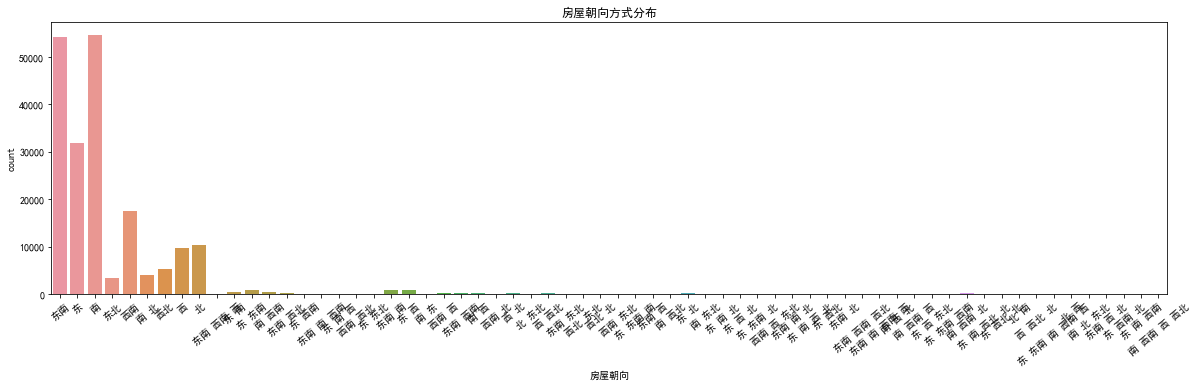

In [8]:
fig,ax=plt.subplots(figsize=(20,5))
sns.countplot(train['房屋朝向'])
plt.title('房屋朝向方式分布')
plt.xticks(rotation=40)
plt.show()

<AxesSubplot:xlabel='卧室数量', ylabel='count'>

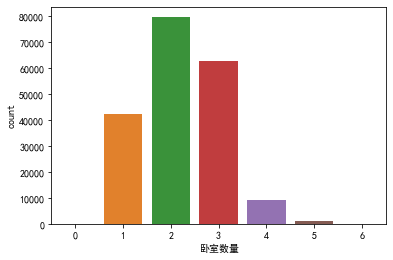

In [9]:
#卧室数量
sns.countplot(train['卧室数量'])

<AxesSubplot:xlabel='楼层', ylabel='count'>

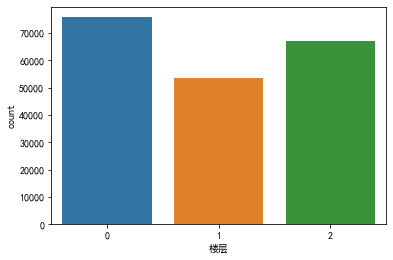

In [10]:
# 各楼层的数量
sns.countplot(train['楼层'])

楼层
0    7.771664
1    8.154357
2    7.888158
Name: Label, dtype: float64

<AxesSubplot:xlabel='楼层', ylabel='Label'>

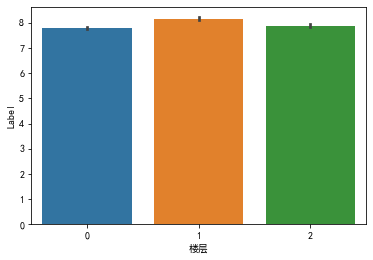

In [11]:
# 不同楼层价格差异
display(train.groupby('楼层')['Label'].mean())
sns.barplot(x='楼层',y='Label',data=train)

Text(0.5, 1.0, '区分布')

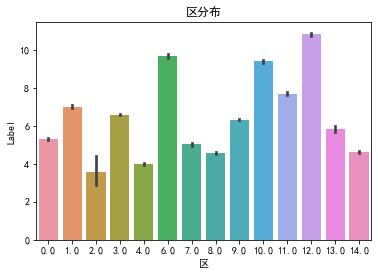

In [12]:
# 不同行政区价格差异
sns.barplot(x='区',y='Label',data=train)
plt.title('区分布')

<AxesSubplot:xlabel='地铁线路', ylabel='Label'>

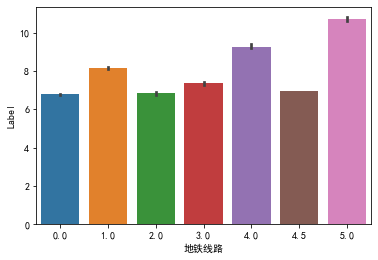

In [13]:
# 不同地铁线路价格差异
sns.barplot(x='地铁线路',y='Label',data=train)

<AxesSubplot:xlabel='装修情况', ylabel='Label'>

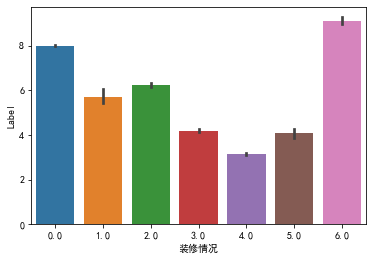

In [14]:
# 不同装修情况价格差异
sns.barplot(x='装修情况',y='Label',data=train)

<AxesSubplot:xlabel='位置'>

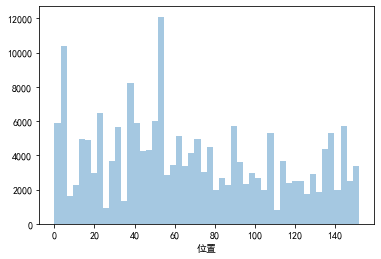

In [15]:
# 商圈分布
sns.distplot(train['位置'],kde=False)

<AxesSubplot:>

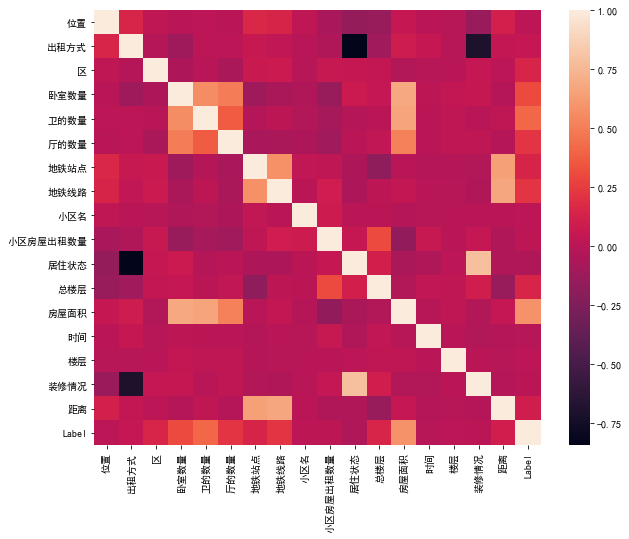

In [16]:
# 各特征之间的相关性
plt.figure(figsize=(10,8))
sns.heatmap(train.corr())

In [17]:
# 特征构造，每个小区的地铁数量
temp = train.groupby('小区名')['地铁站点'].nunique().reset_index()
temp.columns = ['小区名','地铁站点数量']
train = train.merge(temp, how = 'left',on = '小区名')
train['地铁站点数量']=train['地铁站点数量'].fillna(0)
# 对房屋朝向做编码处理
train['房屋朝向'] = LabelEncoder().fit_transform(train['房屋朝向'])

In [18]:
X=train.drop('Label',axis=1)
Y=train.loc[:,'Label']
# 用方差分析进行特征选择
f,p=f_regression(X,Y)
k = f.shape[0] - (p > 0.05).sum()
X = SelectKBest(f_regression, k=k).fit_transform(X, Y)

In [19]:
# 分训练集和测试集
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,Y,test_size=0.3,random_state=420)

In [20]:
times=time()
lr=RandomForestRegressor().fit(Xtrain,Ytrain)
print(lr.score(Xtest,Ytest))
print(datetime.datetime.fromtimestamp(time()-times).strftime("%M:%S:%f"))

0.9370338683913433
01:02:113654


In [21]:
times=time()
lr=LinearRegression().fit(Xtrain,Ytrain)
print(lr.score(Xtest,Ytest))
print(datetime.datetime.fromtimestamp(time()-times).strftime("%M:%S:%f"))

0.46122001117110867
00:00:096088


0.9450433836307471 171


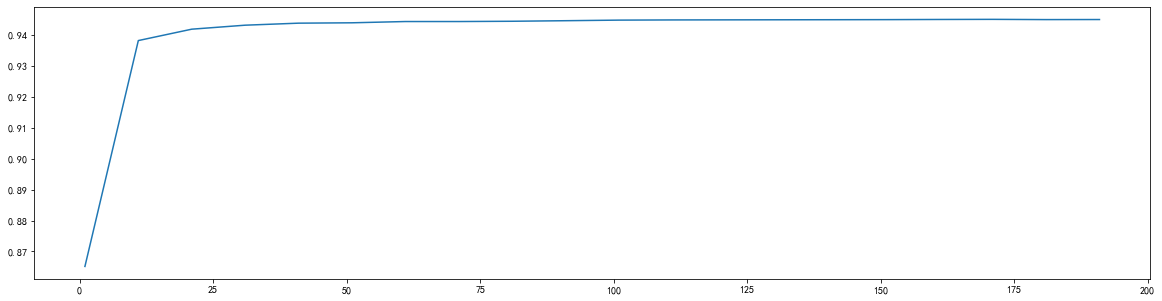

08:18:11:772687


In [22]:
# 确定树的数量
times=time()
scorel = []
for i in range(0,200,10):
    rfc = RandomForestRegressor(n_estimators=i+1,
                                n_jobs=-1,
                                random_state=90)
    score = cross_val_score(rfc,X,Y,cv=5).mean()
    scorel.append(score)
print(max(scorel),(scorel.index(max(scorel))*10)+1)
plt.figure(figsize=[20,5])
plt.plot(range(1,201,10),scorel)
plt.show()
print(datetime.datetime.fromtimestamp(time()-times).strftime("%H:%M:%S:%f"))

In [23]:
param = { "max_depth": list(np.arange(1,52,5)) } 
gs = GridSearchCV(estimator=RandomForestRegressor(n_estimators=171), param_grid=param, cv=2,  n_jobs=-1, verbose=10) 
gs.fit(X, Y) 
print(gs.best_params_) 
print(gs.best_score_) 

Fitting 2 folds for each of 11 candidates, totalling 22 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  22 | elapsed:   14.2s remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   5 out of  22 | elapsed:  1.4min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done   8 out of  22 | elapsed:  1.8min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done  11 out of  22 | elapsed:  2.1min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  14 out of  22 | elapsed:  2.4min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  17 out of  22 | elapsed:  3.2min remaining:   55.6s
[Parallel(n_jobs=-1)]: Done  20 out of  22 | elapsed:  3.5min remaining:   20.7s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:  3.6min finished


{'max_depth': 51}
0.8723620017586058
